In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from nn_utilities import read_train_test, bootstrapped_cv, create_and_save_training_testing_data
from fd_model_nn import FD_Network
from utilities import plot_fd_and_original, plot_fd_and_speeds
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
def get_all_result_data(results):
    tr_mean = []
    tr_std = []
    val_mean = []
    val_std = []
    test_mean = []
    test_std = []
    for key in results.keys():
        tr_mean.append(results[key]['tr'][0])
        tr_std.append(results[key]['tr'][1])
        val_mean.append(results[key]['val'][0])
        val_std.append(results[key]['val'][1])
        test_mean.append(results[key]['test'][0])
        test_std.append(results[key]['test'][1])
    return tr_mean, tr_std, val_mean, val_std, test_mean, test_std

def plot_results(results, tr_mean, tr_std, val_mean, val_std, test_mean, test_std, plot_val=False, title=""):
    fig, ax = plt.subplots()
    ax.fill_between(range(len(tr_std)), [tr_mean[i]+tr_std[i] for i in range(len(tr_std))], [tr_mean[i]-tr_std[i] for i in range(len(tr_std))], alpha=0.2, color='orange')
    ax.plot(tr_mean, label='training_loss', c='orange')
    ax.scatter(range(len(tr_mean)), tr_mean, c='orange')
    
    if plot_val:
        ax.fill_between(range(len(val_std)), [val_mean[i]+val_std[i] for i in range(len(val_std))], [val_mean[i]-val_std[i] for i in range(len(val_std))], alpha=0.2)
        ax.plot(val_mean, label='validation_loss')
        ax.scatter(range(len(val_mean)), val_mean, c='blue')

    ax.fill_between(range(len(test_std)), [test_mean[i]+test_std[i] for i in range(len(test_std))], [test_mean[i]-test_std[i] for i in range(len(test_std))], alpha=0.2, color='red')
    ax.plot(test_mean, label='testing_loss', c='red')
    ax.scatter(range(len(test_mean)), test_mean, c='red')
    plt.legend()
    ax.set_ylabel('MSE')
    ax.set_xlabel('model conf')
    ax.set_xticks(range(len(results.keys())), labels=results.keys())
    plt.title(title)
    plt.show()

def train_both_models(task_train, task_test):
    base_path = "../data/training_data/"
    
    X_t, y_t = None, None
    fd_x_t = None
    for train_data in task_train:
        training_path = base_path + f"train_{train_data}_data"
        try:
            f = open(training_path)
        except IOError:
            create_and_save_training_testing_data(train_data, base_path)

        X_train, y_train, _, _ = read_train_test(train_data, base_path)
        fd_x_train = X_train[:,0].reshape(-1,1)
        
        if X_t is None:
            X_t = X_train
            y_t = y_train
            fd_x_t = fd_x_train
        else:
            X_t = np.concatenate((X_t, X_train), axis=0)
            y_t = np.concatenate((y_t, y_train), axis=0)
            fd_x_t = np.concatenate((fd_x_t, fd_x_train), axis=0)
    
    X_train, y_train, fd_x_train = X_t, y_t, fd_x_t
    
    X_t, y_t = None, None
    fd_x_t = None
    for test_data in task_test:
        testing_path = base_path + f"train_{test_data}_data"
        try:
            f = open(testing_path)
        except IOError:
            create_and_save_training_testing_data(test_data, base_path)

        _, _, X_test, y_test = read_train_test(test_data, base_path)
        fd_x_test = X_test[:,0].reshape(-1,1)
        
        if X_t is None:
            X_t = X_test
            y_t = y_test
            fd_x_t = fd_x_test
        else:
            X_t = np.concatenate((X_t, X_test), axis=0)
            y_t = np.concatenate((y_t, y_test), axis=0)
            fd_x_t = np.concatenate((fd_x_t, fd_x_test), axis=0)
    X_test, y_test, fd_x_test = X_t, y_t, fd_x_t
            
    # train fd
    model = FD_Network()
    fd_losses = bootstrapped_cv(hidden_dims=None, data=fd_x_train, targets=y_train,
                                                         test_data=fd_x_test, test_targets=y_test,
                                                         kfolds=5, epochs=1000, batch_size=32, n_bootstraps=15,
                                                         bootstrap_dim=1000, model=model)
    # train speed nn
    hidden_dims = [(3,)]
    nn_losses = bootstrapped_cv(hidden_dims=(3,), data=X_train, targets=y_train,
                                                     test_data=X_test, test_targets=y_test,
                                                     kfolds=5, epochs=1000, batch_size=32, n_bootstraps=15,
                                                     bootstrap_dim=1000)
    return nn_losses, fd_losses

# TRYING DIFFERENT TRAINING/TESTING SITUATIONS

In [3]:
import tensorflow as tf


class FD_Network(tf.keras.Model):
    """
    network to train a model approximating the Weidmann Model on given data
    """
    def __init__(self):
        """
        initialize the network, very simple feed forward network with 3 parameter outputs
        """
        super(FD_Network, self).__init__()
        self.hidden_layer = tf.keras.layers.Dense(3)
        # output layers producing the 3 parameters of the FD
        self.desired_speed = tf.keras.layers.Dense(1)
        self.pedestrian_size = tf.keras.layers.Dense(1)
        self.time_gap = tf.keras.layers.Dense(1)
        self.FD_model_parameters = {'t': [], 'l': [], 'v0': []}
        self.mse = -1

    def call(self, mean_spacing):
        """
        execute the feedforward, create the fd function from the parameters, return the predicted speed
        :param mean_spacing: only input of the net
        :return: predicted speed
        """
        x = self.hidden_layer(mean_spacing)
        x = tf.keras.activations.sigmoid(x)
        v0 = self.desired_speed(x)
        v0 = tf.keras.activations.softplus(v0)  # if bidirectional not needed!
        l = self.pedestrian_size(x)
        l = tf.keras.activations.softplus(l)
        t = self.time_gap(x)
        t = tf.keras.activations.softplus(t)
        self.FD_model_parameters['t'].append(tf.math.reduce_mean(t))
        self.FD_model_parameters['l'].append(tf.math.reduce_mean(l))
        self.FD_model_parameters['v0'].append(tf.math.reduce_mean(v0))
        return v0 * (1 - tf.exp((l - mean_spacing) / (v0 * t)))


In [4]:
nn_total_losses = {}
fd_total_losses = {}
corridor = 'corridor_85'
bottleneck = 'bottleneck_180'

In [5]:
# trying corridor85/corridor85
task = [corridor]
nn_losses, fd_losses = train_both_models(task_train=task, task_test=task)
nn_total_losses[f'{corridor}-{corridor}'] = nn_losses['test']
fd_total_losses[f'{corridor}-{corridor}'] = fd_losses['test']

Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.2692 - val_loss: 0.2619
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2375 - val_loss: 0.2362
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2137 - val_loss: 0.2147
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1933 - val_loss: 0.1947
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1745 - val_loss: 0.1758
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1569 - val_loss: 0.1582
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1407 - val_loss: 0.1418
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1258 - val_loss: 0.1270
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1126 - val_loss: 0.1133
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1007 - val_loss: 0.1017

25/25 [==============================] - 0s 2ms/step - loss: 0.0518 - val_loss: 0.0501
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0518 - val_loss: 0.0501
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0517 - val_loss: 0.0500
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0517 - val_loss: 0.0500
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0518 - val_loss: 0.0500
Epoch 87/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0517 - val_loss: 0.0500
Epoch 88/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0517 - val_loss: 0.0499
Epoch 89/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0517 - val_loss: 0.0500
Epoch 90/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0517 - val_loss: 0.0499
Epoch 91/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0517 - val_loss: 0.0499
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0511 - val_loss: 0.0492
Epoch 163/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0511 - val_loss: 0.0492
Epoch 164/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0511 - val_loss: 0.0492
Epoch 165/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0511 - val_loss: 0.0492
Epoch 166/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0511 - val_loss: 0.0492
Epoch 167/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0512 - val_loss: 0.0492
Epoch 168/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0511 - val_loss: 0.0492
Epoch 169/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0511 - val_loss: 0.0492
Epoch 170/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0511 - val_loss: 0.0492
Epoch 171/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0511 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0509 - val_loss: 0.0490
Epoch 243/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0509 - val_loss: 0.0490
Epoch 244/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0509 - val_loss: 0.0490
Epoch 245/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0509 - val_loss: 0.0490
Epoch 246/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0509 - val_loss: 0.0489
Epoch 247/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0509 - val_loss: 0.0490
Epoch 248/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0509 - val_loss: 0.0490
Epoch 249/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0509 - val_loss: 0.0489
Epoch 250/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0509 - val_loss: 0.0490
Epoch 251/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0509 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0504 - val_loss: 0.0503
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0504 - val_loss: 0.0503
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0504 - val_loss: 0.0503
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0504 - val_loss: 0.0503
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0503
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0504 - val_loss: 0.0503
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0504 - val_loss: 0.0503
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0504 - val_loss: 0.0503
Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.0532 - val_loss: 0.0391
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0391
Epoch 3/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0517
Epoch 64/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0517
Epoch 65/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0517
Epoch 66/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0517
Epoch 67/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0517
Epoch 68/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0517
Epoch 69/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0517
Epoch 70/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0517
Epoch 71/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0517
Epoch 72/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0517
Epoc

Epoch 144/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0516
Epoch 145/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0516
Epoch 146/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0516
Epoch 147/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0516
Epoch 148/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0516
Epoch 149/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0516
Epoch 150/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0516
Epoch 151/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0516
Epoch 152/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0516
Epoch 153/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500

25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0516
Epoch 225/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0516
Epoch 226/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0516
Epoch 227/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0516
Epoch 228/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0516
Epoch 229/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0516
Epoch 230/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0516
Epoch 231/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0516
Epoch 232/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0516
Epoch 233/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0516
Epoch 305/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0516
Epoch 306/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0516
Epoch 307/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0516
Epoch 308/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0516
Epoch 309/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0516
Epoch 310/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0516
Epoch 311/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0516
Epoch 312/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0516
Epoch 313/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0456 - val_loss: 0.0445
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0456 - val_loss: 0.0445
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0456 - val_loss: 0.0445
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0456 - val_loss: 0.0445
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0456 - val_loss: 0.0445
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0456 - val_loss: 0.0445
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0457 - val_loss: 0.0446
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0456 - val_loss: 0.0445
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0456 - val_loss: 0.0445
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0456 - val_loss: 0.0445
Epoch 13/1

25/25 [==============================] - 0s 2ms/step - loss: 0.0459 - val_loss: 0.0581
Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.0503 - val_loss: 0.0407
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0407
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0407
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0408
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0408
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0408
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0408
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0408
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0408
Epoch 10/1000

Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0446 - val_loss: 0.0454
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0446 - val_loss: 0.0454
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0446 - val_loss: 0.0454
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0446 - val_loss: 0.0454
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0446 - val_loss: 0.0454
Epoch 13/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0446 - val_loss: 0.0454
Epoch 14/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0446 - val_loss: 0.0454
Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.0449 - val_loss: 0.0451
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0448 - val_loss: 0.0451
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0448 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0482 - val_loss: 0.0503
Epoch 20/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0503
Epoch 21/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0503
Epoch 22/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0502
Epoch 23/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0503
Epoch 24/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0503
Epoch 25/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0502
Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.0479 - val_loss: 0.0510
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0479 - val_loss: 0.0511
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0479 - val_loss: 0.0512
Epoch 4

25/25 [==============================] - 0s 2ms/step - loss: 0.0497 - val_loss: 0.0526
Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.0489 - val_loss: 0.0562
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0487 - val_loss: 0.0563
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0487 - val_loss: 0.0563
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0488 - val_loss: 0.0563
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0487 - val_loss: 0.0564
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0487 - val_loss: 0.0563
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0487 - val_loss: 0.0564
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0487 - val_loss: 0.0564
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0487 - val_loss: 0.0564
Epoch 10/1000

25/25 [==============================] - 0s 2ms/step - loss: 0.0473 - val_loss: 0.0458
Epoch 38/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0473 - val_loss: 0.0457
Epoch 39/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0473 - val_loss: 0.0457
Epoch 40/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0472 - val_loss: 0.0457
Epoch 41/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0472 - val_loss: 0.0457
Epoch 42/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0472 - val_loss: 0.0457
Epoch 43/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0473 - val_loss: 0.0457
Epoch 44/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0473 - val_loss: 0.0458
Epoch 45/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0472 - val_loss: 0.0458
Epoch 46/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0473 - val_loss: 0.0457
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0406
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0405
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0404
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0406
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0404
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0405
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0403
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0402
Epoch 13/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0406
Epoch 14/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0403
Epoch 15

25/25 [==============================] - 0s 2ms/step - loss: 0.0467 - val_loss: 0.0497
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0467 - val_loss: 0.0497
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0467 - val_loss: 0.0497
Epoch 13/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0467 - val_loss: 0.0497
Epoch 14/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0467 - val_loss: 0.0497
Epoch 15/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0467 - val_loss: 0.0497
Epoch 16/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0467 - val_loss: 0.0497
Epoch 17/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0467 - val_loss: 0.0497
Epoch 18/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0467 - val_loss: 0.0497
Epoch 19/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0467 - val_loss: 0.0497
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0468 - val_loss: 0.0577
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0468 - val_loss: 0.0577
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0468 - val_loss: 0.0577
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0468 - val_loss: 0.0577
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0468 - val_loss: 0.0577
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0468 - val_loss: 0.0577
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0468 - val_loss: 0.0577
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0468 - val_loss: 0.0577
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0468 - val_loss: 0.0577
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0468 - val_loss: 0.0577
Epoch 12/10

25/25 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0467
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0467
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0467
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0467
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0467
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0467
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0467
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0467
Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.0530 - val_loss: 0.0424
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0529 - val_loss: 0.0422
Epoch 3/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0513 - val_loss: 0.0476
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0513 - val_loss: 0.0476
Epoch 1/1000
25/25 [==============================] - 1s 6ms/step - loss: 0.0490 - val_loss: 0.0573
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0489 - val_loss: 0.0573
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0489 - val_loss: 0.0575
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0489 - val_loss: 0.0573
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0489 - val_loss: 0.0575
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0489 - val_loss: 0.0574
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0489 - val_loss: 0.0572
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0489 - val_loss: 0.0575
Epoch 9/1000

25/25 [==============================] - 0s 2ms/step - loss: 0.0415 - val_loss: 0.0520
Epoch 42/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0415 - val_loss: 0.0520
Epoch 43/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0415 - val_loss: 0.0520
Epoch 44/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0415 - val_loss: 0.0520
Epoch 45/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0415 - val_loss: 0.0520
Epoch 46/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0415 - val_loss: 0.0520
Epoch 47/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0415 - val_loss: 0.0520
Epoch 48/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0415 - val_loss: 0.0520
Epoch 49/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0415 - val_loss: 0.0520
Epoch 1/1000
25/25 [==============================] - 1s 6ms/step - loss: 0.0446 - val_loss: 0.0397
Epoch

25/25 [==============================] - 0s 3ms/step - loss: 0.0506 - val_loss: 0.0495
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0506 - val_loss: 0.0494
Epoch 13/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0506 - val_loss: 0.0495
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0501 - val_loss: 0.0516
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0500 - val_loss: 0.0521
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0500 - val_loss: 0.0522
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0500 - val_loss: 0.0521
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0500 - val_loss: 0.0523
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0500 - val_loss: 0.0521
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0499 - val_loss: 0.0523
Epoch 8/100

25/25 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.0459
Epoch 53/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.0459
Epoch 54/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.0459
Epoch 55/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.0459
Epoch 56/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.0459
Epoch 57/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.0459
Epoch 58/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.0459
Epoch 59/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.0459
Epoch 60/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.0459
Epoch 61/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.0459
Epoc

Epoch 133/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.0459
Epoch 134/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.0459
Epoch 135/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.0459
Epoch 136/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.0459
Epoch 137/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.0459
Epoch 138/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.0459
Epoch 139/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.0459
Epoch 140/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.0459
Epoch 141/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.0459
Epoch 142/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0514

25/25 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.0458
Epoch 214/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.0458
Epoch 215/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.0458
Epoch 216/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.0458
Epoch 217/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.0458
Epoch 218/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.0458
Epoch 219/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.0458
Epoch 220/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.0458
Epoch 221/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.0458
Epoch 222/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.0458
Epoch 294/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.0458
Epoch 295/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.0458
Epoch 296/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.0458
Epoch 297/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.0458
Epoch 298/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0514 - val_loss: 0.0458
Epoch 299/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0514 - val_loss: 0.0458
Epoch 300/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0514 - val_loss: 0.0458
Epoch 301/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0514 - val_loss: 0.0458
Epoch 302/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0514 - val_loss: 0.

25/25 [==============================] - 0s 4ms/step - loss: 0.0513 - val_loss: 0.0457
Epoch 374/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0513 - val_loss: 0.0457
Epoch 375/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0514 - val_loss: 0.0457
Epoch 376/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0514 - val_loss: 0.0457
Epoch 377/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0513 - val_loss: 0.0457
Epoch 378/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0514 - val_loss: 0.0457
Epoch 379/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0514 - val_loss: 0.0457
Epoch 380/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0514 - val_loss: 0.0457
Epoch 381/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0513 - val_loss: 0.0457
Epoch 382/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0514 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0513 - val_loss: 0.0457
Epoch 454/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0513 - val_loss: 0.0457
Epoch 455/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.0457
Epoch 456/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.0457
Epoch 457/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.0457
Epoch 458/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.0457
Epoch 459/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.0457
Epoch 460/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.0457
Epoch 461/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0513 - val_loss: 0.0457
Epoch 462/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0513 - val_loss: 0.

Epoch 18/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0485 - val_loss: 0.0437
Epoch 19/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0485 - val_loss: 0.0437
Epoch 20/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0485 - val_loss: 0.0437
Epoch 21/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0485 - val_loss: 0.0437
Epoch 22/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0485 - val_loss: 0.0437
Epoch 23/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0485 - val_loss: 0.0437
Epoch 24/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0485 - val_loss: 0.0437
Epoch 25/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0485 - val_loss: 0.0437
Epoch 26/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0485 - val_loss: 0.0437
Epoch 27/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0485 - val_los

25/25 [==============================] - 0s 3ms/step - loss: 0.0487 - val_loss: 0.0429
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0487 - val_loss: 0.0428
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0487 - val_loss: 0.0429
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0487 - val_loss: 0.0430
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0487 - val_loss: 0.0429
Epoch 1/1000
25/25 [==============================] - 1s 13ms/step - loss: 0.0501 - val_loss: 0.0464
Epoch 2/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0501 - val_loss: 0.0464
Epoch 3/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0501 - val_loss: 0.0465
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0501 - val_loss: 0.0464
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0501 - val_loss: 0.0464
Epoch 6/10

25/25 [==============================] - 0s 3ms/step - loss: 0.0571 - val_loss: 0.0674
Epoch 19/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0561 - val_loss: 0.0665
Epoch 20/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0551 - val_loss: 0.0661
Epoch 21/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0542 - val_loss: 0.0657
Epoch 22/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0535 - val_loss: 0.0651
Epoch 23/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0528 - val_loss: 0.0646
Epoch 24/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0522 - val_loss: 0.0643
Epoch 25/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0517 - val_loss: 0.0640
Epoch 26/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0512 - val_loss: 0.0635
Epoch 27/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0635
Epoc

25/25 [==============================] - 0s 3ms/step - loss: 0.0409 - val_loss: 0.0565
Epoch 100/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0408 - val_loss: 0.0562
Epoch 101/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0407 - val_loss: 0.0565
Epoch 102/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0407 - val_loss: 0.0563
Epoch 103/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.0559
Epoch 104/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0405 - val_loss: 0.0562
Epoch 105/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0404 - val_loss: 0.0561
Epoch 106/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0405 - val_loss: 0.0558
Epoch 107/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0402 - val_loss: 0.0561
Epoch 108/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0403 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0359 - val_loss: 0.0514
Epoch 180/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.0514
Epoch 181/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0359 - val_loss: 0.0516
Epoch 182/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0513
Epoch 183/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0512
Epoch 184/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0511
Epoch 185/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0510
Epoch 186/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.0513
Epoch 187/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.0507
Epoch 188/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0316 - val_loss: 0.0475
Epoch 260/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.0472
Epoch 261/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0316 - val_loss: 0.0473
Epoch 262/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0315 - val_loss: 0.0473
Epoch 263/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0315 - val_loss: 0.0473
Epoch 264/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0316 - val_loss: 0.0473
Epoch 265/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0314 - val_loss: 0.0470
Epoch 266/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0314 - val_loss: 0.0471
Epoch 267/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0313 - val_loss: 0.0472
Epoch 268/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0314 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0292 - val_loss: 0.0455
Epoch 340/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0292 - val_loss: 0.0458
Epoch 341/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0291 - val_loss: 0.0456
Epoch 342/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0291 - val_loss: 0.0455
Epoch 343/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0292 - val_loss: 0.0456
Epoch 344/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0293 - val_loss: 0.0457
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0340 - val_loss: 0.0268
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0271
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0334 - val_loss: 0.0272
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0334 - val_loss: 0.0275
Epo

25/25 [==============================] - 0s 3ms/step - loss: 0.0499 - val_loss: 0.0575
Epoch 33/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0496 - val_loss: 0.0573
Epoch 34/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0572
Epoch 35/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0569
Epoch 36/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0569
Epoch 37/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0490 - val_loss: 0.0561
Epoch 38/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0488 - val_loss: 0.0565
Epoch 39/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0486 - val_loss: 0.0562
Epoch 40/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0484 - val_loss: 0.0560
Epoch 41/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0483 - val_loss: 0.0553
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0426 - val_loss: 0.0475
Epoch 114/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0426 - val_loss: 0.0479
Epoch 115/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0425 - val_loss: 0.0477
Epoch 116/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0425 - val_loss: 0.0476
Epoch 117/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0472
Epoch 118/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0471
Epoch 119/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0422 - val_loss: 0.0474
Epoch 120/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0422 - val_loss: 0.0474
Epoch 121/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0467
Epoch 122/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0419 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0371 - val_loss: 0.0427
Epoch 194/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0370 - val_loss: 0.0427
Epoch 195/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0370 - val_loss: 0.0426
Epoch 196/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0369 - val_loss: 0.0424
Epoch 197/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0369 - val_loss: 0.0425
Epoch 198/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0369 - val_loss: 0.0425
Epoch 199/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0426
Epoch 200/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0426
Epoch 201/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0426
Epoch 202/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0352 - val_loss: 0.0331
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0351 - val_loss: 0.0330
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0352 - val_loss: 0.0330
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0345 - val_loss: 0.0364
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0342 - val_loss: 0.0363
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0340 - val_loss: 0.0368
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0340 - val_loss: 0.0371
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0372
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0372
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0375
Epoch 8/100

25/25 [==============================] - 0s 3ms/step - loss: 0.0511 - val_loss: 0.0559
Epoch 68/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0509 - val_loss: 0.0556
Epoch 69/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0507 - val_loss: 0.0556
Epoch 70/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0556
Epoch 71/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0504 - val_loss: 0.0556
Epoch 72/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0502 - val_loss: 0.0555
Epoch 73/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0502 - val_loss: 0.0554
Epoch 74/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0499 - val_loss: 0.0554
Epoch 75/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0498 - val_loss: 0.0554
Epoch 76/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0497 - val_loss: 0.0552
Epoc

Epoch 148/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0407 - val_loss: 0.0490
Epoch 149/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.0490
Epoch 150/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.0489
Epoch 151/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0404 - val_loss: 0.0488
Epoch 152/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0402 - val_loss: 0.0487
Epoch 153/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0401 - val_loss: 0.0488
Epoch 154/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0401 - val_loss: 0.0486
Epoch 155/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0399 - val_loss: 0.0485
Epoch 156/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0398 - val_loss: 0.0483
Epoch 157/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0398

25/25 [==============================] - 0s 2ms/step - loss: 0.0359 - val_loss: 0.0369
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0368
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.0369
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0370
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0371
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0359 - val_loss: 0.0354
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.0358
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0361
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0362
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0363
Epoch 6/100

25/25 [==============================] - 0s 3ms/step - loss: 0.0566 - val_loss: 0.0674
Epoch 45/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0562 - val_loss: 0.0669
Epoch 46/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0559 - val_loss: 0.0667
Epoch 47/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0556 - val_loss: 0.0665
Epoch 48/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0553 - val_loss: 0.0663
Epoch 49/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0550 - val_loss: 0.0661
Epoch 50/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0548 - val_loss: 0.0658
Epoch 51/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0545 - val_loss: 0.0657
Epoch 52/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0542 - val_loss: 0.0655
Epoch 53/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0539 - val_loss: 0.0652
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0443 - val_loss: 0.0574
Epoch 125/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0442 - val_loss: 0.0575
Epoch 126/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0442 - val_loss: 0.0574
Epoch 127/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0441 - val_loss: 0.0572
Epoch 128/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0440 - val_loss: 0.0571
Epoch 129/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0439 - val_loss: 0.0569
Epoch 130/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0438 - val_loss: 0.0569
Epoch 131/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0438 - val_loss: 0.0567
Epoch 132/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0437 - val_loss: 0.0565
Epoch 133/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0436 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0394 - val_loss: 0.0500
Epoch 205/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0394 - val_loss: 0.0497
Epoch 206/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0393 - val_loss: 0.0497
Epoch 207/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0393 - val_loss: 0.0498
Epoch 208/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0391 - val_loss: 0.0495
Epoch 209/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0391 - val_loss: 0.0495
Epoch 210/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0391 - val_loss: 0.0495
Epoch 211/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.0494
Epoch 212/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0390 - val_loss: 0.0495
Epoch 213/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0390 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0360 - val_loss: 0.0454
Epoch 285/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.0454
Epoch 286/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.0453
Epoch 287/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.0454
Epoch 288/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0359 - val_loss: 0.0450
Epoch 289/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0359 - val_loss: 0.0451
Epoch 290/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0359 - val_loss: 0.0453
Epoch 291/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0453
Epoch 292/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0452
Epoch 293/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0425
Epoch 365/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0425
Epoch 366/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.0424
Epoch 367/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0424
Epoch 368/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.0423
Epoch 369/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0423
Epoch 370/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0423
Epoch 371/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0423
Epoch 372/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0424
Epoch 373/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0341 - val_loss: 0.0337
Epoch 1/1000
25/25 [==============================] - ETA: 8s - loss: 0.036 - 1s 7ms/step - loss: 0.0354 - val_loss: 0.0291
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0350 - val_loss: 0.0296
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0294
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0297
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0300
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0348 - val_loss: 0.0300
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0299
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0348 - val_loss: 0.0302
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0346 - val_lo

25/25 [==============================] - 0s 2ms/step - loss: 0.0544 - val_loss: 0.0636
Epoch 48/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0543 - val_loss: 0.0634
Epoch 49/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0542 - val_loss: 0.0633
Epoch 50/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0541 - val_loss: 0.0632
Epoch 51/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0540 - val_loss: 0.0631
Epoch 52/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0540 - val_loss: 0.0632
Epoch 53/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0538 - val_loss: 0.0629
Epoch 54/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0537 - val_loss: 0.0628
Epoch 55/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0537 - val_loss: 0.0628
Epoch 56/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0536 - val_loss: 0.0628
Epoc

Epoch 128/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0463 - val_loss: 0.0539
Epoch 129/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0461 - val_loss: 0.0538
Epoch 130/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0462 - val_loss: 0.0535
Epoch 131/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0459 - val_loss: 0.0534
Epoch 132/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0457 - val_loss: 0.0533
Epoch 133/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0457 - val_loss: 0.0533
Epoch 134/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0455 - val_loss: 0.0530
Epoch 135/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0455 - val_loss: 0.0530
Epoch 136/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0453 - val_loss: 0.0525
Epoch 137/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0452

25/25 [==============================] - 0s 2ms/step - loss: 0.0384 - val_loss: 0.0436
Epoch 209/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0383 - val_loss: 0.0437
Epoch 210/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0383 - val_loss: 0.0437
Epoch 211/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.0434
Epoch 212/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.0433
Epoch 213/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0380 - val_loss: 0.0433
Epoch 214/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0380 - val_loss: 0.0431
Epoch 215/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0431
Epoch 216/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0428
Epoch 217/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0378 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0371
Epoch 289/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0352 - val_loss: 0.0372
Epoch 290/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0370
Epoch 291/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0368
Epoch 292/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0370
Epoch 293/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0350 - val_loss: 0.0369
Epoch 294/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0367
Epoch 295/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0368
Epoch 296/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0350 - val_loss: 0.0367
Epoch 297/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0350 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0341
Epoch 369/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0340
Epoch 370/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.0339
Epoch 371/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0341 - val_loss: 0.0342
Epoch 372/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0339
Epoch 373/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0340
Epoch 374/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0338
Epoch 375/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0339
Epoch 376/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0340
Epoch 377/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.

Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0324 - val_loss: 0.0357
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0322 - val_loss: 0.0365
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0322 - val_loss: 0.0361
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.0364
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.0363
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.0367
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0320 - val_loss: 0.0366
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0320 - val_loss: 0.0367
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.0366
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0320 - val_loss: 0.036

25/25 [==============================] - 0s 2ms/step - loss: 0.0508 - val_loss: 0.0589
Epoch 62/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0589
Epoch 63/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0588
Epoch 64/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0501 - val_loss: 0.0586
Epoch 65/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0585
Epoch 66/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0498 - val_loss: 0.0583
Epoch 67/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0497 - val_loss: 0.0582
Epoch 68/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0581
Epoch 69/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0580
Epoch 70/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0578
Epoc

Epoch 142/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0499
Epoch 143/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0498
Epoch 144/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0420 - val_loss: 0.0498
Epoch 145/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0419 - val_loss: 0.0497
Epoch 146/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0419 - val_loss: 0.0496
Epoch 147/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0418 - val_loss: 0.0495
Epoch 148/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0417 - val_loss: 0.0493
Epoch 149/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0416 - val_loss: 0.0494
Epoch 150/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0416 - val_loss: 0.0492
Epoch 151/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0415

25/25 [==============================] - 0s 2ms/step - loss: 0.0369 - val_loss: 0.0446
Epoch 223/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0445
Epoch 224/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0445
Epoch 225/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0445
Epoch 226/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0443
Epoch 227/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0443
Epoch 228/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0441
Epoch 229/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0443
Epoch 230/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0364 - val_loss: 0.0442
Epoch 231/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0363 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0361
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0360
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0346 - val_loss: 0.0362
Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.0347 - val_loss: 0.0375
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0343 - val_loss: 0.0373
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0342 - val_loss: 0.0374
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0341 - val_loss: 0.0377
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0341 - val_loss: 0.0379
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0341 - val_loss: 0.0378
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0383
Epoch 8/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0526 - val_loss: 0.0650
Epoch 46/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0525 - val_loss: 0.0650
Epoch 47/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0523 - val_loss: 0.0648
Epoch 48/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0522 - val_loss: 0.0646
Epoch 49/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0521 - val_loss: 0.0646
Epoch 50/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0519 - val_loss: 0.0645
Epoch 51/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0519 - val_loss: 0.0644
Epoch 52/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0517 - val_loss: 0.0640
Epoch 53/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0516 - val_loss: 0.0640
Epoch 54/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0515 - val_loss: 0.0640
Epoc

Epoch 126/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0538
Epoch 127/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0422 - val_loss: 0.0535
Epoch 128/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0420 - val_loss: 0.0535
Epoch 129/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0419 - val_loss: 0.0532
Epoch 130/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0417 - val_loss: 0.0531
Epoch 131/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0416 - val_loss: 0.0530
Epoch 132/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0414 - val_loss: 0.0525
Epoch 133/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0413 - val_loss: 0.0523
Epoch 134/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0412 - val_loss: 0.0523
Epoch 135/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0410

Epoch 206/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0342 - val_loss: 0.0430
Epoch 207/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.0424
Epoch 208/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.0425
Epoch 209/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.0423
Epoch 210/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.0425
Epoch 211/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0424
Epoch 212/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0421
Epoch 213/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0421
Epoch 214/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0422
Epoch 215/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0337

25/25 [==============================] - 0s 2ms/step - loss: 0.0317 - val_loss: 0.0393
Epoch 287/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0317 - val_loss: 0.0395
Epoch 288/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0317 - val_loss: 0.0392
Epoch 289/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.0393
Epoch 290/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.0393
Epoch 291/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0315 - val_loss: 0.0393
Epoch 292/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.0393
Epoch 293/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.0389
Epoch 294/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.0392
Epoch 295/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0315 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0336 - val_loss: 0.0248
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0248
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.2241 - val_loss: 0.1812
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1681 - val_loss: 0.1398
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1338 - val_loss: 0.1154
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1131 - val_loss: 0.1014
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.1004 - val_loss: 0.0929
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0915 - val_loss: 0.0867
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0850 - val_loss: 0.0818
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0798 - val_loss: 0.0776
Epoch 9/1000

25/25 [==============================] - 0s 2ms/step - loss: 0.0439 - val_loss: 0.0491
Epoch 81/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0438 - val_loss: 0.0492
Epoch 82/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0438 - val_loss: 0.0491
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0438 - val_loss: 0.0489
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0436 - val_loss: 0.0490
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0436 - val_loss: 0.0489
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0434 - val_loss: 0.0488
Epoch 87/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0434 - val_loss: 0.0487
Epoch 88/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0433 - val_loss: 0.0485
Epoch 89/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0486
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0391 - val_loss: 0.0451
Epoch 161/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.0448
Epoch 162/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0391 - val_loss: 0.0449
Epoch 163/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0390 - val_loss: 0.0447
Epoch 164/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0390 - val_loss: 0.0450
Epoch 165/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0391 - val_loss: 0.0449
Epoch 166/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0389 - val_loss: 0.0447
Epoch 167/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0388 - val_loss: 0.0448
Epoch 168/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0389 - val_loss: 0.0447
Epoch 169/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0388 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0437
Epoch 241/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0436
Epoch 242/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0437
Epoch 243/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0359 - val_loss: 0.0436
Epoch 244/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.0435
Epoch 245/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.0437
Epoch 246/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.0437
Epoch 247/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0434
Epoch 248/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0436
Epoch 249/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.

Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.0328
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.0329
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0329
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0330
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0329
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0332
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0356 - val_loss: 0.0332
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.0331
Epoch 1/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0352 - val_loss: 0.0353
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.035

25/25 [==============================] - 0s 2ms/step - loss: 0.0455 - val_loss: 0.0445
Epoch 64/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0444
Epoch 65/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0450 - val_loss: 0.0443
Epoch 66/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0449 - val_loss: 0.0443
Epoch 67/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0448 - val_loss: 0.0441
Epoch 68/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0446 - val_loss: 0.0440
Epoch 69/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0446 - val_loss: 0.0438
Epoch 70/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0445 - val_loss: 0.0438
Epoch 71/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0443 - val_loss: 0.0437
Epoch 72/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0441 - val_loss: 0.0436
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0370 - val_loss: 0.0359
Epoch 144/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0370 - val_loss: 0.0359
Epoch 145/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0369 - val_loss: 0.0360
Epoch 146/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0369 - val_loss: 0.0359
Epoch 147/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0368 - val_loss: 0.0361
Epoch 148/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0367 - val_loss: 0.0356
Epoch 149/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0354
Epoch 150/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0354
Epoch 151/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0353
Epoch 152/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0363 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0317 - val_loss: 0.0305
Epoch 224/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0317 - val_loss: 0.0304
Epoch 225/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0317 - val_loss: 0.0307
Epoch 226/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0318 - val_loss: 0.0302
Epoch 227/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.0305
Epoch 228/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0315 - val_loss: 0.0304
Epoch 229/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0315 - val_loss: 0.0303
Epoch 230/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0315 - val_loss: 0.0304
Epoch 231/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0314 - val_loss: 0.0300
Epoch 232/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0314 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.5847 - val_loss: 0.5721
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.4879 - val_loss: 0.4797
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.4058 - val_loss: 0.4037
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.3384 - val_loss: 0.3395
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2813 - val_loss: 0.2874
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2353 - val_loss: 0.2441
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1982 - val_loss: 0.2081
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1679 - val_loss: 0.1797
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1438 - val_loss: 0.1573
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1251 - val_loss: 0.1393
Epoch 13/1

25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0594
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0594
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0595
Epoch 87/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0593
Epoch 88/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0492 - val_loss: 0.0591
Epoch 89/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0590
Epoch 90/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0591
Epoch 91/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0490 - val_loss: 0.0591
Epoch 92/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0489 - val_loss: 0.0590
Epoch 93/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0488 - val_loss: 0.0587
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0438 - val_loss: 0.0543
Epoch 165/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0437 - val_loss: 0.0541
Epoch 166/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0436 - val_loss: 0.0542
Epoch 167/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0437 - val_loss: 0.0542
Epoch 168/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0435 - val_loss: 0.0540
Epoch 169/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0434 - val_loss: 0.0537
Epoch 170/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0434 - val_loss: 0.0540
Epoch 171/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0433 - val_loss: 0.0535
Epoch 172/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0535
Epoch 173/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0385 - val_loss: 0.0489
Epoch 245/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0384 - val_loss: 0.0490
Epoch 246/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0384 - val_loss: 0.0486
Epoch 247/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.0489
Epoch 248/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0383 - val_loss: 0.0485
Epoch 249/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0381 - val_loss: 0.0489
Epoch 250/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.0486
Epoch 251/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0381 - val_loss: 0.0486
Epoch 252/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0380 - val_loss: 0.0484
Epoch 253/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0381 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0457
Epoch 325/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0456
Epoch 326/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0458
Epoch 327/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.0455
Epoch 328/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0360 - val_loss: 0.0457
Epoch 329/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.0453
Epoch 330/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0360 - val_loss: 0.0460
Epoch 331/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0360 - val_loss: 0.0459
Epoch 332/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0360 - val_loss: 0.0453
Epoch 333/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0616 - val_loss: 0.0633
Epoch 13/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0600 - val_loss: 0.0618
Epoch 14/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0586 - val_loss: 0.0609
Epoch 15/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0574 - val_loss: 0.0598
Epoch 16/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0565 - val_loss: 0.0588
Epoch 17/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0555 - val_loss: 0.0581
Epoch 18/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0548 - val_loss: 0.0575
Epoch 19/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0541 - val_loss: 0.0569
Epoch 20/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0535 - val_loss: 0.0562
Epoch 21/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0530 - val_loss: 0.0557
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0418 - val_loss: 0.0450
Epoch 94/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0418 - val_loss: 0.0448
Epoch 95/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0418 - val_loss: 0.0449
Epoch 96/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0415 - val_loss: 0.0447
Epoch 97/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0415 - val_loss: 0.0447
Epoch 98/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0414 - val_loss: 0.0445
Epoch 99/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0414 - val_loss: 0.0445
Epoch 100/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0414 - val_loss: 0.0445
Epoch 101/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0413 - val_loss: 0.0444
Epoch 102/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0411 - val_loss: 0.0444
E

25/25 [==============================] - 0s 2ms/step - loss: 0.0378 - val_loss: 0.0417
Epoch 174/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0378 - val_loss: 0.0418
Epoch 175/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0419
Epoch 176/1000
25/25 [==============================] - ETA: 0s - loss: 0.033 - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0417
Epoch 177/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0417
Epoch 178/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0417
Epoch 179/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0417
Epoch 180/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0375 - val_loss: 0.0416
Epoch 181/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0375 - val_loss: 0.0417
Epoch 182/1000
25/25 [==============================] - 0s 2ms/step - los

25/25 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0395
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.0395
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0359 - val_loss: 0.0399
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0359 - val_loss: 0.0397
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0359 - val_loss: 0.0399
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0400
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0359 - val_loss: 0.0401
Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.0373 - val_loss: 0.0358
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0368 - val_loss: 0.0365
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0366
Epoch 4/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0777 - val_loss: 0.0815
Epoch 43/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0753 - val_loss: 0.0790
Epoch 44/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0730 - val_loss: 0.0769
Epoch 45/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0711 - val_loss: 0.0751
Epoch 46/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0694 - val_loss: 0.0735
Epoch 47/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0680 - val_loss: 0.0722
Epoch 48/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0667 - val_loss: 0.0710
Epoch 49/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0656 - val_loss: 0.0700
Epoch 50/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0646 - val_loss: 0.0691
Epoch 51/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0638 - val_loss: 0.0683
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0543 - val_loss: 0.0637
Epoch 124/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0543 - val_loss: 0.0637
Epoch 125/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0542 - val_loss: 0.0637
Epoch 126/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0542 - val_loss: 0.0636
Epoch 127/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0541 - val_loss: 0.0637
Epoch 128/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0541 - val_loss: 0.0637
Epoch 129/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0540 - val_loss: 0.0637
Epoch 130/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0540 - val_loss: 0.0637
Epoch 131/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0539 - val_loss: 0.0636
Epoch 132/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0539 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0602
Epoch 204/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0605
Epoch 205/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0599
Epoch 206/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0600
Epoch 207/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0599
Epoch 208/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0598
Epoch 209/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0599
Epoch 210/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0490 - val_loss: 0.0595
Epoch 211/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0489 - val_loss: 0.0597
Epoch 212/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0488 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0418 - val_loss: 0.0503
Epoch 284/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0416 - val_loss: 0.0501
Epoch 285/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0417 - val_loss: 0.0502
Epoch 286/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0415 - val_loss: 0.0500
Epoch 287/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0414 - val_loss: 0.0496
Epoch 288/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0412 - val_loss: 0.0495
Epoch 289/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0411 - val_loss: 0.0495
Epoch 290/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0411 - val_loss: 0.0495
Epoch 291/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.0494
Epoch 292/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0359 - val_loss: 0.0429
Epoch 364/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0359 - val_loss: 0.0426
Epoch 365/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0423
Epoch 366/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0423
Epoch 367/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.0425
Epoch 368/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0427
Epoch 369/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.0423
Epoch 370/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0422
Epoch 371/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.0421
Epoch 372/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.

Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.0365
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.0363
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.0363
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0351 - val_loss: 0.0343
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0346
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0347
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0350
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0349
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0354
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.035

25/25 [==============================] - 0s 2ms/step - loss: 0.0525 - val_loss: 0.0557
Epoch 58/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0523 - val_loss: 0.0557
Epoch 59/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0523 - val_loss: 0.0556
Epoch 60/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0521 - val_loss: 0.0558
Epoch 61/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0519 - val_loss: 0.0555
Epoch 62/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0519 - val_loss: 0.0551
Epoch 63/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0517 - val_loss: 0.0555
Epoch 64/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0516 - val_loss: 0.0552
Epoch 65/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0515 - val_loss: 0.0549
Epoch 66/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0513 - val_loss: 0.0549
Epoc

Epoch 138/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0425 - val_loss: 0.0471
Epoch 139/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0468
Epoch 140/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0422 - val_loss: 0.0467
Epoch 141/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0420 - val_loss: 0.0469
Epoch 142/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0420 - val_loss: 0.0468
Epoch 143/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0418 - val_loss: 0.0465
Epoch 144/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0419 - val_loss: 0.0466
Epoch 145/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0417 - val_loss: 0.0463
Epoch 146/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0416 - val_loss: 0.0463
Epoch 147/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0415

25/25 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.0413
Epoch 219/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0360 - val_loss: 0.0413
Epoch 220/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0360 - val_loss: 0.0407
Epoch 221/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0359 - val_loss: 0.0413
Epoch 222/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0360 - val_loss: 0.0408
Epoch 223/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.0410
Epoch 224/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0407
Epoch 225/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0409
Epoch 226/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0407
Epoch 227/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0343 - val_loss: 0.0346
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0343 - val_loss: 0.0348
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0342 - val_loss: 0.0351
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.0351
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.0351
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0356
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0355
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0355
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0356
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0358
Epoch 1/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0518 - val_loss: 0.0545
Epoch 51/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0516 - val_loss: 0.0545
Epoch 52/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0514 - val_loss: 0.0544
Epoch 53/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0513 - val_loss: 0.0544
Epoch 54/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0512 - val_loss: 0.0544
Epoch 55/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0510 - val_loss: 0.0544
Epoch 56/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0509 - val_loss: 0.0543
Epoch 57/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0508 - val_loss: 0.0543
Epoch 58/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0544
Epoch 59/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0544
Epoc

Epoch 131/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0454 - val_loss: 0.0522
Epoch 132/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0453 - val_loss: 0.0521
Epoch 133/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0520
Epoch 134/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0520
Epoch 135/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0451 - val_loss: 0.0521
Epoch 136/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0450 - val_loss: 0.0519
Epoch 137/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0449 - val_loss: 0.0519
Epoch 138/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0448 - val_loss: 0.0517
Epoch 139/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0447 - val_loss: 0.0518
Epoch 140/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0446

25/25 [==============================] - 0s 2ms/step - loss: 0.0380 - val_loss: 0.0457
Epoch 212/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0455
Epoch 213/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0378 - val_loss: 0.0455
Epoch 214/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0378 - val_loss: 0.0454
Epoch 215/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0454
Epoch 216/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0375 - val_loss: 0.0452
Epoch 217/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0374 - val_loss: 0.0452
Epoch 218/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.0449
Epoch 219/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.0447
Epoch 220/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0372 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0336 - val_loss: 0.0402
Epoch 292/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0336 - val_loss: 0.0406
Epoch 293/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.0405
Epoch 294/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0401
Epoch 295/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.0404
Epoch 296/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.0404
Epoch 297/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0336 - val_loss: 0.0406
Epoch 298/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0334 - val_loss: 0.0400
Epoch 299/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0333 - val_loss: 0.0403
Epoch 300/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0334 - val_loss: 0.

Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0333 - val_loss: 0.0339
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0333 - val_loss: 0.0341
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0331 - val_loss: 0.0341
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.0342
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0331 - val_loss: 0.0344
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0330 - val_loss: 0.0347
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0330 - val_loss: 0.0347
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0330 - val_loss: 0.0346
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0346 - val_loss: 0.0291
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0343 - val_loss: 0.029

25/25 [==============================] - 0s 2ms/step - loss: 0.0489 - val_loss: 0.0536
Epoch 64/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0487 - val_loss: 0.0534
Epoch 65/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0487 - val_loss: 0.0531
Epoch 66/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0486 - val_loss: 0.0532
Epoch 67/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0484 - val_loss: 0.0530
Epoch 68/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0484 - val_loss: 0.0527
Epoch 69/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0483 - val_loss: 0.0528
Epoch 70/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0527
Epoch 71/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0525
Epoch 72/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0479 - val_loss: 0.0523
Epoc

Epoch 144/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0404 - val_loss: 0.0446
Epoch 145/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0402 - val_loss: 0.0441
Epoch 146/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0401 - val_loss: 0.0442
Epoch 147/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0400 - val_loss: 0.0440
Epoch 148/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0399 - val_loss: 0.0437
Epoch 149/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0398 - val_loss: 0.0437
Epoch 150/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0397 - val_loss: 0.0438
Epoch 151/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0395 - val_loss: 0.0434
Epoch 152/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0394 - val_loss: 0.0435
Epoch 153/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0393

25/25 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0382
Epoch 225/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0377
Epoch 226/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0377
Epoch 227/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0378
Epoch 228/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0336 - val_loss: 0.0378
Epoch 229/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0336 - val_loss: 0.0376
Epoch 230/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.0375
Epoch 231/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.0378
Epoch 232/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.0379
Epoch 233/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.

Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0311 - val_loss: 0.0364
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0311 - val_loss: 0.0366
Epoch 1/1000
25/25 [==============================] - 1s 6ms/step - loss: 0.0343 - val_loss: 0.0242
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0247
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0249
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0252
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0253
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0253
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0336 - val_loss: 0.0253
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.025

In [6]:
# trying bottleneck180/bottleneck180
task = [bottleneck]
nn_losses, fd_losses = train_both_models(task_train=task, task_test=task)
nn_total_losses[f'{bottleneck}-{bottleneck}'] = nn_losses['test']
fd_total_losses[f'{bottleneck}-{bottleneck}'] = fd_losses['test']

Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.9757 - val_loss: 0.7829
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.7427 - val_loss: 0.6422
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.6349 - val_loss: 0.5633
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.5654 - val_loss: 0.5101
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.5154 - val_loss: 0.4643
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.4720 - val_loss: 0.4254
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.4338 - val_loss: 0.3904
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.3988 - val_loss: 0.3579
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.3661 - val_loss: 0.3270
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.3350 - val_loss: 0.2976

25/25 [==============================] - 0s 2ms/step - loss: 0.0411 - val_loss: 0.0384
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0410 - val_loss: 0.0383
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0410 - val_loss: 0.0382
Epoch 85/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0409 - val_loss: 0.0382
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.0383
Epoch 87/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0408 - val_loss: 0.0382
Epoch 88/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0408 - val_loss: 0.0382
Epoch 89/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0407 - val_loss: 0.0381
Epoch 90/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0407 - val_loss: 0.0380
Epoch 91/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.0381
Epoc

25/25 [==============================] - 0s 3ms/step - loss: 0.0376 - val_loss: 0.0360
Epoch 163/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0375 - val_loss: 0.0360
Epoch 164/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0375 - val_loss: 0.0360
Epoch 165/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0375 - val_loss: 0.0358
Epoch 166/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0374 - val_loss: 0.0359
Epoch 167/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0374 - val_loss: 0.0359
Epoch 168/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0374 - val_loss: 0.0358
Epoch 169/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0373 - val_loss: 0.0358
Epoch 170/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.0358
Epoch 171/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0356 - val_loss: 0.0341
Epoch 243/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0356 - val_loss: 0.0341
Epoch 244/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0356 - val_loss: 0.0340
Epoch 245/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0356 - val_loss: 0.0340
Epoch 246/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.0340
Epoch 247/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.0340
Epoch 248/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.0340
Epoch 249/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.0340
Epoch 250/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.0340
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0347 - val_loss: 0.03

25/25 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0328
Epoch 48/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0352 - val_loss: 0.0329
Epoch 49/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0352 - val_loss: 0.0328
Epoch 50/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0352 - val_loss: 0.0328
Epoch 51/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0352 - val_loss: 0.0328
Epoch 52/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0352 - val_loss: 0.0328
Epoch 53/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0352 - val_loss: 0.0328
Epoch 54/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0352 - val_loss: 0.0328
Epoch 55/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0328
Epoch 56/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0352 - val_loss: 0.0328
Epoc

Epoch 128/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0326
Epoch 129/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0351 - val_loss: 0.0326
Epoch 130/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0352 - val_loss: 0.0326
Epoch 131/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0326
Epoch 132/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0326
Epoch 133/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0326
Epoch 134/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0326
Epoch 135/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0326
Epoch 136/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0326
Epoch 137/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0352

25/25 [==============================] - 0s 3ms/step - loss: 0.0352 - val_loss: 0.0320
Epoch 16/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0353 - val_loss: 0.0321
Epoch 17/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0352 - val_loss: 0.0320
Epoch 18/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0352 - val_loss: 0.0320
Epoch 1/1000
25/25 [==============================] - 1s 10ms/step - loss: 0.0337 - val_loss: 0.0380
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0380
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0380
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0380
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0380
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0380
Epoch 7/1

25/25 [==============================] - 0s 3ms/step - loss: 0.0351 - val_loss: 0.0348
Epoch 19/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0349
Epoch 20/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0351 - val_loss: 0.0349
Epoch 21/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0348
Epoch 22/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0348
Epoch 23/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0348
Epoch 24/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0349
Epoch 25/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0352 - val_loss: 0.0348
Epoch 26/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0349
Epoch 27/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0348
Epoc

25/25 [==============================] - 0s 3ms/step - loss: 0.0350 - val_loss: 0.0348
Epoch 100/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0347
Epoch 101/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0350 - val_loss: 0.0347
Epoch 102/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0350 - val_loss: 0.0348
Epoch 103/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0348
Epoch 104/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0350 - val_loss: 0.0347
Epoch 105/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0349 - val_loss: 0.0347
Epoch 106/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0347
Epoch 107/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0350 - val_loss: 0.0348
Epoch 108/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0350 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0348 - val_loss: 0.0347
Epoch 180/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0347
Epoch 181/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0346
Epoch 182/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0347
Epoch 183/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0348 - val_loss: 0.0346
Epoch 184/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0346
Epoch 185/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0348 - val_loss: 0.0347
Epoch 186/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0347
Epoch 187/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0347
Epoch 188/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.0424
Epoch 32/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0332 - val_loss: 0.0424
Epoch 1/1000
25/25 [==============================] - 1s 11ms/step - loss: 0.0366 - val_loss: 0.0295
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0364 - val_loss: 0.0295
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0364 - val_loss: 0.0295
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0364 - val_loss: 0.0295
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0295
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0364 - val_loss: 0.0294
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0364 - val_loss: 0.0294
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0365 - val_loss: 0.0294
Epoch 9/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0320 - val_loss: 0.0373
Epoch 25/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0373
Epoch 26/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0373
Epoch 27/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0373
Epoch 28/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0373
Epoch 29/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0319 - val_loss: 0.0373
Epoch 30/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0373
Epoch 31/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0373
Epoch 32/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0373
Epoch 33/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0319 - val_loss: 0.0373
Epoc

25/25 [==============================] - 0s 3ms/step - loss: 0.0336 - val_loss: 0.0308
Epoch 33/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0335 - val_loss: 0.0308
Epoch 34/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0335 - val_loss: 0.0308
Epoch 35/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.0308
Epoch 36/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.0308
Epoch 37/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0335 - val_loss: 0.0308
Epoch 38/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.0308
Epoch 39/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0335 - val_loss: 0.0308
Epoch 40/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.0308
Epoch 41/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.0308
Epoc

25/25 [==============================] - 0s 3ms/step - loss: 0.0360 - val_loss: 0.0307
Epoch 20/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0360 - val_loss: 0.0307
Epoch 21/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0360 - val_loss: 0.0307
Epoch 22/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0360 - val_loss: 0.0307
Epoch 23/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0360 - val_loss: 0.0307
Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0343 - val_loss: 0.0378
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0342 - val_loss: 0.0379
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0342 - val_loss: 0.0379
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0342 - val_loss: 0.0380
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0342 - val_loss: 0.0381
Epoch 6/1

Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0317 - val_loss: 0.0313
Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0344 - val_loss: 0.0259
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0344 - val_loss: 0.0259
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0343 - val_loss: 0.0259
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0344 - val_loss: 0.0259
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0343 - val_loss: 0.0259
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.0258
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0344 - val_loss: 0.0258
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.0259
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0343 - val_loss: 0.0258

25/25 [==============================] - 0s 3ms/step - loss: 0.0339 - val_loss: 0.0276
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0339 - val_loss: 0.0276
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0339 - val_loss: 0.0276
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0339 - val_loss: 0.0275
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0339 - val_loss: 0.0276
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0339 - val_loss: 0.0276
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0339 - val_loss: 0.0276
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0339 - val_loss: 0.0276
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0339 - val_loss: 0.0276
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0339 - val_loss: 0.0276
Epoch 1/100

25/25 [==============================] - 0s 3ms/step - loss: 0.0300 - val_loss: 0.0335
Epoch 73/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0300 - val_loss: 0.0336
Epoch 74/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0300 - val_loss: 0.0335
Epoch 75/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0299 - val_loss: 0.0335
Epoch 76/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0299 - val_loss: 0.0335
Epoch 77/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0300 - val_loss: 0.0335
Epoch 78/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0299 - val_loss: 0.0335
Epoch 79/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0300 - val_loss: 0.0335
Epoch 80/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0299 - val_loss: 0.0335
Epoch 81/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0299 - val_loss: 0.0335
Epoc

25/25 [==============================] - 0s 3ms/step - loss: 0.0300 - val_loss: 0.0333
Epoch 153/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0299 - val_loss: 0.0333
Epoch 154/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0299 - val_loss: 0.0333
Epoch 155/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0299 - val_loss: 0.0333
Epoch 156/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0298 - val_loss: 0.0333
Epoch 157/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0298 - val_loss: 0.0333
Epoch 158/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0299 - val_loss: 0.0333
Epoch 159/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0299 - val_loss: 0.0333
Epoch 160/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0299 - val_loss: 0.0333
Epoch 161/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0299 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0304 - val_loss: 0.0309
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0304 - val_loss: 0.0309
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0304 - val_loss: 0.0311
Epoch 13/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0304 - val_loss: 0.0310
Epoch 14/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0304 - val_loss: 0.0308
Epoch 15/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0304 - val_loss: 0.0311
Epoch 16/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0304 - val_loss: 0.0311
Epoch 17/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0303 - val_loss: 0.0310
Epoch 18/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0304 - val_loss: 0.0309
Epoch 19/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0304 - val_loss: 0.0311
Epoc

25/25 [==============================] - 0s 3ms/step - loss: 0.0275 - val_loss: 0.0299
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0275 - val_loss: 0.0299
Epoch 10/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0274 - val_loss: 0.0298
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0274 - val_loss: 0.0299
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0274 - val_loss: 0.0298
Epoch 13/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0273 - val_loss: 0.0299
Epoch 14/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0273 - val_loss: 0.0298
Epoch 15/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0273 - val_loss: 0.0299
Epoch 16/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0272 - val_loss: 0.0297
Epoch 17/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0272 - val_loss: 0.0298
Epoch

25/25 [==============================] - 0s 3ms/step - loss: 0.0287 - val_loss: 0.0231
Epoch 1/1000
25/25 [==============================] - 1s 10ms/step - loss: 0.0275 - val_loss: 0.0280
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0274 - val_loss: 0.0280
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0274 - val_loss: 0.0281
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0274 - val_loss: 0.0280
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0274 - val_loss: 0.0280
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0274 - val_loss: 0.0280
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0274 - val_loss: 0.0280
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0274 - val_loss: 0.0280
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0274 - val_loss: 0.0280
Epoch 10/100

25/25 [==============================] - 0s 3ms/step - loss: 0.0336 - val_loss: 0.0277
Epoch 13/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0336 - val_loss: 0.0277
Epoch 14/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0336 - val_loss: 0.0277
Epoch 15/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0336 - val_loss: 0.0276
Epoch 16/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0336 - val_loss: 0.0276
Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0342 - val_loss: 0.0258
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0341 - val_loss: 0.0258
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0341 - val_loss: 0.0258
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0341 - val_loss: 0.0258
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0341 - val_loss: 0.0258
Epoch 6/1

25/25 [==============================] - 0s 3ms/step - loss: 0.0345 - val_loss: 0.0399
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0345 - val_loss: 0.0399
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0346 - val_loss: 0.0400
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0346 - val_loss: 0.0397
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0346 - val_loss: 0.0399
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0345 - val_loss: 0.0398
Epoch 13/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0345 - val_loss: 0.0399
Epoch 14/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0345 - val_loss: 0.0398
Epoch 15/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0345 - val_loss: 0.0400
Epoch 16/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0345 - val_loss: 0.0398
Epoch 

25/25 [==============================] - 0s 3ms/step - loss: 0.0347 - val_loss: 0.0306
Epoch 13/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0347 - val_loss: 0.0308
Epoch 14/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0347 - val_loss: 0.0307
Epoch 15/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0347 - val_loss: 0.0306
Epoch 16/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0347 - val_loss: 0.0309
Epoch 17/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0348 - val_loss: 0.0307
Epoch 18/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0348 - val_loss: 0.0306
Epoch 19/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0347 - val_loss: 0.0307
Epoch 20/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0347 - val_loss: 0.0307
Epoch 21/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0347 - val_loss: 0.0306
Epoc

25/25 [==============================] - 1s 9ms/step - loss: 0.0347 - val_loss: 0.0306
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0347 - val_loss: 0.0306
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0347 - val_loss: 0.0307
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0348 - val_loss: 0.0306
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0347 - val_loss: 0.0308
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0347 - val_loss: 0.0306
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0346 - val_loss: 0.0307
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0347 - val_loss: 0.0307
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0346 - val_loss: 0.0306
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0347 - val_loss: 0.0307
Epoch 11/100

25/25 [==============================] - 0s 4ms/step - loss: 0.0328 - val_loss: 0.0376
Epoch 14/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0327 - val_loss: 0.0376
Epoch 15/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0328 - val_loss: 0.0375
Epoch 16/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0328 - val_loss: 0.0375
Epoch 17/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0327 - val_loss: 0.0376
Epoch 1/1000
25/25 [==============================] - 1s 11ms/step - loss: 0.0338 - val_loss: 0.0340
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0337 - val_loss: 0.0340
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0337 - val_loss: 0.0340
Epoch 4/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0336 - val_loss: 0.0340
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0337 - val_loss: 0.0340
Epoch 6/

Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0309 - val_loss: 0.0371
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0309 - val_loss: 0.0372
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0310 - val_loss: 0.0372
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0309 - val_loss: 0.0373
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0309 - val_loss: 0.0371
Epoch 1/1000
25/25 [==============================] - 1s 10ms/step - loss: 0.0310 - val_loss: 0.0372
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0310 - val_loss: 0.0371
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0309 - val_loss: 0.0371
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0310 - val_loss: 0.0375
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0310 - val_loss: 0.0

25/25 [==============================] - 0s 2ms/step - loss: 0.0529 - val_loss: 0.0443
Epoch 18/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0512 - val_loss: 0.0437
Epoch 19/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0428
Epoch 20/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0489 - val_loss: 0.0423
Epoch 21/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0419
Epoch 22/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0474 - val_loss: 0.0416
Epoch 23/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0468 - val_loss: 0.0414
Epoch 24/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0463 - val_loss: 0.0412
Epoch 25/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0458 - val_loss: 0.0410
Epoch 26/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0455 - val_loss: 0.0409
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0355
Epoch 99/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0355
Epoch 100/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0354
Epoch 101/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0352
Epoch 102/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0352
Epoch 103/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0352
Epoch 104/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0363 - val_loss: 0.0352
Epoch 105/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0362 - val_loss: 0.0351
Epoch 106/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0351
Epoch 107/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0

25/25 [==============================] - 0s 2ms/step - loss: 0.0320 - val_loss: 0.0311
Epoch 179/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0320 - val_loss: 0.0310
Epoch 180/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0310
Epoch 181/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0309
Epoch 182/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0318 - val_loss: 0.0309
Epoch 183/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0318 - val_loss: 0.0309
Epoch 184/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0317 - val_loss: 0.0308
Epoch 185/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0317 - val_loss: 0.0307
Epoch 186/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.0308
Epoch 187/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.0282
Epoch 259/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0287 - val_loss: 0.0282
Epoch 260/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.0281
Epoch 261/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.0281
Epoch 262/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.0280
Epoch 263/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0280
Epoch 264/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.0280
Epoch 265/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0284 - val_loss: 0.0280
Epoch 266/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0284 - val_loss: 0.0280
Epoch 267/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0284 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0265 - val_loss: 0.0267
Epoch 339/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0264 - val_loss: 0.0267
Epoch 340/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0265 - val_loss: 0.0267
Epoch 341/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0265 - val_loss: 0.0267
Epoch 342/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0264 - val_loss: 0.0267
Epoch 343/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0263 - val_loss: 0.0267
Epoch 344/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0263 - val_loss: 0.0266
Epoch 345/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0263 - val_loss: 0.0266
Epoch 346/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0263 - val_loss: 0.0266
Epoch 347/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0263 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0256 - val_loss: 0.0238
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0256 - val_loss: 0.0239
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.4674 - val_loss: 0.4658
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.3739 - val_loss: 0.3734
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2981 - val_loss: 0.2957
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2365 - val_loss: 0.2334
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1875 - val_loss: 0.1841
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1500 - val_loss: 0.1440
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1203 - val_loss: 0.1158
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0988 - val_loss: 0.0939
Epoch 9/1000

25/25 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0359
Epoch 81/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0358
Epoch 82/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0357
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0352 - val_loss: 0.0356
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0352 - val_loss: 0.0357
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0357
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0350 - val_loss: 0.0356
Epoch 87/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0350 - val_loss: 0.0356
Epoch 88/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0350 - val_loss: 0.0355
Epoch 89/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0350 - val_loss: 0.0355
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0334
Epoch 161/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0333
Epoch 162/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0318 - val_loss: 0.0334
Epoch 163/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0317 - val_loss: 0.0335
Epoch 164/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0317 - val_loss: 0.0333
Epoch 165/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0317 - val_loss: 0.0333
Epoch 166/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0317 - val_loss: 0.0333
Epoch 167/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0317 - val_loss: 0.0332
Epoch 168/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.0332
Epoch 169/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.0308
Epoch 241/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.0307
Epoch 242/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0308
Epoch 243/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0308
Epoch 244/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0306
Epoch 245/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0284 - val_loss: 0.0307
Epoch 246/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0283 - val_loss: 0.0307
Epoch 247/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0283 - val_loss: 0.0307
Epoch 248/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0283 - val_loss: 0.0304
Epoch 249/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0282 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0260 - val_loss: 0.0286
Epoch 321/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0259 - val_loss: 0.0287
Epoch 322/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0259 - val_loss: 0.0286
Epoch 323/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.0286
Epoch 324/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.0286
Epoch 325/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.0286
Epoch 326/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.0287
Epoch 327/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.0284
Epoch 328/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.0286
Epoch 329/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.

Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0252 - val_loss: 0.0263
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0252 - val_loss: 0.0262
Epoch 1/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0255 - val_loss: 0.0256
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0252 - val_loss: 0.0258
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0251 - val_loss: 0.0257
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0251 - val_loss: 0.0260
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0250 - val_loss: 0.0261
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0250 - val_loss: 0.0262
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0262
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.026

25/25 [==============================] - 0s 2ms/step - loss: 0.0386 - val_loss: 0.0422
Epoch 59/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0385 - val_loss: 0.0424
Epoch 60/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0383 - val_loss: 0.0421
Epoch 61/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.0421
Epoch 62/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0381 - val_loss: 0.0421
Epoch 63/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0380 - val_loss: 0.0422
Epoch 64/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0420
Epoch 65/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0378 - val_loss: 0.0419
Epoch 66/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0378 - val_loss: 0.0419
Epoch 67/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0377 - val_loss: 0.0419
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0388
Epoch 139/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0387
Epoch 140/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0386
Epoch 141/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0385
Epoch 142/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0336 - val_loss: 0.0386
Epoch 143/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0336 - val_loss: 0.0383
Epoch 144/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0336 - val_loss: 0.0384
Epoch 145/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.0385
Epoch 146/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.0383
Epoch 147/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0334 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0299 - val_loss: 0.0354
Epoch 219/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0299 - val_loss: 0.0355
Epoch 220/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0299 - val_loss: 0.0353
Epoch 221/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0298 - val_loss: 0.0354
Epoch 222/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0297 - val_loss: 0.0354
Epoch 223/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0352
Epoch 224/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0352
Epoch 225/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0352
Epoch 226/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.0352
Epoch 227/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.

25/25 [==============================] - 1s 6ms/step - loss: 0.0292 - val_loss: 0.0245
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0288 - val_loss: 0.0247
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0287 - val_loss: 0.0253
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.0250
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.0253
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0284 - val_loss: 0.0253
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0283 - val_loss: 0.0255
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0283 - val_loss: 0.0257
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0282 - val_loss: 0.0255
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0282 - val_loss: 0.0254
Epoch 11/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0412 - val_loss: 0.0438
Epoch 39/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.0437
Epoch 40/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0408 - val_loss: 0.0438
Epoch 41/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0407 - val_loss: 0.0434
Epoch 42/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.0433
Epoch 43/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0405 - val_loss: 0.0432
Epoch 44/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0403 - val_loss: 0.0431
Epoch 45/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0403 - val_loss: 0.0430
Epoch 46/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0401 - val_loss: 0.0428
Epoch 47/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0400 - val_loss: 0.0426
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0371
Epoch 120/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0374
Epoch 121/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0370
Epoch 122/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0373
Epoch 123/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0370
Epoch 124/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0368
Epoch 125/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0346 - val_loss: 0.0369
Epoch 126/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0346 - val_loss: 0.0368
Epoch 127/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.0370
Epoch 128/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0321 - val_loss: 0.0337
Epoch 200/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0320 - val_loss: 0.0339
Epoch 201/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0320 - val_loss: 0.0338
Epoch 202/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.0337
Epoch 203/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.0339
Epoch 204/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0320 - val_loss: 0.0336
Epoch 205/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0338
Epoch 206/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0319 - val_loss: 0.0336
Epoch 207/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0337
Epoch 208/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0306 - val_loss: 0.0323
Epoch 280/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0305 - val_loss: 0.0324
Epoch 281/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0306 - val_loss: 0.0324
Epoch 282/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0305 - val_loss: 0.0325
Epoch 283/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0304 - val_loss: 0.0322
Epoch 284/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0304 - val_loss: 0.0323
Epoch 285/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0304 - val_loss: 0.0324
Epoch 286/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.0322
Epoch 287/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0304 - val_loss: 0.0323
Epoch 288/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.

25/25 [==============================] - 1s 7ms/step - loss: 0.0290 - val_loss: 0.0300
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0287 - val_loss: 0.0301
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.0302
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0303
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0304
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0284 - val_loss: 0.0305
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0284 - val_loss: 0.0307
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0308
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0283 - val_loss: 0.0308
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0282 - val_loss: 0.0309
Epoch 11/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0350 - val_loss: 0.0422
Epoch 72/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0350 - val_loss: 0.0422
Epoch 73/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0349 - val_loss: 0.0423
Epoch 74/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0423
Epoch 75/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0422
Epoch 76/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0422
Epoch 77/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0419
Epoch 78/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0346 - val_loss: 0.0422
Epoch 79/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0346 - val_loss: 0.0421
Epoch 80/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0346 - val_loss: 0.0419
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0394
Epoch 152/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0394
Epoch 153/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0394
Epoch 154/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0394
Epoch 155/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0393
Epoch 156/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0392
Epoch 157/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0392
Epoch 158/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0396
Epoch 159/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0390
Epoch 160/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0324 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0367
Epoch 232/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0371
Epoch 233/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.0366
Epoch 234/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.0367
Epoch 235/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0371
Epoch 236/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0306 - val_loss: 0.0365
Epoch 237/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.0367
Epoch 238/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0365
Epoch 239/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.0366
Epoch 240/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0306 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0291 - val_loss: 0.0343
Epoch 312/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0292 - val_loss: 0.0341
Epoch 313/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0291 - val_loss: 0.0342
Epoch 314/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0291 - val_loss: 0.0340
Epoch 315/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0291 - val_loss: 0.0340
Epoch 316/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0290 - val_loss: 0.0340
Epoch 317/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0290 - val_loss: 0.0339
Epoch 318/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0290 - val_loss: 0.0340
Epoch 319/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0290 - val_loss: 0.0338
Epoch 320/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0290 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0281 - val_loss: 0.0328
Epoch 392/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0281 - val_loss: 0.0329
Epoch 393/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0283 - val_loss: 0.0329
Epoch 394/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0280 - val_loss: 0.0327
Epoch 395/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0280 - val_loss: 0.0329
Epoch 396/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0281 - val_loss: 0.0328
Epoch 397/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0281 - val_loss: 0.0329
Epoch 398/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0281 - val_loss: 0.0330
Epoch 399/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0281 - val_loss: 0.0327
Epoch 400/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0281 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0611
Epoch 24/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0471 - val_loss: 0.0583
Epoch 25/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0449 - val_loss: 0.0562
Epoch 26/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0434 - val_loss: 0.0546
Epoch 27/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0534
Epoch 28/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0414 - val_loss: 0.0525
Epoch 29/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0408 - val_loss: 0.0518
Epoch 30/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0402 - val_loss: 0.0512
Epoch 31/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0399 - val_loss: 0.0508
Epoch 32/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0396 - val_loss: 0.0504
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0447
Epoch 105/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0346 - val_loss: 0.0446
Epoch 106/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0346 - val_loss: 0.0445
Epoch 107/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.0444
Epoch 108/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.0444
Epoch 109/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.0443
Epoch 110/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0343 - val_loss: 0.0442
Epoch 111/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0343 - val_loss: 0.0442
Epoch 112/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0342 - val_loss: 0.0442
Epoch 113/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0342 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0299 - val_loss: 0.0396
Epoch 185/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0299 - val_loss: 0.0394
Epoch 186/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0299 - val_loss: 0.0394
Epoch 187/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0298 - val_loss: 0.0395
Epoch 188/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0297 - val_loss: 0.0393
Epoch 189/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0391
Epoch 190/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0392
Epoch 191/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.0391
Epoch 192/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.0389
Epoch 193/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0294 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0264 - val_loss: 0.0348
Epoch 265/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0263 - val_loss: 0.0350
Epoch 266/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0263 - val_loss: 0.0349
Epoch 267/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0263 - val_loss: 0.0347
Epoch 268/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0264 - val_loss: 0.0347
Epoch 269/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0264 - val_loss: 0.0347
Epoch 270/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0263 - val_loss: 0.0348
Epoch 271/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0263 - val_loss: 0.0344
Epoch 272/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0262 - val_loss: 0.0347
Epoch 273/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0262 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0317
Epoch 345/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0314
Epoch 346/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0314
Epoch 347/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0313
Epoch 348/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0314
Epoch 349/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.0313
Epoch 350/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0313
Epoch 351/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0313
Epoch 352/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.0312
Epoch 353/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0292
Epoch 425/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0291
Epoch 426/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0294
Epoch 427/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0293
Epoch 428/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0292
Epoch 429/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0293
Epoch 430/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0292
Epoch 431/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0292
Epoch 432/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0292
Epoch 433/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0203
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0204
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0204
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0203
Epoch 1/1000
25/25 [==============================] - 0s 7ms/step - loss: 1.8073 - val_loss: 1.6495
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.6159 - val_loss: 1.4771
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.4435 - val_loss: 1.3222
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.2894 - val_loss: 1.1825
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.1512 - val_loss: 1.0562
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.0262 - val_loss: 0.9433
Epoch 7/10

25/25 [==============================] - 0s 2ms/step - loss: 0.0425 - val_loss: 0.0393
Epoch 79/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0425 - val_loss: 0.0394
Epoch 80/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0424 - val_loss: 0.0393
Epoch 81/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0392
Epoch 82/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0392
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0392
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0422 - val_loss: 0.0391
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0422 - val_loss: 0.0391
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0391
Epoch 87/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0390
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0357
Epoch 159/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0378 - val_loss: 0.0357
Epoch 160/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0377 - val_loss: 0.0356
Epoch 161/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0377 - val_loss: 0.0355
Epoch 162/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0355
Epoch 163/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0375 - val_loss: 0.0354
Epoch 164/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0374 - val_loss: 0.0353
Epoch 165/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.0353
Epoch 166/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.0353
Epoch 167/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0372 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0313 - val_loss: 0.0314
Epoch 239/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0313 - val_loss: 0.0312
Epoch 240/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0312 - val_loss: 0.0313
Epoch 241/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0311 - val_loss: 0.0311
Epoch 242/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0311 - val_loss: 0.0311
Epoch 243/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0309
Epoch 244/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0309
Epoch 245/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0310
Epoch 246/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0308
Epoch 247/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0276 - val_loss: 0.0288
Epoch 319/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0276 - val_loss: 0.0290
Epoch 320/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0275 - val_loss: 0.0288
Epoch 321/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0276 - val_loss: 0.0290
Epoch 322/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0274 - val_loss: 0.0288
Epoch 323/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0274 - val_loss: 0.0287
Epoch 324/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0274 - val_loss: 0.0290
Epoch 325/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0274 - val_loss: 0.0286
Epoch 326/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0273 - val_loss: 0.0288
Epoch 327/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0273 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0248 - val_loss: 0.0276
Epoch 399/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0248 - val_loss: 0.0272
Epoch 400/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0247 - val_loss: 0.0274
Epoch 401/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0247 - val_loss: 0.0274
Epoch 402/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0247 - val_loss: 0.0274
Epoch 403/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0246 - val_loss: 0.0274
Epoch 404/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0246 - val_loss: 0.0274
Epoch 405/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0245 - val_loss: 0.0272
Epoch 406/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0246 - val_loss: 0.0273
Epoch 407/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0246 - val_loss: 0.

Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0248
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0250
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0252
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0254
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0255
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0256
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0256
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0257
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0258
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.025

25/25 [==============================] - 0s 3ms/step - loss: 0.0322 - val_loss: 0.0342
Epoch 62/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0322 - val_loss: 0.0341
Epoch 63/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.0341
Epoch 64/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.0341
Epoch 65/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.0340
Epoch 66/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0320 - val_loss: 0.0340
Epoch 67/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0320 - val_loss: 0.0339
Epoch 68/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0320 - val_loss: 0.0339
Epoch 69/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0338
Epoch 70/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0338
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0299 - val_loss: 0.0317
Epoch 142/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0298 - val_loss: 0.0316
Epoch 143/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0298 - val_loss: 0.0316
Epoch 144/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0297 - val_loss: 0.0316
Epoch 145/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0298 - val_loss: 0.0318
Epoch 146/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0297 - val_loss: 0.0316
Epoch 147/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0297 - val_loss: 0.0316
Epoch 148/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0297 - val_loss: 0.0316
Epoch 149/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0315
Epoch 150/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0275 - val_loss: 0.0296
Epoch 222/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0275 - val_loss: 0.0295
Epoch 223/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0274 - val_loss: 0.0296
Epoch 224/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0274 - val_loss: 0.0294
Epoch 225/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0274 - val_loss: 0.0294
Epoch 226/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0273 - val_loss: 0.0295
Epoch 227/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0273 - val_loss: 0.0294
Epoch 228/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0273 - val_loss: 0.0295
Epoch 229/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0273 - val_loss: 0.0294
Epoch 230/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0272 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0251 - val_loss: 0.0278
Epoch 302/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0250 - val_loss: 0.0278
Epoch 303/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0250 - val_loss: 0.0279
Epoch 304/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0251 - val_loss: 0.0277
Epoch 305/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0250 - val_loss: 0.0278
Epoch 306/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0250 - val_loss: 0.0277
Epoch 307/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0250 - val_loss: 0.0276
Epoch 308/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0248 - val_loss: 0.0277
Epoch 309/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0277
Epoch 310/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0248 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0258
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0258
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0263
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0265
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0264
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0267
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0267
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0267
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0269
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0269
Epoch 1/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0303
Epoch 73/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0303
Epoch 74/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0303
Epoch 75/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0302
Epoch 76/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0303
Epoch 77/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0346 - val_loss: 0.0301
Epoch 78/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0346 - val_loss: 0.0301
Epoch 79/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0346 - val_loss: 0.0301
Epoch 80/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0345 - val_loss: 0.0301
Epoch 81/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.0300
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.0288
Epoch 153/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.0287
Epoch 154/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.0288
Epoch 155/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0320 - val_loss: 0.0287
Epoch 156/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0288
Epoch 157/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0286
Epoch 158/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0287
Epoch 159/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0318 - val_loss: 0.0285
Epoch 160/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0318 - val_loss: 0.0288
Epoch 161/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0318 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0293 - val_loss: 0.0272
Epoch 233/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0293 - val_loss: 0.0271
Epoch 234/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0293 - val_loss: 0.0270
Epoch 235/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0292 - val_loss: 0.0269
Epoch 236/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0292 - val_loss: 0.0269
Epoch 237/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0292 - val_loss: 0.0270
Epoch 238/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0292 - val_loss: 0.0269
Epoch 239/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0292 - val_loss: 0.0267
Epoch 240/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0292 - val_loss: 0.0272
Epoch 241/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0293 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0876 - val_loss: 0.0798
Epoch 14/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0766 - val_loss: 0.0720
Epoch 15/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0682 - val_loss: 0.0664
Epoch 16/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0623 - val_loss: 0.0628
Epoch 17/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0582 - val_loss: 0.0597
Epoch 18/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0550 - val_loss: 0.0571
Epoch 19/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0526 - val_loss: 0.0553
Epoch 20/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0508 - val_loss: 0.0536
Epoch 21/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0523
Epoch 22/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0515
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0343 - val_loss: 0.0399
Epoch 34/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0342 - val_loss: 0.0395
Epoch 35/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.0399
Epoch 36/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0342 - val_loss: 0.0397
Epoch 37/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.0397
Epoch 38/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.0393
Epoch 39/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0395
Epoch 40/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0396
Epoch 41/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0393
Epoch 42/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0395
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0304 - val_loss: 0.0368
Epoch 115/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0304 - val_loss: 0.0363
Epoch 116/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.0365
Epoch 117/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.0363
Epoch 118/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.0360
Epoch 119/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0302 - val_loss: 0.0364
Epoch 120/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0302 - val_loss: 0.0362
Epoch 121/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0301 - val_loss: 0.0362
Epoch 122/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0301 - val_loss: 0.0362
Epoch 123/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0301 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0276 - val_loss: 0.0330
Epoch 195/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0276 - val_loss: 0.0330
Epoch 196/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0275 - val_loss: 0.0332
Epoch 197/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0275 - val_loss: 0.0332
Epoch 198/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0276 - val_loss: 0.0330
Epoch 199/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0274 - val_loss: 0.0328
Epoch 200/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0274 - val_loss: 0.0330
Epoch 201/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0274 - val_loss: 0.0327
Epoch 202/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0274 - val_loss: 0.0328
Epoch 203/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0274 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0253 - val_loss: 0.0301
Epoch 275/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0253 - val_loss: 0.0303
Epoch 276/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0254 - val_loss: 0.0303
Epoch 277/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0253 - val_loss: 0.0301
Epoch 278/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0252 - val_loss: 0.0300
Epoch 279/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0253 - val_loss: 0.0300
Epoch 280/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0252 - val_loss: 0.0299
Epoch 281/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0252 - val_loss: 0.0301
Epoch 282/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0252 - val_loss: 0.0300
Epoch 283/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0251 - val_loss: 0.

Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0264 - val_loss: 0.0184
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0249 - val_loss: 0.0256
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0246 - val_loss: 0.0256
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0246 - val_loss: 0.0258
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0245 - val_loss: 0.0260
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0259
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0260
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.0261
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0262
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0261

25/25 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.0538
Epoch 71/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.0537
Epoch 72/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.0537
Epoch 73/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.0531
Epoch 74/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0531
Epoch 75/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0531
Epoch 76/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0527
Epoch 77/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0528
Epoch 78/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0528
Epoch 79/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0352 - val_loss: 0.0528
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0463
Epoch 151/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.0464
Epoch 152/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.0458
Epoch 153/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.0460
Epoch 154/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0306 - val_loss: 0.0457
Epoch 155/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0305 - val_loss: 0.0457
Epoch 156/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0304 - val_loss: 0.0456
Epoch 157/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0305 - val_loss: 0.0455
Epoch 158/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.0457
Epoch 159/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0304 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0269 - val_loss: 0.0414
Epoch 231/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0268 - val_loss: 0.0409
Epoch 232/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0268 - val_loss: 0.0411
Epoch 233/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0267 - val_loss: 0.0410
Epoch 234/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0266 - val_loss: 0.0410
Epoch 235/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0266 - val_loss: 0.0411
Epoch 236/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0266 - val_loss: 0.0409
Epoch 237/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0265 - val_loss: 0.0410
Epoch 238/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0265 - val_loss: 0.0408
Epoch 239/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0264 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0272 - val_loss: 0.0245
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.0246
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.0246
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.0248
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.0247
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.0248
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.0249
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.0249
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.1875 - val_loss: 0.1448
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1419 - val_loss: 0.1142
Epoch 3/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0399
Epoch 75/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0400
Epoch 76/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0336 - val_loss: 0.0398
Epoch 77/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.0397
Epoch 78/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.0396
Epoch 79/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.0397
Epoch 80/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.0394
Epoch 81/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0334 - val_loss: 0.0396
Epoch 82/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.0396
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0333 - val_loss: 0.0392
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0361
Epoch 155/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0360
Epoch 156/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0360
Epoch 157/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.0360
Epoch 158/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0360
Epoch 159/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.0359
Epoch 160/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.0358
Epoch 161/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0306 - val_loss: 0.0359
Epoch 162/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0306 - val_loss: 0.0357
Epoch 163/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0306 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.0334
Epoch 235/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0287 - val_loss: 0.0334
Epoch 236/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.0335
Epoch 237/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.0334
Epoch 238/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.0335
Epoch 239/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.0334
Epoch 240/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0334
Epoch 241/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0332
Epoch 242/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0333
Epoch 243/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.0320
Epoch 315/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.0319
Epoch 316/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0272 - val_loss: 0.0319
Epoch 317/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0272 - val_loss: 0.0319
Epoch 318/1000
25/25 [==============================] - ETA: 0s - loss: 0.029 - 0s 2ms/step - loss: 0.0270 - val_loss: 0.0317
Epoch 319/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0270 - val_loss: 0.0317
Epoch 320/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0271 - val_loss: 0.0318
Epoch 321/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0270 - val_loss: 0.0318
Epoch 322/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0270 - val_loss: 0.0317
Epoch 323/1000
25/25 [==============================] - 0s 3ms/step - los

Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0264 - val_loss: 0.0281
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0263 - val_loss: 0.0282
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0263 - val_loss: 0.0283
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0264 - val_loss: 0.0284
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0264 - val_loss: 0.0285
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0263 - val_loss: 0.0286
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0263 - val_loss: 0.0286
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0262 - val_loss: 0.0287
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0262 - val_loss: 0.0288
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.4777 - val_loss: 0.44

25/25 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.0364
Epoch 74/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.0364
Epoch 75/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0306 - val_loss: 0.0361
Epoch 76/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0305 - val_loss: 0.0362
Epoch 77/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0304 - val_loss: 0.0363
Epoch 78/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.0360
Epoch 79/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0302 - val_loss: 0.0359
Epoch 80/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0301 - val_loss: 0.0358
Epoch 81/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0300 - val_loss: 0.0356
Epoch 82/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0299 - val_loss: 0.0356
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0316
Epoch 154/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0250 - val_loss: 0.0317
Epoch 155/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0248 - val_loss: 0.0315
Epoch 156/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0248 - val_loss: 0.0315
Epoch 157/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0247 - val_loss: 0.0312
Epoch 158/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0247 - val_loss: 0.0316
Epoch 159/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0245 - val_loss: 0.0313
Epoch 160/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0245 - val_loss: 0.0313
Epoch 161/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0245 - val_loss: 0.0318
Epoch 162/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0245 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0269
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0269
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0270
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0270
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0271
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0271
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0273
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0273
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0272
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0272
Epoch 1/10

25/25 [==============================] - 0s 2ms/step - loss: 0.0386 - val_loss: 0.0500
Epoch 73/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0386 - val_loss: 0.0500
Epoch 74/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0385 - val_loss: 0.0499
Epoch 75/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0385 - val_loss: 0.0500
Epoch 76/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0384 - val_loss: 0.0499
Epoch 77/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0384 - val_loss: 0.0497
Epoch 78/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0384 - val_loss: 0.0498
Epoch 79/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0383 - val_loss: 0.0497
Epoch 80/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0383 - val_loss: 0.0497
Epoch 81/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0383 - val_loss: 0.0496
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.0470
Epoch 153/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.0469
Epoch 154/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0360 - val_loss: 0.0469
Epoch 155/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0360 - val_loss: 0.0468
Epoch 156/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0360 - val_loss: 0.0468
Epoch 157/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0359 - val_loss: 0.0469
Epoch 158/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0359 - val_loss: 0.0468
Epoch 159/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0467
Epoch 160/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0467
Epoch 161/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0312 - val_loss: 0.0409
Epoch 233/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0311 - val_loss: 0.0412
Epoch 234/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0411
Epoch 235/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0408
Epoch 236/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0406
Epoch 237/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0408
Epoch 238/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.0406
Epoch 239/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0306 - val_loss: 0.0401
Epoch 240/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0305 - val_loss: 0.0404
Epoch 241/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0305 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0267 - val_loss: 0.0351
Epoch 313/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0267 - val_loss: 0.0349
Epoch 314/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0266 - val_loss: 0.0351
Epoch 315/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0267 - val_loss: 0.0348
Epoch 316/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0267 - val_loss: 0.0349
Epoch 317/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0266 - val_loss: 0.0350
Epoch 318/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0267 - val_loss: 0.0351
Epoch 319/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0265 - val_loss: 0.0347
Epoch 320/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0265 - val_loss: 0.0348
Epoch 321/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0265 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0252 - val_loss: 0.0328
Epoch 393/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0252 - val_loss: 0.0327
Epoch 394/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0253 - val_loss: 0.0328
Epoch 395/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0252 - val_loss: 0.0326
Epoch 1/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0269 - val_loss: 0.0266
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0265 - val_loss: 0.0270
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0264 - val_loss: 0.0271
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0263 - val_loss: 0.0275
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0262 - val_loss: 0.0277
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0262 - val_loss: 0.0276
Epoch 7

25/25 [==============================] - 0s 2ms/step - loss: 0.0402 - val_loss: 0.0500
Epoch 35/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0401 - val_loss: 0.0498
Epoch 36/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0400 - val_loss: 0.0496
Epoch 37/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0399 - val_loss: 0.0495
Epoch 38/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0398 - val_loss: 0.0493
Epoch 39/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0397 - val_loss: 0.0492
Epoch 40/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0396 - val_loss: 0.0491
Epoch 41/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0395 - val_loss: 0.0489
Epoch 42/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0395 - val_loss: 0.0488
Epoch 43/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0394 - val_loss: 0.0487
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.0439
Epoch 116/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0438
Epoch 117/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0438
Epoch 118/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.0437
Epoch 119/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0436
Epoch 120/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0434
Epoch 121/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0434
Epoch 122/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0434
Epoch 123/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0352 - val_loss: 0.0434
Epoch 124/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0352 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0306 - val_loss: 0.0380
Epoch 196/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0305 - val_loss: 0.0378
Epoch 197/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0304 - val_loss: 0.0378
Epoch 198/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0304 - val_loss: 0.0375
Epoch 199/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.0377
Epoch 200/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.0374
Epoch 201/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0302 - val_loss: 0.0374
Epoch 202/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0301 - val_loss: 0.0374
Epoch 203/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0301 - val_loss: 0.0373
Epoch 204/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0301 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0273 - val_loss: 0.0329
Epoch 276/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0273 - val_loss: 0.0328
Epoch 277/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0273 - val_loss: 0.0328
Epoch 278/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0273 - val_loss: 0.0329
Epoch 279/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0272 - val_loss: 0.0327
Epoch 280/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0272 - val_loss: 0.0326
Epoch 281/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.0327
Epoch 282/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0272 - val_loss: 0.0325
Epoch 283/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.0326
Epoch 284/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.0299
Epoch 356/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.0298
Epoch 357/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.0297
Epoch 358/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0256 - val_loss: 0.0296
Epoch 359/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0256 - val_loss: 0.0297
Epoch 360/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0255 - val_loss: 0.0297
Epoch 361/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0256 - val_loss: 0.0298
Epoch 362/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0255 - val_loss: 0.0295
Epoch 363/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0256 - val_loss: 0.0295
Epoch 364/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0255 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0250 - val_loss: 0.0283
Epoch 436/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0283
Epoch 437/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0282
Epoch 438/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0248 - val_loss: 0.0282
Epoch 439/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0250 - val_loss: 0.0283
Epoch 440/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0283
Epoch 441/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0282
Epoch 442/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0282
Epoch 443/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0282
Epoch 444/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.

Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0247 - val_loss: 0.0258
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0246 - val_loss: 0.0260
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0247 - val_loss: 0.0264
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0246 - val_loss: 0.0265
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0269
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0269
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0245 - val_loss: 0.0269
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0270
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0271
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.027

In [7]:
# trying corridor85/bottleneck180
task_train = [corridor]
task_test = [bottleneck]
nn_losses, fd_losses = train_both_models(task_train=task_train, task_test=task_test)
nn_total_losses[f'{corridor}-{bottleneck}'] = nn_losses['test']
fd_total_losses[f'{corridor}-{bottleneck}'] = fd_losses['test']

Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.1496 - val_loss: 0.1406
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1252 - val_loss: 0.1192
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1061 - val_loss: 0.1032
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0923 - val_loss: 0.0912
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0818 - val_loss: 0.0831
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0749 - val_loss: 0.0768
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0697 - val_loss: 0.0725
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0660 - val_loss: 0.0694
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0634 - val_loss: 0.0669
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0614 - val_loss: 0.0649

25/25 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0536
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0501 - val_loss: 0.0535
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0501 - val_loss: 0.0535
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0501 - val_loss: 0.0535
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0501 - val_loss: 0.0534
Epoch 87/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0501 - val_loss: 0.0535
Epoch 88/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0534
Epoch 89/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0534
Epoch 90/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0534
Epoch 91/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0533
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0526
Epoch 163/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0525
Epoch 164/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0525
Epoch 165/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0491 - val_loss: 0.0525
Epoch 166/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0525
Epoch 167/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0525
Epoch 168/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0525
Epoch 169/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0525
Epoch 170/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0491 - val_loss: 0.0525
Epoch 171/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0533 - val_loss: 0.0395
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0533 - val_loss: 0.0395
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0533 - val_loss: 0.0395
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0533 - val_loss: 0.0395
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0533 - val_loss: 0.0395
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0533 - val_loss: 0.0395
Epoch 1/1000
25/25 [==============================] - 3s 9ms/step - loss: 0.0485 - val_loss: 0.0587
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0484 - val_loss: 0.0587
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0485 - val_loss: 0.0587
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0484 - val_loss: 0.0587
Epoch 5/100

Epoch 21/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0463
Epoch 22/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0463
Epoch 23/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0503 - val_loss: 0.0463
Epoch 24/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0463
Epoch 25/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0503 - val_loss: 0.0463
Epoch 26/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0463
Epoch 27/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0463
Epoch 28/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0463
Epoch 29/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0463
Epoch 30/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0503 - val_los

25/25 [==============================] - 0s 3ms/step - loss: 0.0498 - val_loss: 0.0552
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0498 - val_loss: 0.0552
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0498 - val_loss: 0.0552
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0498 - val_loss: 0.0552
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0498 - val_loss: 0.0553
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0498 - val_loss: 0.0552
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0498 - val_loss: 0.0552
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0497 - val_loss: 0.0552
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0498 - val_loss: 0.0552
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0498 - val_loss: 0.0552
Epoch 13/1

25/25 [==============================] - 0s 3ms/step - loss: 0.0482 - val_loss: 0.0434
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0482 - val_loss: 0.0433
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0482 - val_loss: 0.0433
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0482 - val_loss: 0.0433
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0482 - val_loss: 0.0433
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0482 - val_loss: 0.0433
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0482 - val_loss: 0.0433
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0482 - val_loss: 0.0433
Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0460 - val_loss: 0.0520
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0460 - val_loss: 0.0521
Epoch 3/100

25/25 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0472
Epoch 49/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0472
Epoch 50/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0472
Epoch 51/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0472
Epoch 52/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0472
Epoch 53/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0472
Epoch 54/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0472
Epoch 55/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0472
Epoch 56/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0472
Epoch 57/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0472
Epoc

25/25 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.0457
Epoch 68/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.0457
Epoch 69/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.0457
Epoch 70/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.0457
Epoch 71/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.0457
Epoch 72/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.0457
Epoch 73/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.0457
Epoch 74/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.0457
Epoch 75/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.0457
Epoch 76/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.0457
Epoc

Epoch 148/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0465 - val_loss: 0.0457
Epoch 149/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.0457
Epoch 150/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.0457
Epoch 151/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.0457
Epoch 152/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.0457
Epoch 153/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.0457
Epoch 154/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.0457
Epoch 155/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.0457
Epoch 156/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.0457
Epoch 157/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0465

25/25 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.0457
Epoch 229/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.0457
Epoch 230/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.0457
Epoch 231/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.0457
Epoch 232/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.0457
Epoch 233/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.0457
Epoch 234/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.0457
Epoch 235/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.0457
Epoch 236/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.0457
Epoch 237/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.0457
Epoch 309/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0464 - val_loss: 0.0457
Epoch 310/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0464 - val_loss: 0.0457
Epoch 311/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.0457
Epoch 312/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0464 - val_loss: 0.0457
Epoch 313/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0464 - val_loss: 0.0457
Epoch 314/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0464 - val_loss: 0.0457
Epoch 315/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.0457
Epoch 316/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.0457
Epoch 317/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.0457
Epoch 389/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0464 - val_loss: 0.0457
Epoch 390/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0464 - val_loss: 0.0457
Epoch 391/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0464 - val_loss: 0.0457
Epoch 392/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0464 - val_loss: 0.0457
Epoch 393/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0464 - val_loss: 0.0457
Epoch 394/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.0456
Epoch 395/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0464 - val_loss: 0.0457
Epoch 396/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.0457
Epoch 397/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0464 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0476 - val_loss: 0.0412
Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0452 - val_loss: 0.0506
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0452 - val_loss: 0.0506
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0452 - val_loss: 0.0506
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0452 - val_loss: 0.0506
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0452 - val_loss: 0.0506
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0452 - val_loss: 0.0506
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0452 - val_loss: 0.0506
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0452 - val_loss: 0.0506
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0453 - val_loss: 0.0506
Epoch 10/1000

25/25 [==============================] - 0s 3ms/step - loss: 0.0431 - val_loss: 0.0433
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0431 - val_loss: 0.0433
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0431 - val_loss: 0.0433
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0431 - val_loss: 0.0434
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0431 - val_loss: 0.0434
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0431 - val_loss: 0.0434
Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0431 - val_loss: 0.0437
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0431 - val_loss: 0.0437
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0431 - val_loss: 0.0437
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0431 - val_loss: 0.0438
Epoch 5/100

25/25 [==============================] - 0s 3ms/step - loss: 0.0507 - val_loss: 0.0409
Epoch 64/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0507 - val_loss: 0.0408
Epoch 65/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0507 - val_loss: 0.0409
Epoch 66/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0507 - val_loss: 0.0409
Epoch 67/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0507 - val_loss: 0.0408
Epoch 68/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0507 - val_loss: 0.0408
Epoch 69/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0507 - val_loss: 0.0409
Epoch 70/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0507 - val_loss: 0.0408
Epoch 71/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0507 - val_loss: 0.0408
Epoch 72/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0507 - val_loss: 0.0409
Epoc

25/25 [==============================] - 1s 11ms/step - loss: 0.0497 - val_loss: 0.0526
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0497 - val_loss: 0.0527
Epoch 3/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0497 - val_loss: 0.0527
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0497 - val_loss: 0.0528
Epoch 5/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0497 - val_loss: 0.0527
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0497 - val_loss: 0.0528
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0497 - val_loss: 0.0528
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0497 - val_loss: 0.0527
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0497 - val_loss: 0.0527
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0497 - val_loss: 0.0527
Epoch 11/10

Epoch 1/1000
25/25 [==============================] - 1s 10ms/step - loss: 0.0523 - val_loss: 0.0500
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0523 - val_loss: 0.0501
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0523 - val_loss: 0.0501
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0523 - val_loss: 0.0502
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0523 - val_loss: 0.0502
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0523 - val_loss: 0.0502
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0523 - val_loss: 0.0502
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0523 - val_loss: 0.0502
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0523 - val_loss: 0.0502
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0523 - val_loss: 0.050

25/25 [==============================] - 0s 3ms/step - loss: 0.0566 - val_loss: 0.0490
Epoch 1/1000
25/25 [==============================] - 1s 10ms/step - loss: 0.0559 - val_loss: 0.0517
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0559 - val_loss: 0.0516
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0559 - val_loss: 0.0517
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0559 - val_loss: 0.0516
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0559 - val_loss: 0.0518
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0559 - val_loss: 0.0517
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0559 - val_loss: 0.0516
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0559 - val_loss: 0.0517
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0559 - val_loss: 0.0517
Epoch 10/100

25/25 [==============================] - 0s 3ms/step - loss: 0.0455 - val_loss: 0.0437
Epoch 25/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0455 - val_loss: 0.0438
Epoch 26/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0455 - val_loss: 0.0437
Epoch 27/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0455 - val_loss: 0.0437
Epoch 28/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0455 - val_loss: 0.0437
Epoch 29/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0455 - val_loss: 0.0437
Epoch 30/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0455 - val_loss: 0.0437
Epoch 31/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0455 - val_loss: 0.0437
Epoch 32/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0456 - val_loss: 0.0438
Epoch 33/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0456 - val_loss: 0.0436
Epoc

25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0412
Epoch 22/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0413
Epoch 23/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0461 - val_loss: 0.0412
Epoch 24/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0461 - val_loss: 0.0412
Epoch 25/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0413
Epoch 26/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0411
Epoch 27/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0412
Epoch 28/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0412
Epoch 29/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0413
Epoch 30/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0413
Epoc

25/25 [==============================] - 0s 4ms/step - loss: 0.0475 - val_loss: 0.0523
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0475 - val_loss: 0.0523
Epoch 4/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0474 - val_loss: 0.0523
Epoch 5/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0474 - val_loss: 0.0523
Epoch 6/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0474 - val_loss: 0.0523
Epoch 7/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0474 - val_loss: 0.0523
Epoch 8/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0474 - val_loss: 0.0523
Epoch 9/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0474 - val_loss: 0.0523
Epoch 10/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0474 - val_loss: 0.0523
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0474 - val_loss: 0.0523
Epoch 12/10

25/25 [==============================] - 1s 9ms/step - loss: 0.0465 - val_loss: 0.0609
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.0610
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.0610
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.0610
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.0610
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.0611
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.0610
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.0611
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.0610
Epoch 10/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0465 - val_loss: 0.0611
Epoch 11/100

25/25 [==============================] - 0s 4ms/step - loss: 0.0549 - val_loss: 0.0518
Epoch 7/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0549 - val_loss: 0.0517
Epoch 8/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0549 - val_loss: 0.0518
Epoch 9/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0549 - val_loss: 0.0518
Epoch 10/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0549 - val_loss: 0.0518
Epoch 11/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0549 - val_loss: 0.0518
Epoch 1/1000
25/25 [==============================] - 1s 10ms/step - loss: 0.0549 - val_loss: 0.0519
Epoch 2/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0548 - val_loss: 0.0519
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0548 - val_loss: 0.0520
Epoch 4/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0548 - val_loss: 0.0520
Epoch 5/10

25/25 [==============================] - 0s 2ms/step - loss: 0.1054 - val_loss: 0.1084
Epoch 43/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0997 - val_loss: 0.1023
Epoch 44/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0945 - val_loss: 0.0969
Epoch 45/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0898 - val_loss: 0.0921
Epoch 46/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0856 - val_loss: 0.0875
Epoch 47/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0817 - val_loss: 0.0835
Epoch 48/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0783 - val_loss: 0.0799
Epoch 49/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0752 - val_loss: 0.0767
Epoch 50/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0724 - val_loss: 0.0738
Epoch 51/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0699 - val_loss: 0.0711
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0477 - val_loss: 0.0469
Epoch 124/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0476 - val_loss: 0.0468
Epoch 125/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0476 - val_loss: 0.0468
Epoch 126/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0475 - val_loss: 0.0468
Epoch 127/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0475 - val_loss: 0.0467
Epoch 128/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0474 - val_loss: 0.0467
Epoch 129/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0474 - val_loss: 0.0468
Epoch 130/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0473 - val_loss: 0.0467
Epoch 131/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0473 - val_loss: 0.0467
Epoch 132/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0472 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0427 - val_loss: 0.0441
Epoch 204/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0426 - val_loss: 0.0440
Epoch 205/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0425 - val_loss: 0.0439
Epoch 206/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0425 - val_loss: 0.0441
Epoch 207/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0424 - val_loss: 0.0438
Epoch 208/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0439
Epoch 209/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0439
Epoch 210/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0422 - val_loss: 0.0437
Epoch 211/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0436
Epoch 212/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0381 - val_loss: 0.0419
Epoch 284/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.0421
Epoch 285/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0381 - val_loss: 0.0422
Epoch 286/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0380 - val_loss: 0.0420
Epoch 287/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0380 - val_loss: 0.0420
Epoch 288/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0420
Epoch 289/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0420
Epoch 290/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0418
Epoch 291/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0378 - val_loss: 0.0422
Epoch 292/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0378 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0407
Epoch 364/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.0405
Epoch 365/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0406
Epoch 366/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0405
Epoch 367/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0407
Epoch 368/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.0405
Epoch 369/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0405
Epoch 370/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.0406
Epoch 371/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.0403
Epoch 372/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0388
Epoch 444/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0390
Epoch 445/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0346 - val_loss: 0.0389
Epoch 446/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0385
Epoch 447/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0390
Epoch 448/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0388
Epoch 449/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0387
Epoch 450/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0388
Epoch 451/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0388
Epoch 452/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0606 - val_loss: 0.0565
Epoch 25/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0600 - val_loss: 0.0559
Epoch 26/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0596 - val_loss: 0.0552
Epoch 27/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0590 - val_loss: 0.0546
Epoch 28/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0587 - val_loss: 0.0540
Epoch 29/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0582 - val_loss: 0.0537
Epoch 30/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0578 - val_loss: 0.0533
Epoch 31/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0575 - val_loss: 0.0528
Epoch 32/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0572 - val_loss: 0.0524
Epoch 33/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0569 - val_loss: 0.0520
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0462 - val_loss: 0.0407
Epoch 106/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0461 - val_loss: 0.0405
Epoch 107/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0461 - val_loss: 0.0404
Epoch 108/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0459 - val_loss: 0.0405
Epoch 109/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0458 - val_loss: 0.0404
Epoch 110/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0457 - val_loss: 0.0404
Epoch 111/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0456 - val_loss: 0.0403
Epoch 112/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0455 - val_loss: 0.0403
Epoch 113/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0454 - val_loss: 0.0399
Epoch 114/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0453 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0385 - val_loss: 0.0352
Epoch 186/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0385 - val_loss: 0.0355
Epoch 187/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0384 - val_loss: 0.0352
Epoch 188/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0385 - val_loss: 0.0355
Epoch 189/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.0351
Epoch 190/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.0350
Epoch 191/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0381 - val_loss: 0.0351
Epoch 192/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0381 - val_loss: 0.0349
Epoch 193/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0380 - val_loss: 0.0350
Epoch 194/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.0325
Epoch 266/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0346 - val_loss: 0.0325
Epoch 267/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.0327
Epoch 268/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.0326
Epoch 269/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.0325
Epoch 270/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.0325
Epoch 271/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.0326
Epoch 272/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.0324
Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.0328 - val_loss: 0.0390
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0390

25/25 [==============================] - 0s 2ms/step - loss: 0.0588 - val_loss: 0.0653
Epoch 30/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0579 - val_loss: 0.0647
Epoch 31/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0572 - val_loss: 0.0643
Epoch 32/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0565 - val_loss: 0.0638
Epoch 33/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0560 - val_loss: 0.0635
Epoch 34/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0555 - val_loss: 0.0628
Epoch 35/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0550 - val_loss: 0.0622
Epoch 36/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0546 - val_loss: 0.0618
Epoch 37/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0542 - val_loss: 0.0616
Epoch 38/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0539 - val_loss: 0.0613
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0455 - val_loss: 0.0530
Epoch 111/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0454 - val_loss: 0.0526
Epoch 112/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0453 - val_loss: 0.0529
Epoch 113/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0526
Epoch 114/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0451 - val_loss: 0.0526
Epoch 115/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0451 - val_loss: 0.0521
Epoch 116/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0451 - val_loss: 0.0527
Epoch 117/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0449 - val_loss: 0.0525
Epoch 118/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0447 - val_loss: 0.0524
Epoch 119/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0446 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0387 - val_loss: 0.0454
Epoch 191/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0388 - val_loss: 0.0459
Epoch 192/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0386 - val_loss: 0.0455
Epoch 193/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0385 - val_loss: 0.0458
Epoch 194/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0386 - val_loss: 0.0457
Epoch 195/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0384 - val_loss: 0.0452
Epoch 196/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0384 - val_loss: 0.0454
Epoch 197/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.0453
Epoch 198/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.0450
Epoch 199/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0350 - val_loss: 0.0383
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0382
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0384
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0389
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0389
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0385
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0346 - val_loss: 0.0388
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0346 - val_loss: 0.0387
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0364 - val_loss: 0.0320
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0360 - val_loss: 0.0324
Epoch 3/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0513 - val_loss: 0.0471
Epoch 53/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0511 - val_loss: 0.0469
Epoch 54/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0509 - val_loss: 0.0468
Epoch 55/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0468
Epoch 56/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0467
Epoch 57/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0467
Epoch 58/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0466
Epoch 59/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0463
Epoch 60/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0498 - val_loss: 0.0464
Epoch 61/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0498 - val_loss: 0.0464
Epoc

Epoch 133/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0436 - val_loss: 0.0413
Epoch 134/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0435 - val_loss: 0.0417
Epoch 135/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0434 - val_loss: 0.0415
Epoch 136/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0434 - val_loss: 0.0413
Epoch 137/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0433 - val_loss: 0.0414
Epoch 138/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.0410
Epoch 139/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0412
Epoch 140/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0430 - val_loss: 0.0412
Epoch 141/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0430 - val_loss: 0.0412
Epoch 142/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0429

25/25 [==============================] - 0s 2ms/step - loss: 0.0383 - val_loss: 0.0375
Epoch 214/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0383 - val_loss: 0.0376
Epoch 215/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.0374
Epoch 216/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0383 - val_loss: 0.0374
Epoch 217/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.0374
Epoch 218/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.0376
Epoch 219/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0383 - val_loss: 0.0373
Epoch 220/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.0374
Epoch 221/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0380 - val_loss: 0.0373
Epoch 222/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0380 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0359 - val_loss: 0.0356
Epoch 294/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0360
Epoch 295/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.0355
Epoch 296/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.0356
Epoch 297/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.0357
Epoch 298/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.0356
Epoch 299/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.0354
Epoch 300/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0356
Epoch 301/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0354
Epoch 302/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0343 - val_loss: 0.0331
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0343 - val_loss: 0.0331
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.0331
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0346 - val_loss: 0.0327
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.0331
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0342 - val_loss: 0.0330
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0341 - val_loss: 0.0334
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0341 - val_loss: 0.0335
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0342 - val_loss: 0.0334
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0340 - val_loss: 0.0336
Epoch 8/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.0476
Epoch 69/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0405 - val_loss: 0.0475
Epoch 70/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0404 - val_loss: 0.0474
Epoch 71/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0403 - val_loss: 0.0474
Epoch 72/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0403 - val_loss: 0.0473
Epoch 73/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0402 - val_loss: 0.0474
Epoch 74/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0402 - val_loss: 0.0473
Epoch 75/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0404 - val_loss: 0.0472
Epoch 76/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0402 - val_loss: 0.0474
Epoch 77/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0400 - val_loss: 0.0472
Epoc

Epoch 149/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.0436
Epoch 150/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.0436
Epoch 151/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0436
Epoch 152/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.0435
Epoch 153/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0435
Epoch 154/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0433
Epoch 155/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0433
Epoch 156/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0432
Epoch 157/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0433
Epoch 158/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0351

25/25 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0405
Epoch 230/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0404
Epoch 231/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0404
Epoch 232/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0327 - val_loss: 0.0403
Epoch 233/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0403
Epoch 234/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0404
Epoch 235/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0404
Epoch 236/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0403
Epoch 237/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0324 - val_loss: 0.0404
Epoch 238/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0324 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0314 - val_loss: 0.0390
Epoch 310/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0315 - val_loss: 0.0390
Epoch 311/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0313 - val_loss: 0.0386
Epoch 312/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0313 - val_loss: 0.0389
Epoch 313/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0312 - val_loss: 0.0387
Epoch 314/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0313 - val_loss: 0.0387
Epoch 315/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0312 - val_loss: 0.0387
Epoch 316/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0313 - val_loss: 0.0385
Epoch 317/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0314 - val_loss: 0.0386
Epoch 318/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0312 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0304 - val_loss: 0.0373
Epoch 390/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0304 - val_loss: 0.0371
Epoch 391/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.0370
Epoch 392/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.0372
Epoch 393/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.0371
Epoch 394/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.0373
Epoch 395/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.0370
Epoch 396/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0304 - val_loss: 0.0370
Epoch 397/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0302 - val_loss: 0.0369
Epoch 398/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0302 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0295
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0313 - val_loss: 0.0293
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0299
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0300
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0302
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0302
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0301
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.0301
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0305
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0303
Epoch 10/1000

25/25 [==============================] - 0s 3ms/step - loss: 0.0432 - val_loss: 0.0509
Epoch 71/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.0510
Epoch 72/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.0506
Epoch 73/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0430 - val_loss: 0.0509
Epoch 74/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0430 - val_loss: 0.0507
Epoch 75/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0430 - val_loss: 0.0510
Epoch 76/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0429 - val_loss: 0.0504
Epoch 77/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0507
Epoch 78/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0427 - val_loss: 0.0507
Epoch 79/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0427 - val_loss: 0.0509
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0562 - val_loss: 0.0777
Epoch 22/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0557 - val_loss: 0.0772
Epoch 23/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0553 - val_loss: 0.0765
Epoch 24/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0549 - val_loss: 0.0757
Epoch 25/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0547 - val_loss: 0.0753
Epoch 26/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0543 - val_loss: 0.0743
Epoch 27/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0540 - val_loss: 0.0740
Epoch 28/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0538 - val_loss: 0.0734
Epoch 29/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0535 - val_loss: 0.0727
Epoch 30/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0724
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0434 - val_loss: 0.0555
Epoch 103/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0434 - val_loss: 0.0555
Epoch 104/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0551
Epoch 105/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.0550
Epoch 106/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0430 - val_loss: 0.0550
Epoch 107/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0429 - val_loss: 0.0550
Epoch 108/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0429 - val_loss: 0.0547
Epoch 109/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0546
Epoch 110/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0426 - val_loss: 0.0545
Epoch 111/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0425 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0369 - val_loss: 0.0449
Epoch 183/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0368 - val_loss: 0.0448
Epoch 184/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0368 - val_loss: 0.0448
Epoch 185/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0368 - val_loss: 0.0445
Epoch 186/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0444
Epoch 187/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0443
Epoch 188/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0442
Epoch 189/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0442
Epoch 190/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0442
Epoch 191/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0395
Epoch 263/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0395
Epoch 264/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0394
Epoch 265/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0396
Epoch 266/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0395
Epoch 267/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0336 - val_loss: 0.0395
Epoch 268/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0336 - val_loss: 0.0395
Epoch 269/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0336 - val_loss: 0.0395
Epoch 270/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.0393
Epoch 271/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0328 - val_loss: 0.0385
Epoch 343/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0329 - val_loss: 0.0384
Epoch 344/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0329 - val_loss: 0.0385
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0340 - val_loss: 0.0350
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0336 - val_loss: 0.0358
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.0359
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.0363
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0333 - val_loss: 0.0360
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.0366
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0333 - val_loss: 0.0359
Epoch 8/1

25/25 [==============================] - 0s 2ms/step - loss: 0.0543 - val_loss: 0.0552
Epoch 36/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0541 - val_loss: 0.0549
Epoch 37/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0539 - val_loss: 0.0547
Epoch 38/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0537 - val_loss: 0.0545
Epoch 39/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0536 - val_loss: 0.0541
Epoch 40/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0534 - val_loss: 0.0539
Epoch 41/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0531 - val_loss: 0.0537
Epoch 42/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0530 - val_loss: 0.0536
Epoch 43/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0528 - val_loss: 0.0533
Epoch 44/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0527 - val_loss: 0.0530
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0436 - val_loss: 0.0428
Epoch 117/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0435 - val_loss: 0.0427
Epoch 118/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0434 - val_loss: 0.0425
Epoch 119/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0433 - val_loss: 0.0423
Epoch 120/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0425
Epoch 121/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.0423
Epoch 122/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0430 - val_loss: 0.0420
Epoch 123/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0419
Epoch 124/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0421
Epoch 125/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0427 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0362
Epoch 197/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0375 - val_loss: 0.0360
Epoch 198/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0375 - val_loss: 0.0359
Epoch 199/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0375 - val_loss: 0.0361
Epoch 200/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0374 - val_loss: 0.0358
Epoch 201/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0374 - val_loss: 0.0359
Epoch 202/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0374 - val_loss: 0.0358
Epoch 203/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.0357
Epoch 204/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.0358
Epoch 205/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.0339
Epoch 277/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0339
Epoch 278/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0338
Epoch 279/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.0338
Epoch 280/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0354 - val_loss: 0.0339
Epoch 281/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0338
Epoch 282/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0337
Epoch 283/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0337
Epoch 284/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.0339
Epoch 285/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0310
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0314
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0310
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0315
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0313
Epoch 1/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.1325 - val_loss: 0.1162
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1066 - val_loss: 0.0969
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0901 - val_loss: 0.0859
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0808 - val_loss: 0.0788
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0757 - val_loss: 0.0742
Epoch 6/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0451 - val_loss: 0.0467
Epoch 78/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0450 - val_loss: 0.0466
Epoch 79/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0449 - val_loss: 0.0466
Epoch 80/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0448 - val_loss: 0.0465
Epoch 81/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0447 - val_loss: 0.0464
Epoch 82/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0446 - val_loss: 0.0463
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0444 - val_loss: 0.0463
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0444 - val_loss: 0.0462
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0443 - val_loss: 0.0462
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0442 - val_loss: 0.0461
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0383 - val_loss: 0.0426
Epoch 158/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0383 - val_loss: 0.0425
Epoch 159/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0383 - val_loss: 0.0426
Epoch 160/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0381 - val_loss: 0.0425
Epoch 161/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0380 - val_loss: 0.0424
Epoch 162/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0380 - val_loss: 0.0424
Epoch 163/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0380 - val_loss: 0.0424
Epoch 164/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0424
Epoch 165/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0424
Epoch 166/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0414
Epoch 238/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0413
Epoch 239/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0414
Epoch 240/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0350 - val_loss: 0.0414
Epoch 241/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0350 - val_loss: 0.0413
Epoch 242/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0414
Epoch 243/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0414
Epoch 244/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0413
Epoch 245/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0414
Epoch 1/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0359 - val_loss: 0.03

25/25 [==============================] - 0s 2ms/step - loss: 0.0551 - val_loss: 0.0434
Epoch 30/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0547 - val_loss: 0.0433
Epoch 31/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0544 - val_loss: 0.0429
Epoch 32/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0540 - val_loss: 0.0428
Epoch 33/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0536 - val_loss: 0.0427
Epoch 34/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0534 - val_loss: 0.0425
Epoch 35/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0530 - val_loss: 0.0423
Epoch 36/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0528 - val_loss: 0.0422
Epoch 37/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0524 - val_loss: 0.0421
Epoch 38/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0522 - val_loss: 0.0420
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0416 - val_loss: 0.0374
Epoch 111/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0414 - val_loss: 0.0375
Epoch 112/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0414 - val_loss: 0.0374
Epoch 113/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0413 - val_loss: 0.0374
Epoch 114/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0412 - val_loss: 0.0373
Epoch 115/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0410 - val_loss: 0.0371
Epoch 116/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.0370
Epoch 117/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.0370
Epoch 118/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0407 - val_loss: 0.0371
Epoch 119/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0352 - val_loss: 0.0342
Epoch 191/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0352 - val_loss: 0.0341
Epoch 192/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0350 - val_loss: 0.0341
Epoch 193/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0344
Epoch 194/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0350 - val_loss: 0.0341
Epoch 195/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0341
Epoch 196/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0350 - val_loss: 0.0340
Epoch 197/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0340
Epoch 198/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0343
Epoch 199/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.

25/25 [==============================] - 0s 6ms/step - loss: 0.0323 - val_loss: 0.0359
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0320 - val_loss: 0.0362
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.0363
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0366
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0317 - val_loss: 0.0368
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0317 - val_loss: 0.0368
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0317 - val_loss: 0.0370
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.0370
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.0371
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.0372
Epoch 11/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0434 - val_loss: 0.0470
Epoch 72/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0433 - val_loss: 0.0468
Epoch 73/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0433 - val_loss: 0.0466
Epoch 74/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0468
Epoch 75/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0469
Epoch 76/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0430 - val_loss: 0.0466
Epoch 77/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0429 - val_loss: 0.0466
Epoch 78/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0464
Epoch 79/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0465
Epoch 80/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0427 - val_loss: 0.0464
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0424
Epoch 152/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0375 - val_loss: 0.0424
Epoch 153/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0374 - val_loss: 0.0424
Epoch 154/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.0422
Epoch 155/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.0425
Epoch 156/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0371 - val_loss: 0.0423
Epoch 157/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0372 - val_loss: 0.0423
Epoch 158/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0371 - val_loss: 0.0423
Epoch 159/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0370 - val_loss: 0.0423
Epoch 160/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0370 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0402
Epoch 232/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0401
Epoch 233/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0401
Epoch 234/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0336 - val_loss: 0.0402
Epoch 235/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0336 - val_loss: 0.0401
Epoch 236/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0336 - val_loss: 0.0402
Epoch 237/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0334 - val_loss: 0.0399
Epoch 238/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.0401
Epoch 239/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0334 - val_loss: 0.0401
Epoch 240/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0334 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0331 - val_loss: 0.0327
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.5644 - val_loss: 0.4549
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.4684 - val_loss: 0.3739
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.3878 - val_loss: 0.3048
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.3200 - val_loss: 0.2485
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2653 - val_loss: 0.2023
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2206 - val_loss: 0.1665
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1853 - val_loss: 0.1389
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1577 - val_loss: 0.1175
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1362 - val_loss: 0.1011
Epoch 10/1000

25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0522
Epoch 82/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0504 - val_loss: 0.0525
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0524
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0524
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0501 - val_loss: 0.0525
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0524
Epoch 87/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0525
Epoch 88/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0498 - val_loss: 0.0524
Epoch 89/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0498 - val_loss: 0.0520
Epoch 90/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0522
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.0500
Epoch 162/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0405 - val_loss: 0.0499
Epoch 163/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0404 - val_loss: 0.0499
Epoch 164/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0403 - val_loss: 0.0500
Epoch 165/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0402 - val_loss: 0.0495
Epoch 166/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0400 - val_loss: 0.0495
Epoch 167/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0399 - val_loss: 0.0493
Epoch 168/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0399 - val_loss: 0.0501
Epoch 169/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0399 - val_loss: 0.0492
Epoch 170/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0396 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.0469
Epoch 242/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.0472
Epoch 243/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.0469
Epoch 244/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.0468
Epoch 245/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0342 - val_loss: 0.0472
Epoch 246/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0342 - val_loss: 0.0466
Epoch 247/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0341 - val_loss: 0.0468
Epoch 248/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0341 - val_loss: 0.0472
Epoch 249/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0341 - val_loss: 0.0469
Epoch 250/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.

Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0346 - val_loss: 0.0338
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0338
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.0336
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0346 - val_loss: 0.0334
Epoch 1/1000
25/25 [==============================] - 2s 7ms/step - loss: 0.0339 - val_loss: 0.0370
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.0370
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0334 - val_loss: 0.0373
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0333 - val_loss: 0.0376
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.0378
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.037

25/25 [==============================] - 0s 2ms/step - loss: 0.0510 - val_loss: 0.0528
Epoch 67/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0509 - val_loss: 0.0529
Epoch 68/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0508 - val_loss: 0.0527
Epoch 69/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0527
Epoch 70/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0524
Epoch 71/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0524
Epoch 72/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0504 - val_loss: 0.0524
Epoch 73/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0504 - val_loss: 0.0523
Epoch 74/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0522
Epoch 75/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0501 - val_loss: 0.0521
Epoc

Epoch 147/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0433 - val_loss: 0.0461
Epoch 148/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0459
Epoch 149/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.0459
Epoch 150/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0430 - val_loss: 0.0460
Epoch 151/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0429 - val_loss: 0.0457
Epoch 152/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0456
Epoch 153/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0427 - val_loss: 0.0456
Epoch 154/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0427 - val_loss: 0.0454
Epoch 155/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0426 - val_loss: 0.0454
Epoch 156/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0425

25/25 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0406
Epoch 228/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0405
Epoch 229/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0404
Epoch 230/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0403
Epoch 231/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0404
Epoch 232/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0363 - val_loss: 0.0403
Epoch 233/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0363 - val_loss: 0.0400
Epoch 234/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0401
Epoch 235/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.0404
Epoch 236/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0329 - val_loss: 0.0379
Epoch 308/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0329 - val_loss: 0.0378
Epoch 309/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0329 - val_loss: 0.0376
Epoch 310/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0328 - val_loss: 0.0376
Epoch 311/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0328 - val_loss: 0.0378
Epoch 312/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0328 - val_loss: 0.0376
Epoch 313/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0327 - val_loss: 0.0376
Epoch 314/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0327 - val_loss: 0.0375
Epoch 315/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0327 - val_loss: 0.0375
Epoch 316/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0314 - val_loss: 0.0356
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0314 - val_loss: 0.0355
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0324 - val_loss: 0.0323
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0320 - val_loss: 0.0327
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0320 - val_loss: 0.0329
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0331
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0334
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0318 - val_loss: 0.0333
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0318 - val_loss: 0.0335
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0318 - val_loss: 0.0336
Epoch 9/1000

25/25 [==============================] - 0s 2ms/step - loss: 0.0484 - val_loss: 0.0410
Epoch 70/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0483 - val_loss: 0.0410
Epoch 71/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0483 - val_loss: 0.0410
Epoch 72/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0482 - val_loss: 0.0410
Epoch 73/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0409
Epoch 74/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0409
Epoch 75/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0410
Epoch 76/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0480 - val_loss: 0.0409
Epoch 77/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0479 - val_loss: 0.0409
Epoch 78/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0478 - val_loss: 0.0408
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0438 - val_loss: 0.0395
Epoch 150/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0437 - val_loss: 0.0394
Epoch 151/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0437 - val_loss: 0.0396
Epoch 152/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0436 - val_loss: 0.0394
Epoch 153/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0436 - val_loss: 0.0394
Epoch 154/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0435 - val_loss: 0.0393
Epoch 155/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0435 - val_loss: 0.0393
Epoch 156/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0434 - val_loss: 0.0392
Epoch 157/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0433 - val_loss: 0.0394
Epoch 158/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0433 - val_loss: 0.

Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0388 - val_loss: 0.0377
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0388 - val_loss: 0.0379
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0389 - val_loss: 0.0382
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0385 - val_loss: 0.0385
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.0391
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.0389
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0380 - val_loss: 0.0390
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0391
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0378 - val_loss: 0.0391
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.039

25/25 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0472
Epoch 57/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0501 - val_loss: 0.0471
Epoch 58/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0471
Epoch 59/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0498 - val_loss: 0.0469
Epoch 60/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0469
Epoch 61/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0469
Epoch 62/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0470
Epoch 63/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0467
Epoch 64/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0492 - val_loss: 0.0468
Epoch 65/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0465
Epoc

Epoch 137/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.0413
Epoch 138/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0408 - val_loss: 0.0412
Epoch 139/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0407 - val_loss: 0.0411
Epoch 140/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.0412
Epoch 141/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0405 - val_loss: 0.0409
Epoch 142/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0404 - val_loss: 0.0408
Epoch 143/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0403 - val_loss: 0.0409
Epoch 144/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0402 - val_loss: 0.0407
Epoch 145/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0401 - val_loss: 0.0408
Epoch 146/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0401

25/25 [==============================] - 0s 3ms/step - loss: 0.0357 - val_loss: 0.0372
Epoch 218/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.0371
Epoch 219/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.0371
Epoch 220/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0371
Epoch 221/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0371
Epoch 222/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0370
Epoch 223/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.0370
Epoch 224/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0371
Epoch 225/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0369
Epoch 226/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.0356
Epoch 298/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0355
Epoch 299/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0354
Epoch 300/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0355
Epoch 301/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0354
Epoch 302/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0354
Epoch 303/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0355
Epoch 304/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0356
Epoch 305/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0354
Epoch 306/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0322 - val_loss: 0.0374
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0322 - val_loss: 0.0375


In [8]:
# trying bottleneck180/corridor85
task_train = [bottleneck]
task_test = [corridor]
nn_losses, fd_losses = train_both_models(task_train=task_train, task_test=task_test)
nn_total_losses[f'{bottleneck}-{corridor}'] = nn_losses['test']
fd_total_losses[f'{bottleneck}-{corridor}'] = fd_losses['test']

Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 1.2909 - val_loss: 1.2360
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.1556 - val_loss: 1.1263
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.0571 - val_loss: 1.0440
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.9814 - val_loss: 0.9772
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.9186 - val_loss: 0.9204
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.8641 - val_loss: 0.8694
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.8145 - val_loss: 0.8214
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.7675 - val_loss: 0.7748
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.7216 - val_loss: 0.7282
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.6755 - val_loss: 0.6806

25/25 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0379
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0380
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0380
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0379
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0379
Epoch 87/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0379
Epoch 88/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0379
Epoch 89/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0379
Epoch 90/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0380
Epoch 91/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0378
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0281
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0282
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0282
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0281
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0281
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0282
Epoch 13/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0283
Epoch 14/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0326 - val_loss: 0.0281
Epoch 15/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0281
Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0325 - val_loss: 0.0288
Epoch 2

25/25 [==============================] - 0s 2ms/step - loss: 0.0314 - val_loss: 0.0442
Epoch 33/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0313 - val_loss: 0.0443
Epoch 34/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0313 - val_loss: 0.0443
Epoch 35/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0313 - val_loss: 0.0442
Epoch 36/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0313 - val_loss: 0.0442
Epoch 37/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0313 - val_loss: 0.0442
Epoch 38/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0314 - val_loss: 0.0441
Epoch 39/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0313 - val_loss: 0.0441
Epoch 40/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0314 - val_loss: 0.0441
Epoch 41/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0314 - val_loss: 0.0440
Epoc

25/25 [==============================] - 0s 3ms/step - loss: 0.0311 - val_loss: 0.0424
Epoch 114/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0311 - val_loss: 0.0425
Epoch 115/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0311 - val_loss: 0.0425
Epoch 116/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0311 - val_loss: 0.0424
Epoch 117/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0311 - val_loss: 0.0423
Epoch 118/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0311 - val_loss: 0.0423
Epoch 119/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0311 - val_loss: 0.0423
Epoch 120/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0311 - val_loss: 0.0424
Epoch 121/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0311 - val_loss: 0.0422
Epoch 122/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0311 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0413
Epoch 194/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0413
Epoch 195/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0412
Epoch 196/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0412
Epoch 197/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0412
Epoch 198/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0311 - val_loss: 0.0412
Epoch 199/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0412
Epoch 200/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0411
Epoch 201/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0411
Epoch 202/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0309 - val_loss: 0.0404
Epoch 274/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0404
Epoch 275/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0404
Epoch 276/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0404
Epoch 277/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0404
Epoch 278/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0404
Epoch 279/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0404
Epoch 280/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0404
Epoch 281/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0404
Epoch 282/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0333 - val_loss: 0.0295
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0333 - val_loss: 0.0295
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0333 - val_loss: 0.0295
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0333 - val_loss: 0.0295
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0332 - val_loss: 0.0295
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0333 - val_loss: 0.0295
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0333 - val_loss: 0.0295
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0333 - val_loss: 0.0295
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0333 - val_loss: 0.0295
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.0295
Epoch 1/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0311 - val_loss: 0.0340
Epoch 21/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0311 - val_loss: 0.0340
Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0347 - val_loss: 0.0278
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0347 - val_loss: 0.0279
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0347 - val_loss: 0.0278
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0278
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0278
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0347 - val_loss: 0.0278
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0347 - val_loss: 0.0278
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0347 - val_loss: 0.0277
Epoch 9/1000

25/25 [==============================] - 0s 3ms/step - loss: 0.0332 - val_loss: 0.0338
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0331 - val_loss: 0.0337
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0332 - val_loss: 0.0338
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0331 - val_loss: 0.0336
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0332 - val_loss: 0.0337
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0332 - val_loss: 0.0337
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0331 - val_loss: 0.0338
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.0338
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0332 - val_loss: 0.0338
Epoch 1/1000
25/25 [==============================] - 1s 10ms/step - loss: 0.0326 - val_loss: 0.0357
Epoch 2/10

25/25 [==============================] - 0s 3ms/step - loss: 0.0324 - val_loss: 0.0412
Epoch 37/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0325 - val_loss: 0.0413
Epoch 38/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0324 - val_loss: 0.0413
Epoch 39/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0325 - val_loss: 0.0413
Epoch 40/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0414
Epoch 1/1000
25/25 [==============================] - 1s 10ms/step - loss: 0.0357 - val_loss: 0.0283
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0357 - val_loss: 0.0283
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0357 - val_loss: 0.0283
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0357 - val_loss: 0.0284
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0357 - val_loss: 0.0284
Epoch 6/

25/25 [==============================] - 0s 3ms/step - loss: 0.0354 - val_loss: 0.0292
Epoch 50/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0354 - val_loss: 0.0292
Epoch 51/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0354 - val_loss: 0.0292
Epoch 52/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0354 - val_loss: 0.0292
Epoch 53/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0354 - val_loss: 0.0292
Epoch 54/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0354 - val_loss: 0.0292
Epoch 55/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0354 - val_loss: 0.0292
Epoch 56/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0354 - val_loss: 0.0292
Epoch 57/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0354 - val_loss: 0.0292
Epoch 58/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0354 - val_loss: 0.0292
Epoc

Epoch 130/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0353 - val_loss: 0.0292
Epoch 131/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0354 - val_loss: 0.0292
Epoch 132/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0355 - val_loss: 0.0292
Epoch 133/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0354 - val_loss: 0.0292
Epoch 134/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0354 - val_loss: 0.0292
Epoch 1/1000
25/25 [==============================] - 1s 10ms/step - loss: 0.0343 - val_loss: 0.0330
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0343 - val_loss: 0.0328
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0342 - val_loss: 0.0328
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0343 - val_loss: 0.0327
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0343 - val_lo

25/25 [==============================] - 0s 3ms/step - loss: 0.0356 - val_loss: 0.0298
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0356 - val_loss: 0.0298
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0356 - val_loss: 0.0298
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0355 - val_loss: 0.0298
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0355 - val_loss: 0.0298
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0355 - val_loss: 0.0298
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0356 - val_loss: 0.0298
Epoch 13/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0355 - val_loss: 0.0298
Epoch 14/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0356 - val_loss: 0.0298
Epoch 15/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0355 - val_loss: 0.0298
Epoch 1

25/25 [==============================] - 0s 3ms/step - loss: 0.0356 - val_loss: 0.0289
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0356 - val_loss: 0.0289
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0356 - val_loss: 0.0289
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0357 - val_loss: 0.0289
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0357 - val_loss: 0.0289
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0357 - val_loss: 0.0289
Epoch 13/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0356 - val_loss: 0.0289
Epoch 14/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0357 - val_loss: 0.0289
Epoch 15/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0356 - val_loss: 0.0289
Epoch 16/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0356 - val_loss: 0.0289
Epoch 

25/25 [==============================] - 0s 3ms/step - loss: 0.0315 - val_loss: 0.0324
Epoch 26/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0315 - val_loss: 0.0324
Epoch 27/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0315 - val_loss: 0.0324
Epoch 28/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0315 - val_loss: 0.0324
Epoch 29/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0315 - val_loss: 0.0324
Epoch 30/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0315 - val_loss: 0.0324
Epoch 31/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0316 - val_loss: 0.0324
Epoch 1/1000
25/25 [==============================] - 1s 10ms/step - loss: 0.0307 - val_loss: 0.0358
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0307 - val_loss: 0.0361
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0306 - val_loss: 0.0360
Epoch 

25/25 [==============================] - 0s 3ms/step - loss: 0.0313 - val_loss: 0.0334
Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0325 - val_loss: 0.0374
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0324 - val_loss: 0.0373
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0324 - val_loss: 0.0373
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0324 - val_loss: 0.0373
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0324 - val_loss: 0.0373
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0324 - val_loss: 0.0373
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0323 - val_loss: 0.0373
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0323 - val_loss: 0.0373
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0324 - val_loss: 0.0373
Epoch 10/1000

25/25 [==============================] - 0s 3ms/step - loss: 0.0335 - val_loss: 0.0320
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0335 - val_loss: 0.0320
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0335 - val_loss: 0.0320
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0335 - val_loss: 0.0320
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0335 - val_loss: 0.0320
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0335 - val_loss: 0.0320
Epoch 13/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0335 - val_loss: 0.0320
Epoch 14/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0335 - val_loss: 0.0320
Epoch 1/1000
25/25 [==============================] - 1s 10ms/step - loss: 0.0346 - val_loss: 0.0279
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0346 - val_loss: 0.0278
Epoch 3

25/25 [==============================] - 0s 3ms/step - loss: 0.0346 - val_loss: 0.0266
Epoch 20/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0345 - val_loss: 0.0267
Epoch 21/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0345 - val_loss: 0.0268
Epoch 22/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0345 - val_loss: 0.0267
Epoch 23/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0345 - val_loss: 0.0268
Epoch 24/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0345 - val_loss: 0.0267
Epoch 1/1000
25/25 [==============================] - 1s 10ms/step - loss: 0.0335 - val_loss: 0.0309
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0335 - val_loss: 0.0310
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0335 - val_loss: 0.0309
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0335 - val_loss: 0.0308
Epoch 5

25/25 [==============================] - 0s 3ms/step - loss: 0.0311 - val_loss: 0.0338
Epoch 22/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0311 - val_loss: 0.0339
Epoch 23/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0312 - val_loss: 0.0339
Epoch 24/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0312 - val_loss: 0.0342
Epoch 25/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0311 - val_loss: 0.0339
Epoch 1/1000
25/25 [==============================] - 1s 10ms/step - loss: 0.0318 - val_loss: 0.0311
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0318 - val_loss: 0.0311
Epoch 3/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0318 - val_loss: 0.0311
Epoch 4/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0318 - val_loss: 0.0311
Epoch 5/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0318 - val_loss: 0.0311
Epoch 6/

25/25 [==============================] - 0s 3ms/step - loss: 0.0351 - val_loss: 0.0309
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0351 - val_loss: 0.0309
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0351 - val_loss: 0.0309
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0351 - val_loss: 0.0309
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0351 - val_loss: 0.0309
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0351 - val_loss: 0.0310
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0352 - val_loss: 0.0310
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0351 - val_loss: 0.0310
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0351 - val_loss: 0.0310
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0351 - val_loss: 0.0310
Epoch 13/1

25/25 [==============================] - 0s 3ms/step - loss: 0.0379 - val_loss: 0.0309
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0380 - val_loss: 0.0310
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0379 - val_loss: 0.0309
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0379 - val_loss: 0.0309
Epoch 8/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0380 - val_loss: 0.0310
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0379 - val_loss: 0.0309
Epoch 10/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0379 - val_loss: 0.0309
Epoch 11/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0379 - val_loss: 0.0309
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0379 - val_loss: 0.0309
Epoch 13/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0379 - val_loss: 0.0310
Epoch 1/1

25/25 [==============================] - 0s 4ms/step - loss: 0.0324 - val_loss: 0.0270
Epoch 7/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0324 - val_loss: 0.0270
Epoch 8/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0324 - val_loss: 0.0269
Epoch 9/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0323 - val_loss: 0.0271
Epoch 10/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0324 - val_loss: 0.0270
Epoch 11/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0323 - val_loss: 0.0271
Epoch 12/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0323 - val_loss: 0.0270
Epoch 13/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0324 - val_loss: 0.0271
Epoch 1/1000
25/25 [==============================] - 1s 11ms/step - loss: 0.0296 - val_loss: 0.0383
Epoch 2/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0296 - val_loss: 0.0381
Epoch 3/

25/25 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0428
Epoch 30/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.0422
Epoch 31/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0343 - val_loss: 0.0425
Epoch 32/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0342 - val_loss: 0.0421
Epoch 33/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.0419
Epoch 34/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0421
Epoch 35/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0416
Epoch 36/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0336 - val_loss: 0.0418
Epoch 37/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.0419
Epoch 38/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0334 - val_loss: 0.0417
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0298 - val_loss: 0.0394
Epoch 111/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0297 - val_loss: 0.0389
Epoch 112/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0297 - val_loss: 0.0391
Epoch 113/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0392
Epoch 114/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0391
Epoch 115/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0390
Epoch 116/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0391
Epoch 117/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.0388
Epoch 118/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.0392
Epoch 119/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.

Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0292 - val_loss: 0.0268
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0293 - val_loss: 0.0267
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0292 - val_loss: 0.0270
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0292 - val_loss: 0.0271
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0290 - val_loss: 0.0269
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0290 - val_loss: 0.0270
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0285 - val_loss: 0.0295
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0283 - val_loss: 0.0298
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0282 - val_loss: 0.0298
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0280 - val_loss: 0.029

25/25 [==============================] - 0s 2ms/step - loss: 0.0381 - val_loss: 0.0371
Epoch 55/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0377 - val_loss: 0.0370
Epoch 56/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0374 - val_loss: 0.0369
Epoch 57/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0371 - val_loss: 0.0368
Epoch 58/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0369 - val_loss: 0.0368
Epoch 59/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0367
Epoch 60/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0367
Epoch 61/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0367
Epoch 62/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0367
Epoch 63/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0363 - val_loss: 0.0366
Epoc

Epoch 135/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.0349
Epoch 136/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.0348
Epoch 137/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0348
Epoch 138/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0348
Epoch 139/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0348
Epoch 140/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0348
Epoch 141/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0347
Epoch 142/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0347
Epoch 143/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0347
Epoch 144/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0337

25/25 [==============================] - 0s 2ms/step - loss: 0.0315 - val_loss: 0.0319
Epoch 216/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0314 - val_loss: 0.0320
Epoch 217/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0313 - val_loss: 0.0322
Epoch 218/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0313 - val_loss: 0.0320
Epoch 219/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0313 - val_loss: 0.0320
Epoch 220/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0313 - val_loss: 0.0320
Epoch 221/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0312 - val_loss: 0.0318
Epoch 222/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0312 - val_loss: 0.0318
Epoch 223/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0311 - val_loss: 0.0318
Epoch 224/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0311 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0287 - val_loss: 0.0297
Epoch 296/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0287 - val_loss: 0.0296
Epoch 297/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.0294
Epoch 298/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0287 - val_loss: 0.0294
Epoch 299/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0287 - val_loss: 0.0296
Epoch 300/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.0295
Epoch 301/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.0294
Epoch 302/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0295
Epoch 303/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0287 - val_loss: 0.0295
Epoch 304/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0750 - val_loss: 0.0695
Epoch 15/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0696 - val_loss: 0.0667
Epoch 16/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0654 - val_loss: 0.0644
Epoch 17/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0619 - val_loss: 0.0626
Epoch 18/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0592 - val_loss: 0.0611
Epoch 19/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0568 - val_loss: 0.0598
Epoch 20/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0548 - val_loss: 0.0586
Epoch 21/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0530 - val_loss: 0.0573
Epoch 22/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0514 - val_loss: 0.0564
Epoch 23/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0501 - val_loss: 0.0556
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0402
Epoch 96/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0401
Epoch 97/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0399
Epoch 98/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0402
Epoch 99/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0336 - val_loss: 0.0399
Epoch 100/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0336 - val_loss: 0.0398
Epoch 101/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.0399
Epoch 102/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0334 - val_loss: 0.0399
Epoch 103/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0334 - val_loss: 0.0396
Epoch 104/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0334 - val_loss: 0.0394

25/25 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0369
Epoch 176/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0368
Epoch 177/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0367
Epoch 178/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0366
Epoch 179/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0370
Epoch 180/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0366
Epoch 181/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.0366
Epoch 182/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.0367
Epoch 183/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.0367
Epoch 184/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0306 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0287 - val_loss: 0.0341
Epoch 256/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0337
Epoch 257/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0287 - val_loss: 0.0333
Epoch 258/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0336
Epoch 259/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0337
Epoch 260/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0333
Epoch 261/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0336
Epoch 262/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0334
Epoch 263/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0337
Epoch 264/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0284 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0270 - val_loss: 0.0317
Epoch 336/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.0316
Epoch 337/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0270 - val_loss: 0.0317
Epoch 338/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0269 - val_loss: 0.0315
Epoch 339/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0270 - val_loss: 0.0313
Epoch 340/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0269 - val_loss: 0.0318
Epoch 341/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0270 - val_loss: 0.0314
Epoch 342/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.0315
Epoch 343/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0269 - val_loss: 0.0315
Epoch 344/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0269 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0267 - val_loss: 0.0273
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0267 - val_loss: 0.0277
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0265 - val_loss: 0.0278
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0266 - val_loss: 0.0280
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0266 - val_loss: 0.0283
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0265 - val_loss: 0.0282
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0266 - val_loss: 0.0283
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0265 - val_loss: 0.0284
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0265 - val_loss: 0.0285
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0264 - val_loss: 0.0287
Epoch 1/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0369 - val_loss: 0.0446
Epoch 73/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0368 - val_loss: 0.0448
Epoch 74/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0368 - val_loss: 0.0449
Epoch 75/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0445
Epoch 76/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0444
Epoch 77/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0445
Epoch 78/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0445
Epoch 79/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0443
Epoch 80/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0443
Epoch 81/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0443
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0327 - val_loss: 0.0405
Epoch 153/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0327 - val_loss: 0.0401
Epoch 154/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0399
Epoch 155/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0407
Epoch 156/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0399
Epoch 157/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0398
Epoch 158/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0401
Epoch 159/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0400
Epoch 160/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0323 - val_loss: 0.0398
Epoch 161/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0323 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0298 - val_loss: 0.0377
Epoch 233/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0297 - val_loss: 0.0377
Epoch 234/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0297 - val_loss: 0.0376
Epoch 235/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0297 - val_loss: 0.0375
Epoch 236/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0377
Epoch 237/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0377
Epoch 238/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0381
Epoch 239/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0375
Epoch 240/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0375
Epoch 241/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.9561 - val_loss: 0.9266
Epoch 17/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.8811 - val_loss: 0.8533
Epoch 18/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.8120 - val_loss: 0.7853
Epoch 19/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.7480 - val_loss: 0.7223
Epoch 20/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.6887 - val_loss: 0.6640
Epoch 21/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.6340 - val_loss: 0.6095
Epoch 22/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.5831 - val_loss: 0.5592
Epoch 23/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.5359 - val_loss: 0.5127
Epoch 24/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.4923 - val_loss: 0.4695
Epoch 25/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.4517 - val_loss: 0.4294
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0397 - val_loss: 0.0470
Epoch 13/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0396 - val_loss: 0.0470
Epoch 14/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0395 - val_loss: 0.0469
Epoch 15/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0394 - val_loss: 0.0468
Epoch 16/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0394 - val_loss: 0.0467
Epoch 17/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0393 - val_loss: 0.0466
Epoch 18/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.0465
Epoch 19/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0391 - val_loss: 0.0464
Epoch 20/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0390 - val_loss: 0.0463
Epoch 21/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0389 - val_loss: 0.0462
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0366
Epoch 94/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0365
Epoch 95/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0317 - val_loss: 0.0366
Epoch 96/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.0364
Epoch 97/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0315 - val_loss: 0.0363
Epoch 98/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0314 - val_loss: 0.0362
Epoch 99/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0314 - val_loss: 0.0361
Epoch 100/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0314 - val_loss: 0.0361
Epoch 101/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0312 - val_loss: 0.0359
Epoch 102/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0312 - val_loss: 0.0359
E

25/25 [==============================] - 0s 2ms/step - loss: 0.0273 - val_loss: 0.0324
Epoch 174/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0273 - val_loss: 0.0322
Epoch 175/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0272 - val_loss: 0.0322
Epoch 176/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.0322
Epoch 177/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.0322
Epoch 178/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.0322
Epoch 179/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0270 - val_loss: 0.0321
Epoch 180/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0269 - val_loss: 0.0320
Epoch 181/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0269 - val_loss: 0.0320
Epoch 182/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0269 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0252 - val_loss: 0.0303
Epoch 254/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0252 - val_loss: 0.0304
Epoch 255/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0252 - val_loss: 0.0303
Epoch 256/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0252 - val_loss: 0.0304
Epoch 257/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0252 - val_loss: 0.0303
Epoch 258/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0252 - val_loss: 0.0304
Epoch 259/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0252 - val_loss: 0.0303
Epoch 260/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0251 - val_loss: 0.0304
Epoch 261/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0251 - val_loss: 0.0303
Epoch 262/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0251 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0405 - val_loss: 0.0385
Epoch 32/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0402 - val_loss: 0.0382
Epoch 33/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0399 - val_loss: 0.0382
Epoch 34/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0398 - val_loss: 0.0381
Epoch 35/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0396 - val_loss: 0.0382
Epoch 36/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0395 - val_loss: 0.0379
Epoch 37/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0393 - val_loss: 0.0379
Epoch 38/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.0378
Epoch 39/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0390 - val_loss: 0.0378
Epoch 40/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0389 - val_loss: 0.0377
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0330 - val_loss: 0.0334
Epoch 113/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0330 - val_loss: 0.0332
Epoch 114/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0329 - val_loss: 0.0333
Epoch 115/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0329 - val_loss: 0.0332
Epoch 116/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0329 - val_loss: 0.0333
Epoch 117/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0328 - val_loss: 0.0330
Epoch 118/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0328 - val_loss: 0.0330
Epoch 119/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0327 - val_loss: 0.0332
Epoch 120/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0327 - val_loss: 0.0330
Epoch 121/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0302 - val_loss: 0.0303
Epoch 193/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0302 - val_loss: 0.0303
Epoch 194/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0302 - val_loss: 0.0302
Epoch 195/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0302 - val_loss: 0.0302
Epoch 196/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0302 - val_loss: 0.0302
Epoch 197/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0301 - val_loss: 0.0304
Epoch 198/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0300 - val_loss: 0.0303
Epoch 199/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0301 - val_loss: 0.0303
Epoch 200/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0300 - val_loss: 0.0301
Epoch 201/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0299 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0279 - val_loss: 0.0287
Epoch 273/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0279 - val_loss: 0.0287
Epoch 274/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0280 - val_loss: 0.0285
Epoch 275/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0279 - val_loss: 0.0287
Epoch 276/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0279 - val_loss: 0.0286
Epoch 277/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0278 - val_loss: 0.0287
Epoch 278/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0278 - val_loss: 0.0286
Epoch 279/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0278 - val_loss: 0.0286
Epoch 280/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0279 - val_loss: 0.0286
Epoch 281/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0277 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0507
Epoch 26/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0518 - val_loss: 0.0495
Epoch 27/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0485
Epoch 28/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0476
Epoch 29/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0485 - val_loss: 0.0469
Epoch 30/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0477 - val_loss: 0.0462
Epoch 31/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0469 - val_loss: 0.0456
Epoch 32/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0463 - val_loss: 0.0450
Epoch 33/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0457 - val_loss: 0.0445
Epoch 34/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0451 - val_loss: 0.0441
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0377 - val_loss: 0.0392
Epoch 107/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0391
Epoch 108/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0391
Epoch 109/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0375 - val_loss: 0.0391
Epoch 110/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0375 - val_loss: 0.0390
Epoch 111/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0374 - val_loss: 0.0390
Epoch 112/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0374 - val_loss: 0.0389
Epoch 113/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.0389
Epoch 114/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0372 - val_loss: 0.0389
Epoch 115/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0372 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0363
Epoch 187/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0364
Epoch 188/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0363
Epoch 189/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0324 - val_loss: 0.0364
Epoch 190/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0324 - val_loss: 0.0363
Epoch 191/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0324 - val_loss: 0.0363
Epoch 192/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0323 - val_loss: 0.0362
Epoch 193/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.0362
Epoch 194/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0320 - val_loss: 0.0362
Epoch 195/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0320 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0350
Epoch 267/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0284 - val_loss: 0.0350
Epoch 268/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0349
Epoch 269/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0284 - val_loss: 0.0351
Epoch 270/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0283 - val_loss: 0.0350
Epoch 271/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0284 - val_loss: 0.0349
Epoch 272/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0283 - val_loss: 0.0351
Epoch 273/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0283 - val_loss: 0.0349
Epoch 274/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0282 - val_loss: 0.0350
Epoch 275/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0282 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0689 - val_loss: 0.0563
Epoch 21/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0624 - val_loss: 0.0505
Epoch 22/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0574 - val_loss: 0.0458
Epoch 23/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0535 - val_loss: 0.0422
Epoch 24/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0394
Epoch 25/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0482 - val_loss: 0.0372
Epoch 26/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0464 - val_loss: 0.0357
Epoch 27/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0450 - val_loss: 0.0345
Epoch 28/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0439 - val_loss: 0.0336
Epoch 29/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.0329
Epoc

25/25 [==============================] - 0s 3ms/step - loss: 0.0342 - val_loss: 0.0278
Epoch 102/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0342 - val_loss: 0.0278
Epoch 103/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0342 - val_loss: 0.0277
Epoch 104/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0341 - val_loss: 0.0276
Epoch 105/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.0276
Epoch 106/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.0276
Epoch 107/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.0275
Epoch 108/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0275
Epoch 109/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0339 - val_loss: 0.0275
Epoch 110/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0338 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0258
Epoch 182/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0258
Epoch 183/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0257
Epoch 184/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0258
Epoch 185/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0257
Epoch 186/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0256
Epoch 187/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0256
Epoch 188/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.0256
Epoch 189/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0256
Epoch 190/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0306 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0280 - val_loss: 0.0240
Epoch 262/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0281 - val_loss: 0.0240
Epoch 263/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0281 - val_loss: 0.0239
Epoch 264/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0280 - val_loss: 0.0239
Epoch 265/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0280 - val_loss: 0.0240
Epoch 266/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0279 - val_loss: 0.0238
Epoch 267/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0279 - val_loss: 0.0239
Epoch 268/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0278 - val_loss: 0.0239
Epoch 269/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0278 - val_loss: 0.0237
Epoch 270/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0278 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0267 - val_loss: 0.0229
Epoch 342/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0267 - val_loss: 0.0228
Epoch 343/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0266 - val_loss: 0.0230
Epoch 344/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0266 - val_loss: 0.0228
Epoch 345/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0266 - val_loss: 0.0229
Epoch 346/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0265 - val_loss: 0.0229
Epoch 347/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0266 - val_loss: 0.0229
Epoch 348/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0265 - val_loss: 0.0228
Epoch 349/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0265 - val_loss: 0.0228
Epoch 350/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0265 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0251 - val_loss: 0.0262
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0263
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0264
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0264
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0248 - val_loss: 0.0265
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0247 - val_loss: 0.0266
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0248 - val_loss: 0.0266
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0247 - val_loss: 0.0268
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0247 - val_loss: 0.0266
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0247 - val_loss: 0.0268
Epoch 12/10

25/25 [==============================] - 0s 2ms/step - loss: 0.0441 - val_loss: 0.0388
Epoch 50/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0438 - val_loss: 0.0387
Epoch 51/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0436 - val_loss: 0.0387
Epoch 52/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0434 - val_loss: 0.0386
Epoch 53/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0385
Epoch 54/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0430 - val_loss: 0.0385
Epoch 55/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0384
Epoch 56/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0426 - val_loss: 0.0383
Epoch 57/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0425 - val_loss: 0.0382
Epoch 58/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0424 - val_loss: 0.0382
Epoc

Epoch 130/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0388 - val_loss: 0.0348
Epoch 131/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0388 - val_loss: 0.0346
Epoch 132/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0388 - val_loss: 0.0346
Epoch 133/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0387 - val_loss: 0.0346
Epoch 134/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0387 - val_loss: 0.0346
Epoch 135/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0387 - val_loss: 0.0346
Epoch 136/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0387 - val_loss: 0.0345
Epoch 137/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0386 - val_loss: 0.0347
Epoch 138/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0386 - val_loss: 0.0345
Epoch 139/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0385

25/25 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.0326
Epoch 211/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0326
Epoch 212/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0324
Epoch 213/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0325
Epoch 214/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0352 - val_loss: 0.0324
Epoch 215/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0352 - val_loss: 0.0323
Epoch 216/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0352 - val_loss: 0.0324
Epoch 217/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0323
Epoch 218/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0323
Epoch 219/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0350 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0313 - val_loss: 0.0311
Epoch 291/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0313 - val_loss: 0.0311
Epoch 292/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0312 - val_loss: 0.0311
Epoch 293/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0312 - val_loss: 0.0310
Epoch 294/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0312 - val_loss: 0.0309
Epoch 295/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0311 - val_loss: 0.0312
Epoch 296/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0311 - val_loss: 0.0310
Epoch 297/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0311
Epoch 298/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0310
Epoch 299/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0281 - val_loss: 0.0301
Epoch 371/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0280 - val_loss: 0.0302
Epoch 372/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0280 - val_loss: 0.0301
Epoch 373/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0280 - val_loss: 0.0302
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0301 - val_loss: 0.0222
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0298 - val_loss: 0.0224
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0297 - val_loss: 0.0225
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0297 - val_loss: 0.0226
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0227
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0227
Epoch 7

25/25 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.0457
Epoch 34/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0343 - val_loss: 0.0454
Epoch 35/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0341 - val_loss: 0.0452
Epoch 36/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0450
Epoch 37/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0447
Epoch 38/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0336 - val_loss: 0.0445
Epoch 39/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0334 - val_loss: 0.0444
Epoch 40/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0333 - val_loss: 0.0442
Epoch 41/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.0441
Epoch 42/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0331 - val_loss: 0.0438
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.0403
Epoch 115/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.0404
Epoch 116/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0294 - val_loss: 0.0403
Epoch 117/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0294 - val_loss: 0.0401
Epoch 118/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0293 - val_loss: 0.0401
Epoch 119/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0293 - val_loss: 0.0400
Epoch 120/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0292 - val_loss: 0.0400
Epoch 121/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0292 - val_loss: 0.0401
Epoch 122/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0292 - val_loss: 0.0401
Epoch 123/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0291 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0266 - val_loss: 0.0370
Epoch 195/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0265 - val_loss: 0.0371
Epoch 196/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0265 - val_loss: 0.0368
Epoch 197/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0265 - val_loss: 0.0369
Epoch 198/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0265 - val_loss: 0.0370
Epoch 199/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0265 - val_loss: 0.0368
Epoch 200/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0266 - val_loss: 0.0368
Epoch 201/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0265 - val_loss: 0.0368
Epoch 202/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0264 - val_loss: 0.0367
Epoch 203/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0264 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0250 - val_loss: 0.0353
Epoch 275/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0250 - val_loss: 0.0356
Epoch 276/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0250 - val_loss: 0.0353
Epoch 277/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0250 - val_loss: 0.0354
Epoch 278/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0353
Epoch 279/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0356
Epoch 280/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0353
Epoch 281/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0350
Epoch 282/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0353
Epoch 283/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.1350 - val_loss: 0.1233
Epoch 18/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1144 - val_loss: 0.1056
Epoch 19/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0981 - val_loss: 0.0919
Epoch 20/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0854 - val_loss: 0.0807
Epoch 21/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0755 - val_loss: 0.0722
Epoch 22/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0679 - val_loss: 0.0654
Epoch 23/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0619 - val_loss: 0.0603
Epoch 24/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0575 - val_loss: 0.0561
Epoch 25/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0539 - val_loss: 0.0532
Epoch 26/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0512 - val_loss: 0.0506
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0346 - val_loss: 0.0365
Epoch 99/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.0364
Epoch 100/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.0364
Epoch 101/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.0365
Epoch 102/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.0364
Epoch 103/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.0363
Epoch 104/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0343 - val_loss: 0.0361
Epoch 105/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0343 - val_loss: 0.0363
Epoch 106/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0343 - val_loss: 0.0359
Epoch 107/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0342 - val_loss: 0.0

25/25 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.0329
Epoch 179/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.0329
Epoch 180/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.0328
Epoch 181/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.0327
Epoch 182/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0315 - val_loss: 0.0328
Epoch 183/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0315 - val_loss: 0.0328
Epoch 184/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0315 - val_loss: 0.0326
Epoch 185/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0314 - val_loss: 0.0326
Epoch 186/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0314 - val_loss: 0.0327
Epoch 187/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0313 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0288 - val_loss: 0.0304
Epoch 259/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0287 - val_loss: 0.0304
Epoch 260/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.0304
Epoch 261/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.0304
Epoch 262/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.0303
Epoch 263/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.0303
Epoch 264/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.0302
Epoch 265/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.0303
Epoch 266/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0284 - val_loss: 0.0302
Epoch 267/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0284 - val_loss: 0.

Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.0294
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.0294
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.0295
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.0294
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0256 - val_loss: 0.0295
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0262 - val_loss: 0.0278
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0260 - val_loss: 0.0277
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0259 - val_loss: 0.0280
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.0279
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.028

25/25 [==============================] - 0s 2ms/step - loss: 0.0433 - val_loss: 0.0437
Epoch 54/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.0435
Epoch 55/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0430 - val_loss: 0.0435
Epoch 56/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0429 - val_loss: 0.0434
Epoch 57/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0434
Epoch 58/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0427 - val_loss: 0.0433
Epoch 59/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0426 - val_loss: 0.0432
Epoch 60/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0426 - val_loss: 0.0432
Epoch 61/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0425 - val_loss: 0.0431
Epoch 62/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0430
Epoc

Epoch 134/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0352 - val_loss: 0.0381
Epoch 135/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0380
Epoch 136/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0380
Epoch 137/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0381
Epoch 138/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0378
Epoch 139/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0379
Epoch 140/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0377
Epoch 141/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0348 - val_loss: 0.0377
Epoch 142/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0377
Epoch 143/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347

25/25 [==============================] - 0s 2ms/step - loss: 0.0311 - val_loss: 0.0344
Epoch 215/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0311 - val_loss: 0.0344
Epoch 216/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0345
Epoch 217/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0344
Epoch 218/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0343
Epoch 219/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0342
Epoch 220/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0343
Epoch 221/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0342
Epoch 222/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0343
Epoch 223/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0281 - val_loss: 0.0319
Epoch 295/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0282 - val_loss: 0.0320
Epoch 296/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0281 - val_loss: 0.0318
Epoch 297/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0281 - val_loss: 0.0319
Epoch 298/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0280 - val_loss: 0.0317
Epoch 299/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0280 - val_loss: 0.0318
Epoch 300/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0280 - val_loss: 0.0320
Epoch 301/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0279 - val_loss: 0.0316
Epoch 302/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0279 - val_loss: 0.0318
Epoch 303/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0279 - val_loss: 0.

Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.0297
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.0300
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.0302
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.0302
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.0303
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.0305
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.0304
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0277 - val_loss: 0.0232
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0273 - val_loss: 0.0231
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0273 - val_loss: 0.02

Epoch 63/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0346 - val_loss: 0.0299
Epoch 64/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0346 - val_loss: 0.0299
Epoch 65/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0346 - val_loss: 0.0298
Epoch 66/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.0298
Epoch 67/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.0298
Epoch 68/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.0297
Epoch 69/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.0296
Epoch 70/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.0296
Epoch 71/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0343 - val_loss: 0.0295
Epoch 72/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0342 - val_los

25/25 [==============================] - 0s 3ms/step - loss: 0.0316 - val_loss: 0.0280
Epoch 144/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0315 - val_loss: 0.0281
Epoch 145/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0315 - val_loss: 0.0280
Epoch 146/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0315 - val_loss: 0.0280
Epoch 147/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0314 - val_loss: 0.0279
Epoch 148/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0314 - val_loss: 0.0279
Epoch 149/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0314 - val_loss: 0.0280
Epoch 150/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0314 - val_loss: 0.0280
Epoch 151/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0315 - val_loss: 0.0277
Epoch 152/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0314 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0420 - val_loss: 0.0441
Epoch 20/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0410 - val_loss: 0.0433
Epoch 21/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0401 - val_loss: 0.0426
Epoch 22/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0393 - val_loss: 0.0420
Epoch 23/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0386 - val_loss: 0.0417
Epoch 24/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0381 - val_loss: 0.0412
Epoch 25/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0409
Epoch 26/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0372 - val_loss: 0.0406
Epoch 27/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0368 - val_loss: 0.0405
Epoch 28/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0403
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0322 - val_loss: 0.0376
Epoch 101/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0323 - val_loss: 0.0374
Epoch 102/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0322 - val_loss: 0.0376
Epoch 103/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.0375
Epoch 104/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.0375
Epoch 105/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.0373
Epoch 106/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.0375
Epoch 107/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0375
Epoch 108/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0374
Epoch 109/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0318 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0288 - val_loss: 0.0340
Epoch 181/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0288 - val_loss: 0.0339
Epoch 182/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0287 - val_loss: 0.0341
Epoch 183/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0287 - val_loss: 0.0339
Epoch 184/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.0338
Epoch 185/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0337
Epoch 186/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0287 - val_loss: 0.0336
Epoch 187/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0337
Epoch 188/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0333
Epoch 189/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0284 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0260 - val_loss: 0.0304
Epoch 261/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0261 - val_loss: 0.0304
Epoch 262/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0260 - val_loss: 0.0302
Epoch 263/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0260 - val_loss: 0.0299
Epoch 264/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0260 - val_loss: 0.0301
Epoch 265/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.0300
Epoch 266/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0259 - val_loss: 0.0304
Epoch 267/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.0303
Epoch 268/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.0301
Epoch 269/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0276
Epoch 341/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0274
Epoch 342/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0274
Epoch 343/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0275
Epoch 344/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0272
Epoch 345/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0278
Epoch 346/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0272
Epoch 347/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0272
Epoch 348/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0274
Epoch 349/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0260
Epoch 421/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0260
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0228 - val_loss: 0.0232
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0234
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0235
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0238
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0237
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0239
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0240
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0241
Epoch 9/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0480 - val_loss: 0.0510
Epoch 37/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0466 - val_loss: 0.0495
Epoch 38/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0455 - val_loss: 0.0484
Epoch 39/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0446 - val_loss: 0.0473
Epoch 40/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0439 - val_loss: 0.0466
Epoch 41/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0433 - val_loss: 0.0459
Epoch 42/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0454
Epoch 43/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0425 - val_loss: 0.0450
Epoch 44/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0422 - val_loss: 0.0447
Epoch 45/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0419 - val_loss: 0.0443
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0384 - val_loss: 0.0391
Epoch 118/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0384 - val_loss: 0.0391
Epoch 119/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0384 - val_loss: 0.0390
Epoch 120/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0383 - val_loss: 0.0390
Epoch 121/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0383 - val_loss: 0.0390
Epoch 122/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0383 - val_loss: 0.0388
Epoch 123/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.0389
Epoch 124/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.0388
Epoch 125/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0381 - val_loss: 0.0387
Epoch 126/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0381 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0356
Epoch 198/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0349 - val_loss: 0.0356
Epoch 199/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0348 - val_loss: 0.0355
Epoch 200/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0347 - val_loss: 0.0355
Epoch 201/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0347 - val_loss: 0.0355
Epoch 202/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0346 - val_loss: 0.0355
Epoch 203/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.0354
Epoch 204/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.0353
Epoch 205/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.0353
Epoch 206/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0343 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.0329
Epoch 278/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.0328
Epoch 279/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0302 - val_loss: 0.0328
Epoch 280/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0301 - val_loss: 0.0328
Epoch 281/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0301 - val_loss: 0.0327
Epoch 282/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0301 - val_loss: 0.0328
Epoch 283/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0300 - val_loss: 0.0328
Epoch 284/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0300 - val_loss: 0.0327
Epoch 285/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0299 - val_loss: 0.0326
Epoch 286/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0299 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0277 - val_loss: 0.0295
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0277 - val_loss: 0.0296
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0276 - val_loss: 0.0296
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0277 - val_loss: 0.0297
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0276 - val_loss: 0.0296
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0276 - val_loss: 0.0297
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0281 - val_loss: 0.0280
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0278 - val_loss: 0.0287
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0277 - val_loss: 0.0290
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0275 - val_loss: 0.0294
Epoch 5/100

In [9]:
# trying corridor85+bottleneck180/corridor85
task_train = [corridor,bottleneck]
task_test = [corridor]
nn_losses, fd_losses = train_both_models(task_train=task_train, task_test=task_test)
nn_total_losses[f'{corridor}+{bottleneck}-{corridor}'] = nn_losses['test']
fd_total_losses[f'{corridor}+{bottleneck}-{corridor}'] = fd_losses['test']

Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0914 - val_loss: 0.0794
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0895 - val_loss: 0.0772
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0881 - val_loss: 0.0758
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0872 - val_loss: 0.0746
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0862 - val_loss: 0.0737
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0855 - val_loss: 0.0729
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0849 - val_loss: 0.0722
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0844 - val_loss: 0.0715
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0840 - val_loss: 0.0710
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0836 - val_loss: 0.0705

25/25 [==============================] - 0s 2ms/step - loss: 0.0808 - val_loss: 0.0661
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0808 - val_loss: 0.0661
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0808 - val_loss: 0.0661
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0808 - val_loss: 0.0661
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0808 - val_loss: 0.0661
Epoch 87/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0808 - val_loss: 0.0661
Epoch 88/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0809 - val_loss: 0.0661
Epoch 89/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0808 - val_loss: 0.0661
Epoch 90/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0808 - val_loss: 0.0661
Epoch 91/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0807 - val_loss: 0.0661
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0802 - val_loss: 0.0658
Epoch 163/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0803 - val_loss: 0.0658
Epoch 164/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0802 - val_loss: 0.0658
Epoch 165/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0803 - val_loss: 0.0658
Epoch 166/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0803 - val_loss: 0.0658
Epoch 167/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0802 - val_loss: 0.0658
Epoch 168/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0803 - val_loss: 0.0658
Epoch 169/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0802 - val_loss: 0.0658
Epoch 170/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0802 - val_loss: 0.0657
Epoch 171/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0802 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0800 - val_loss: 0.0656
Epoch 243/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0800 - val_loss: 0.0656
Epoch 244/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0801 - val_loss: 0.0655
Epoch 245/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0800 - val_loss: 0.0656
Epoch 246/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0800 - val_loss: 0.0656
Epoch 247/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0800 - val_loss: 0.0656
Epoch 248/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0800 - val_loss: 0.0656
Epoch 249/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0800 - val_loss: 0.0656
Epoch 250/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0800 - val_loss: 0.0656
Epoch 251/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0800 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0771 - val_loss: 0.0767
Epoch 59/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0771 - val_loss: 0.0766
Epoch 60/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0771 - val_loss: 0.0767
Epoch 61/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0771 - val_loss: 0.0768
Epoch 62/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0771 - val_loss: 0.0767
Epoch 63/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0771 - val_loss: 0.0767
Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0748 - val_loss: 0.0860
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0748 - val_loss: 0.0860
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0747 - val_loss: 0.0860
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0748 - val_loss: 0.0860
Epoch 5/

Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0849 - val_loss: 0.1009
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0849 - val_loss: 0.1009
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0849 - val_loss: 0.1008
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0849 - val_loss: 0.1010
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0851 - val_loss: 0.1008
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0849 - val_loss: 0.1010
Epoch 13/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0849 - val_loss: 0.1009
Epoch 14/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0849 - val_loss: 0.1009
Epoch 15/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0849 - val_loss: 0.1008
Epoch 16/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0849 - val_loss: 

Epoch 67/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0833 - val_loss: 0.0756
Epoch 68/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0832 - val_loss: 0.0756
Epoch 69/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0832 - val_loss: 0.0756
Epoch 70/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0833 - val_loss: 0.0756
Epoch 71/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0832 - val_loss: 0.0756
Epoch 72/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0832 - val_loss: 0.0756
Epoch 73/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0833 - val_loss: 0.0756
Epoch 74/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0832 - val_loss: 0.0756
Epoch 75/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0833 - val_loss: 0.0756
Epoch 76/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0833 - val_los

25/25 [==============================] - 0s 2ms/step - loss: 0.0832 - val_loss: 0.0754
Epoch 148/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0832 - val_loss: 0.0754
Epoch 149/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0832 - val_loss: 0.0754
Epoch 150/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.0754
Epoch 151/1000
25/25 [==============================] - ETA: 0s - loss: 0.075 - 0s 2ms/step - loss: 0.0832 - val_loss: 0.0754
Epoch 152/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0832 - val_loss: 0.0754
Epoch 153/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0831 - val_loss: 0.0754
Epoch 154/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.0754
Epoch 155/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0832 - val_loss: 0.0754
Epoch 156/1000
25/25 [==============================] - 0s 3ms/step - los

25/25 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.0752
Epoch 228/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.0752
Epoch 229/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.0752
Epoch 230/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.0752
Epoch 231/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0832 - val_loss: 0.0752
Epoch 232/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.0753
Epoch 233/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0832 - val_loss: 0.0753
Epoch 234/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0831 - val_loss: 0.0752
Epoch 235/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0831 - val_loss: 0.0752
Epoch 236/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.0751
Epoch 308/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.0751
Epoch 309/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.0751
Epoch 310/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0831 - val_loss: 0.0751
Epoch 311/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.0751
Epoch 312/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.0751
Epoch 313/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.0751
Epoch 314/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.0751
Epoch 315/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.0751
Epoch 316/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0830 - val_loss: 0.0750
Epoch 388/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.0750
Epoch 389/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0830 - val_loss: 0.0750
Epoch 390/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.0750
Epoch 391/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0830 - val_loss: 0.0750
Epoch 392/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.0750
Epoch 393/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.0750
Epoch 394/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.0750
Epoch 395/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.0750
Epoch 396/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0831 - val_loss: 0.0749
Epoch 468/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.0749
Epoch 469/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0830 - val_loss: 0.0749
Epoch 470/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.0749
Epoch 471/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.0749
Epoch 472/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.0749
Epoch 473/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.0749
Epoch 474/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.0749
Epoch 475/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.0749
Epoch 476/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.0748
Epoch 548/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.0748
Epoch 549/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.0748
Epoch 550/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0830 - val_loss: 0.0748
Epoch 551/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.0748
Epoch 552/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.0748
Epoch 553/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.0748
Epoch 554/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0830 - val_loss: 0.0748
Epoch 555/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0832 - val_loss: 0.0748
Epoch 556/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.

25/25 [==============================] - 3s 10ms/step - loss: 0.0805 - val_loss: 0.0849
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0804 - val_loss: 0.0850
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0804 - val_loss: 0.0851
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0804 - val_loss: 0.0850
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0804 - val_loss: 0.0850
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0803 - val_loss: 0.0852
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0804 - val_loss: 0.0852
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0804 - val_loss: 0.0851
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0804 - val_loss: 0.0852
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0803 - val_loss: 0.0852
Epoch 11/10

Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0855 - val_loss: 0.0770
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0856 - val_loss: 0.0770
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0856 - val_loss: 0.0770
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0855 - val_loss: 0.0770
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0855 - val_loss: 0.0771
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0855 - val_loss: 0.0770
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0855 - val_loss: 0.0771
Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0821 - val_loss: 0.0915
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0820 - val_loss: 0.0910
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0821 - val_loss: 0.091

25/25 [==============================] - 0s 3ms/step - loss: 0.0796 - val_loss: 0.0763
Epoch 1/1000
25/25 [==============================] - 1s 10ms/step - loss: 0.0793 - val_loss: 0.0778
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0791 - val_loss: 0.0780
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0793 - val_loss: 0.0779
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0792 - val_loss: 0.0781
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0791 - val_loss: 0.0780
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0792 - val_loss: 0.0778
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0791 - val_loss: 0.0780
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0791 - val_loss: 0.0780
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0791 - val_loss: 0.0779
Epoch 10/100

25/25 [==============================] - 0s 3ms/step - loss: 0.0884 - val_loss: 0.0810
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0884 - val_loss: 0.0810
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0884 - val_loss: 0.0810
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0885 - val_loss: 0.0809
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0885 - val_loss: 0.0810
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0883 - val_loss: 0.0808
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0884 - val_loss: 0.0809
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0884 - val_loss: 0.0808
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0884 - val_loss: 0.0809
Epoch 13/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0884 - val_loss: 0.0808
Epoch 14/

25/25 [==============================] - 0s 3ms/step - loss: 0.0884 - val_loss: 0.0803
Epoch 86/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0882 - val_loss: 0.0801
Epoch 87/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0882 - val_loss: 0.0802
Epoch 88/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0882 - val_loss: 0.0801
Epoch 89/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0882 - val_loss: 0.0803
Epoch 90/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0882 - val_loss: 0.0801
Epoch 91/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0882 - val_loss: 0.0802
Epoch 92/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0882 - val_loss: 0.0802
Epoch 93/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0883 - val_loss: 0.0800
Epoch 94/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0883 - val_loss: 0.0803
Epoc

25/25 [==============================] - 0s 3ms/step - loss: 0.0852 - val_loss: 0.0904
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0852 - val_loss: 0.0904
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0852 - val_loss: 0.0904
Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0896 - val_loss: 0.0733
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0894 - val_loss: 0.0732
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0895 - val_loss: 0.0732
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0895 - val_loss: 0.0733
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0895 - val_loss: 0.0732
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0895 - val_loss: 0.0732
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0894 - val_loss: 0.0732
Epoch 8/100

25/25 [==============================] - 1s 9ms/step - loss: 0.0836 - val_loss: 0.0962
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0836 - val_loss: 0.0962
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0836 - val_loss: 0.0962
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0836 - val_loss: 0.0961
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0836 - val_loss: 0.0962
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0836 - val_loss: 0.0963
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0836 - val_loss: 0.0962
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0836 - val_loss: 0.0963
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0836 - val_loss: 0.0962
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0837 - val_loss: 0.0963
Epoch 11/100

25/25 [==============================] - 0s 3ms/step - loss: 0.0774 - val_loss: 0.0837
Epoch 44/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0773 - val_loss: 0.0840
Epoch 45/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0774 - val_loss: 0.0839
Epoch 46/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0773 - val_loss: 0.0838
Epoch 47/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0773 - val_loss: 0.0838
Epoch 48/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0774 - val_loss: 0.0839
Epoch 49/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0773 - val_loss: 0.0837
Epoch 50/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0774 - val_loss: 0.0837
Epoch 51/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0773 - val_loss: 0.0838
Epoch 52/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0774 - val_loss: 0.0841
Epoc

25/25 [==============================] - 0s 3ms/step - loss: 0.0817 - val_loss: 0.0662
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0817 - val_loss: 0.0662
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0817 - val_loss: 0.0662
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0817 - val_loss: 0.0662
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0817 - val_loss: 0.0662
Epoch 13/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0817 - val_loss: 0.0662
Epoch 14/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0817 - val_loss: 0.0662
Epoch 15/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0817 - val_loss: 0.0662
Epoch 16/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0816 - val_loss: 0.0662
Epoch 17/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0817 - val_loss: 0.0662
Epoch

25/25 [==============================] - 0s 3ms/step - loss: 0.0813 - val_loss: 0.0812
Epoch 33/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0812 - val_loss: 0.0812
Epoch 1/1000
25/25 [==============================] - 1s 10ms/step - loss: 0.0808 - val_loss: 0.0832
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0807 - val_loss: 0.0833
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0808 - val_loss: 0.0833
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0807 - val_loss: 0.0832
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0807 - val_loss: 0.0832
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0808 - val_loss: 0.0833
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0807 - val_loss: 0.0832
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0807 - val_loss: 0.0832
Epoch 9/100

25/25 [==============================] - 0s 3ms/step - loss: 0.0746 - val_loss: 0.0905
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0746 - val_loss: 0.0904
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0746 - val_loss: 0.0904
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0746 - val_loss: 0.0904
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0746 - val_loss: 0.0904
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0745 - val_loss: 0.0904
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0746 - val_loss: 0.0905
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0746 - val_loss: 0.0903
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0745 - val_loss: 0.0904
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0746 - val_loss: 0.0905
Epoch 12/10

25/25 [==============================] - 0s 3ms/step - loss: 0.0829 - val_loss: 0.0910
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0828 - val_loss: 0.0912
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0828 - val_loss: 0.0910
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0828 - val_loss: 0.0912
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0829 - val_loss: 0.0911
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0828 - val_loss: 0.0911
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0828 - val_loss: 0.0911
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0827 - val_loss: 0.0911
Epoch 13/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0828 - val_loss: 0.0910
Epoch 14/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0828 - val_loss: 0.0912
Epoch 15

25/25 [==============================] - 0s 3ms/step - loss: 0.0831 - val_loss: 0.0793
Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0834 - val_loss: 0.0793
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0834 - val_loss: 0.0795
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0833 - val_loss: 0.0794
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0834 - val_loss: 0.0794
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0833 - val_loss: 0.0793
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0833 - val_loss: 0.0794
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0833 - val_loss: 0.0794
Epoch 8/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0833 - val_loss: 0.0793
Epoch 9/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0833 - val_loss: 0.0794
Epoch 10/1000

25/25 [==============================] - 0s 4ms/step - loss: 0.0826 - val_loss: 0.0811
Epoch 60/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0826 - val_loss: 0.0811
Epoch 61/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0826 - val_loss: 0.0811
Epoch 62/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0826 - val_loss: 0.0812
Epoch 63/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0826 - val_loss: 0.0811
Epoch 64/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0826 - val_loss: 0.0811
Epoch 65/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0826 - val_loss: 0.0811
Epoch 66/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0826 - val_loss: 0.0811
Epoch 67/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0826 - val_loss: 0.0811
Epoch 68/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0826 - val_loss: 0.0811
Epoc

25/25 [==============================] - 0s 3ms/step - loss: 0.0825 - val_loss: 0.0915
Epoch 14/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0826 - val_loss: 0.0914
Epoch 15/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0825 - val_loss: 0.0914
Epoch 16/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0825 - val_loss: 0.0915
Epoch 17/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0824 - val_loss: 0.0915
Epoch 18/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0824 - val_loss: 0.0913
Epoch 19/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0825 - val_loss: 0.0913
Epoch 20/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0825 - val_loss: 0.0912
Epoch 21/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0824 - val_loss: 0.0913
Epoch 22/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0824 - val_loss: 0.0913
Epoc

25/25 [==============================] - 0s 3ms/step - loss: 0.0823 - val_loss: 0.0903
Epoch 95/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0823 - val_loss: 0.0902
Epoch 96/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0823 - val_loss: 0.0904
Epoch 97/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0822 - val_loss: 0.0902
Epoch 98/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0823 - val_loss: 0.0903
Epoch 99/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0822 - val_loss: 0.0903
Epoch 100/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0823 - val_loss: 0.0902
Epoch 101/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0823 - val_loss: 0.0903
Epoch 102/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0824 - val_loss: 0.0901
Epoch 103/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0822 - val_loss: 0.0903


25/25 [==============================] - 0s 4ms/step - loss: 0.0882 - val_loss: 0.0656
Epoch 4/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0883 - val_loss: 0.0656
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0882 - val_loss: 0.0657
Epoch 6/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0883 - val_loss: 0.0657
Epoch 7/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0883 - val_loss: 0.0657
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0883 - val_loss: 0.0657
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0882 - val_loss: 0.0658
Epoch 10/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0883 - val_loss: 0.0658
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0882 - val_loss: 0.0658
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 2.1040 - val_loss: 2.1332
Epoch 2/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.0769
Epoch 74/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0829 - val_loss: 0.0768
Epoch 75/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0828 - val_loss: 0.0768
Epoch 76/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0828 - val_loss: 0.0768
Epoch 77/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0827 - val_loss: 0.0768
Epoch 78/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0827 - val_loss: 0.0768
Epoch 79/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0826 - val_loss: 0.0766
Epoch 80/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0825 - val_loss: 0.0766
Epoch 81/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0825 - val_loss: 0.0765
Epoch 82/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0824 - val_loss: 0.0765
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0803 - val_loss: 0.0751
Epoch 154/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0804 - val_loss: 0.0751
Epoch 155/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0803 - val_loss: 0.0751
Epoch 156/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0803 - val_loss: 0.0748
Epoch 157/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0802 - val_loss: 0.0748
Epoch 158/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0802 - val_loss: 0.0750
Epoch 159/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0802 - val_loss: 0.0751
Epoch 160/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0801 - val_loss: 0.0751
Epoch 161/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0801 - val_loss: 0.0748
Epoch 162/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0801 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.1358 - val_loss: 0.1475
Epoch 16/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1241 - val_loss: 0.1350
Epoch 17/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1148 - val_loss: 0.1243
Epoch 18/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1075 - val_loss: 0.1154
Epoch 19/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1020 - val_loss: 0.1088
Epoch 20/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0981 - val_loss: 0.1044
Epoch 21/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0947 - val_loss: 0.1019
Epoch 22/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0926 - val_loss: 0.0996
Epoch 23/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0908 - val_loss: 0.0982
Epoch 24/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0895 - val_loss: 0.0967
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0751 - val_loss: 0.0832
Epoch 97/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0750 - val_loss: 0.0830
Epoch 98/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0749 - val_loss: 0.0830
Epoch 99/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0748 - val_loss: 0.0831
Epoch 100/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0748 - val_loss: 0.0835
Epoch 101/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0747 - val_loss: 0.0828
Epoch 102/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0748 - val_loss: 0.0830
Epoch 103/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0746 - val_loss: 0.0825
Epoch 104/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0746 - val_loss: 0.0828
Epoch 105/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0743 - val_loss: 0.082

25/25 [==============================] - 0s 2ms/step - loss: 0.0695 - val_loss: 0.0784
Epoch 177/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0695 - val_loss: 0.0784
Epoch 178/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0694 - val_loss: 0.0785
Epoch 179/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0693 - val_loss: 0.0781
Epoch 180/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0694 - val_loss: 0.0783
Epoch 181/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0694 - val_loss: 0.0784
Epoch 182/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0692 - val_loss: 0.0780
Epoch 183/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0691 - val_loss: 0.0781
Epoch 184/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0691 - val_loss: 0.0780
Epoch 185/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0690 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0674 - val_loss: 0.0715
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0671 - val_loss: 0.0719
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0669 - val_loss: 0.0717
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0669 - val_loss: 0.0720
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0668 - val_loss: 0.0724
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0667 - val_loss: 0.0724
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0667 - val_loss: 0.0730
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0664 - val_loss: 0.0724
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0665 - val_loss: 0.0725
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0665 - val_loss: 0.0728
Epoch 1/100

25/25 [==============================] - 0s 2ms/step - loss: 0.1253 - val_loss: 0.1200
Epoch 50/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1203 - val_loss: 0.1155
Epoch 51/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1158 - val_loss: 0.1115
Epoch 52/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1117 - val_loss: 0.1079
Epoch 53/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1080 - val_loss: 0.1045
Epoch 54/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1046 - val_loss: 0.1016
Epoch 55/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1016 - val_loss: 0.0990
Epoch 56/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0988 - val_loss: 0.0966
Epoch 57/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0963 - val_loss: 0.0944
Epoch 58/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0940 - val_loss: 0.0925
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0741 - val_loss: 0.0624
Epoch 31/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0739 - val_loss: 0.0624
Epoch 32/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0738 - val_loss: 0.0624
Epoch 33/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0736 - val_loss: 0.0622
Epoch 34/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0735 - val_loss: 0.0622
Epoch 35/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0733 - val_loss: 0.0622
Epoch 36/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0732 - val_loss: 0.0622
Epoch 37/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0730 - val_loss: 0.0621
Epoch 38/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0728 - val_loss: 0.0621
Epoch 39/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0726 - val_loss: 0.0620
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.1084 - val_loss: 0.1080
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1033 - val_loss: 0.1033
Epoch 13/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0999 - val_loss: 0.0994
Epoch 14/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0973 - val_loss: 0.0965
Epoch 15/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0954 - val_loss: 0.0942
Epoch 16/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0938 - val_loss: 0.0924
Epoch 17/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0924 - val_loss: 0.0911
Epoch 18/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0912 - val_loss: 0.0896
Epoch 19/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0901 - val_loss: 0.0887
Epoch 20/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0892 - val_loss: 0.0876
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0748 - val_loss: 0.0749
Epoch 93/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0747 - val_loss: 0.0744
Epoch 94/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0746 - val_loss: 0.0742
Epoch 95/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0746 - val_loss: 0.0746
Epoch 96/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0746 - val_loss: 0.0743
Epoch 97/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0745 - val_loss: 0.0741
Epoch 98/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0745 - val_loss: 0.0740
Epoch 99/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0744 - val_loss: 0.0741
Epoch 100/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0744 - val_loss: 0.0743
Epoch 101/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0743 - val_loss: 0.0742
Ep

25/25 [==============================] - 0s 2ms/step - loss: 0.0722 - val_loss: 0.0719
Epoch 173/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0723 - val_loss: 0.0717
Epoch 174/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0722 - val_loss: 0.0715
Epoch 175/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0721 - val_loss: 0.0718
Epoch 176/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0721 - val_loss: 0.0720
Epoch 177/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0721 - val_loss: 0.0716
Epoch 178/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0723 - val_loss: 0.0718
Epoch 179/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0722 - val_loss: 0.0720
Epoch 180/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0721 - val_loss: 0.0715
Epoch 181/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0720 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.2968 - val_loss: 0.2882
Epoch 26/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2644 - val_loss: 0.2557
Epoch 27/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2342 - val_loss: 0.2260
Epoch 28/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.2071 - val_loss: 0.2010
Epoch 29/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.1841 - val_loss: 0.1800
Epoch 30/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.1648 - val_loss: 0.1627
Epoch 31/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1486 - val_loss: 0.1486
Epoch 32/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1355 - val_loss: 0.1366
Epoch 33/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.1246 - val_loss: 0.1265
Epoch 34/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.1155 - val_loss: 0.1178
Epoc

Epoch 106/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0746 - val_loss: 0.0767
Epoch 107/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0746 - val_loss: 0.0767
Epoch 108/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0746 - val_loss: 0.0767
Epoch 109/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0746 - val_loss: 0.0766
Epoch 110/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0746 - val_loss: 0.0766
Epoch 111/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0745 - val_loss: 0.0766
Epoch 112/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0744 - val_loss: 0.0765
Epoch 113/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0744 - val_loss: 0.0765
Epoch 114/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0744 - val_loss: 0.0765
Epoch 115/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0744

25/25 [==============================] - 0s 2ms/step - loss: 0.0735 - val_loss: 0.0687
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0732 - val_loss: 0.0692
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0733 - val_loss: 0.0693
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0731 - val_loss: 0.0695
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0730 - val_loss: 0.0694
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0730 - val_loss: 0.0697
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0728 - val_loss: 0.0699
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0730 - val_loss: 0.0699
Epoch 1/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0735 - val_loss: 0.0671
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0732 - val_loss: 0.0674
Epoch 3/10

25/25 [==============================] - 0s 2ms/step - loss: 0.0820 - val_loss: 0.0841
Epoch 53/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0818 - val_loss: 0.0840
Epoch 54/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0818 - val_loss: 0.0840
Epoch 55/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0818 - val_loss: 0.0840
Epoch 56/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0817 - val_loss: 0.0839
Epoch 57/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0818 - val_loss: 0.0841
Epoch 58/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0816 - val_loss: 0.0841
Epoch 59/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0816 - val_loss: 0.0840
Epoch 60/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0815 - val_loss: 0.0841
Epoch 61/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0816 - val_loss: 0.0839
Epoc

25/25 [==============================] - 0s 3ms/step - loss: 0.0775 - val_loss: 0.0853
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 2.8399 - val_loss: 2.8022
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 2.5822 - val_loss: 2.5425
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 2.3465 - val_loss: 2.3074
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 2.1352 - val_loss: 2.0923
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.9421 - val_loss: 1.8952
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.7670 - val_loss: 1.7216
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.6083 - val_loss: 1.5644
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.4635 - val_loss: 1.4228
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.3317 - val_loss: 1.2930
Epoch 10/1000

25/25 [==============================] - 0s 2ms/step - loss: 0.0753 - val_loss: 0.0779
Epoch 82/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0752 - val_loss: 0.0779
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0752 - val_loss: 0.0779
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0751 - val_loss: 0.0778
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0750 - val_loss: 0.0777
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0750 - val_loss: 0.0780
Epoch 87/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0749 - val_loss: 0.0780
Epoch 88/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0748 - val_loss: 0.0778
Epoch 89/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0748 - val_loss: 0.0779
Epoch 90/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0747 - val_loss: 0.0778
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.7831 - val_loss: 0.7604
Epoch 14/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.7167 - val_loss: 0.6941
Epoch 15/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.6564 - val_loss: 0.6354
Epoch 16/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.6022 - val_loss: 0.5816
Epoch 17/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.5531 - val_loss: 0.5324
Epoch 18/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.5082 - val_loss: 0.4878
Epoch 19/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.4678 - val_loss: 0.4470
Epoch 20/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.4308 - val_loss: 0.4104
Epoch 21/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.3970 - val_loss: 0.3770
Epoch 22/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.3665 - val_loss: 0.3466
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0734 - val_loss: 0.0737
Epoch 95/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0733 - val_loss: 0.0738
Epoch 96/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0733 - val_loss: 0.0737
Epoch 97/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0732 - val_loss: 0.0737
Epoch 98/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0732 - val_loss: 0.0738
Epoch 99/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0731 - val_loss: 0.0737
Epoch 100/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0731 - val_loss: 0.0739
Epoch 101/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0730 - val_loss: 0.0738
Epoch 102/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0730 - val_loss: 0.0738
Epoch 103/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0729 - val_loss: 0.0738


25/25 [==============================] - 0s 2ms/step - loss: 0.1258 - val_loss: 0.1008
Epoch 24/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1183 - val_loss: 0.0943
Epoch 25/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1121 - val_loss: 0.0895
Epoch 26/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1073 - val_loss: 0.0855
Epoch 27/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1035 - val_loss: 0.0823
Epoch 28/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1004 - val_loss: 0.0800
Epoch 29/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0981 - val_loss: 0.0780
Epoch 30/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0961 - val_loss: 0.0766
Epoch 31/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0946 - val_loss: 0.0755
Epoch 32/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0935 - val_loss: 0.0746
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0865 - val_loss: 0.0714
Epoch 105/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0866 - val_loss: 0.0714
Epoch 106/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0865 - val_loss: 0.0714
Epoch 107/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0865 - val_loss: 0.0715
Epoch 108/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0865 - val_loss: 0.0714
Epoch 109/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0864 - val_loss: 0.0713
Epoch 110/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0864 - val_loss: 0.0714
Epoch 111/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0864 - val_loss: 0.0714
Epoch 112/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0864 - val_loss: 0.0713
Epoch 113/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0863 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0832 - val_loss: 0.0704
Epoch 185/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.0705
Epoch 186/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.0704
Epoch 187/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.0703
Epoch 188/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.0703
Epoch 189/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0829 - val_loss: 0.0703
Epoch 190/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.0704
Epoch 191/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.0704
Epoch 192/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0827 - val_loss: 0.0703
Epoch 193/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0826 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0754 - val_loss: 0.0798
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0752 - val_loss: 0.0801
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0752 - val_loss: 0.0803
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0751 - val_loss: 0.0806
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0750 - val_loss: 0.0807
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.9800 - val_loss: 0.9755
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.8342 - val_loss: 0.8291
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.7075 - val_loss: 0.6987
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.5963 - val_loss: 0.5902
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.5029 - val_loss: 0.4982
Epoch 6/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0726 - val_loss: 0.0926
Epoch 78/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0725 - val_loss: 0.0926
Epoch 79/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0725 - val_loss: 0.0926
Epoch 80/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0726 - val_loss: 0.0927
Epoch 81/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0724 - val_loss: 0.0926
Epoch 82/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0724 - val_loss: 0.0926
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0725 - val_loss: 0.0926
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0723 - val_loss: 0.0926
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0724 - val_loss: 0.0926
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0723 - val_loss: 0.0925
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0980 - val_loss: 0.0903
Epoch 17/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0964 - val_loss: 0.0889
Epoch 18/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0948 - val_loss: 0.0870
Epoch 19/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0936 - val_loss: 0.0858
Epoch 20/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0927 - val_loss: 0.0845
Epoch 21/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0918 - val_loss: 0.0836
Epoch 22/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0910 - val_loss: 0.0826
Epoch 23/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0904 - val_loss: 0.0818
Epoch 24/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0899 - val_loss: 0.0811
Epoch 25/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0895 - val_loss: 0.0805
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0796 - val_loss: 0.0721
Epoch 98/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0795 - val_loss: 0.0721
Epoch 99/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0794 - val_loss: 0.0722
Epoch 100/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0793 - val_loss: 0.0722
Epoch 101/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0794 - val_loss: 0.0718
Epoch 102/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0791 - val_loss: 0.0721
Epoch 103/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0794 - val_loss: 0.0722
Epoch 104/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0794 - val_loss: 0.0714
Epoch 105/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0790 - val_loss: 0.0717
Epoch 106/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0789 - val_loss: 0.07

25/25 [==============================] - 0s 2ms/step - loss: 0.0754 - val_loss: 0.0677
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0755 - val_loss: 0.0679
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0752 - val_loss: 0.0680
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0752 - val_loss: 0.0684
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0753 - val_loss: 0.0682
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0752 - val_loss: 0.0685
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0751 - val_loss: 0.0683
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0723 - val_loss: 0.0802
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0719 - val_loss: 0.0805
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0716 - val_loss: 0.0806
Epoch 4/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0776 - val_loss: 0.0705
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0776 - val_loss: 0.0713
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0774 - val_loss: 0.0713
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0772 - val_loss: 0.0715
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0772 - val_loss: 0.0719
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0771 - val_loss: 0.0716
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0769 - val_loss: 0.0724
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0752 - val_loss: 0.0802
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0747 - val_loss: 0.0812
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0747 - val_loss: 0.0812
Epoch 4/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0810 - val_loss: 0.0867
Epoch 43/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0808 - val_loss: 0.0864
Epoch 44/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0806 - val_loss: 0.0861
Epoch 45/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0804 - val_loss: 0.0860
Epoch 46/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0801 - val_loss: 0.0856
Epoch 47/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0799 - val_loss: 0.0853
Epoch 48/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0797 - val_loss: 0.0852
Epoch 49/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0795 - val_loss: 0.0850
Epoch 50/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0793 - val_loss: 0.0847
Epoch 51/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0791 - val_loss: 0.0845
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0730 - val_loss: 0.0791
Epoch 124/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0731 - val_loss: 0.0792
Epoch 125/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0730 - val_loss: 0.0790
Epoch 126/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0729 - val_loss: 0.0791
Epoch 127/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0728 - val_loss: 0.0789
Epoch 128/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0728 - val_loss: 0.0788
Epoch 129/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0727 - val_loss: 0.0790
Epoch 130/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0726 - val_loss: 0.0789
Epoch 131/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0726 - val_loss: 0.0788
Epoch 132/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0726 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0694 - val_loss: 0.0766
Epoch 204/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0694 - val_loss: 0.0767
Epoch 205/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0694 - val_loss: 0.0769
Epoch 206/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0695 - val_loss: 0.0766
Epoch 207/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0694 - val_loss: 0.0767
Epoch 208/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0693 - val_loss: 0.0765
Epoch 209/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0692 - val_loss: 0.0767
Epoch 210/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0693 - val_loss: 0.0764
Epoch 211/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0692 - val_loss: 0.0766
Epoch 212/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0693 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0701 - val_loss: 0.0628
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0699 - val_loss: 0.0631
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0699 - val_loss: 0.0631
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0699 - val_loss: 0.0634
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0699 - val_loss: 0.0636
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0697 - val_loss: 0.0634
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0697 - val_loss: 0.0637
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0703 - val_loss: 0.0630
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0695 - val_loss: 0.0637
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0694 - val_loss: 0.0640
Epoch 4/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0734 - val_loss: 0.0748
Epoch 54/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0732 - val_loss: 0.0747
Epoch 55/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0730 - val_loss: 0.0746
Epoch 56/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0728 - val_loss: 0.0746
Epoch 57/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0726 - val_loss: 0.0746
Epoch 58/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0724 - val_loss: 0.0744
Epoch 59/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0722 - val_loss: 0.0742
Epoch 60/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0721 - val_loss: 0.0742
Epoch 61/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0719 - val_loss: 0.0741
Epoch 62/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0717 - val_loss: 0.0741
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.2160 - val_loss: 0.2481
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1825 - val_loss: 0.2129
Epoch 13/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1571 - val_loss: 0.1836
Epoch 14/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1368 - val_loss: 0.1620
Epoch 15/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1224 - val_loss: 0.1441
Epoch 16/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1110 - val_loss: 0.1309
Epoch 17/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1029 - val_loss: 0.1203
Epoch 18/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0968 - val_loss: 0.1122
Epoch 19/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0924 - val_loss: 0.1056
Epoch 20/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0892 - val_loss: 0.1005
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0711 - val_loss: 0.0758
Epoch 93/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0711 - val_loss: 0.0764
Epoch 94/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0711 - val_loss: 0.0763
Epoch 95/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0711 - val_loss: 0.0764
Epoch 96/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0710 - val_loss: 0.0761
Epoch 97/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0710 - val_loss: 0.0758
Epoch 98/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0709 - val_loss: 0.0763
Epoch 99/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0710 - val_loss: 0.0759
Epoch 100/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0709 - val_loss: 0.0762
Epoch 101/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0708 - val_loss: 0.0765
Ep

In [10]:
# trying corridor85+bottleneck180/bottleneck180
task_train = [corridor,bottleneck]
task_test = [bottleneck]
nn_losses, fd_losses = train_both_models(task_train=task_train, task_test=task_test)
nn_total_losses[f'{corridor}+{bottleneck}-{bottleneck}'] = nn_losses['test']
fd_total_losses[f'{corridor}+{bottleneck}-{bottleneck}'] = fd_losses['test']

Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.3417 - val_loss: 0.3787
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.3145 - val_loss: 0.3478
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2863 - val_loss: 0.3157
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2578 - val_loss: 0.2833
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2297 - val_loss: 0.2512
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2026 - val_loss: 0.2207
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.1771 - val_loss: 0.1931
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.1551 - val_loss: 0.1675
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1361 - val_loss: 0.1462
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1210 - val_loss: 0.1291

25/25 [==============================] - 0s 2ms/step - loss: 0.0809 - val_loss: 0.0810
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0808 - val_loss: 0.0812
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0808 - val_loss: 0.0810
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0808 - val_loss: 0.0812
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0808 - val_loss: 0.0812
Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0789 - val_loss: 0.0878
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0789 - val_loss: 0.0877
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0789 - val_loss: 0.0876
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0789 - val_loss: 0.0880
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0789 - val_loss: 0.0880
Epoch 6/1

25/25 [==============================] - 0s 2ms/step - loss: 0.0776 - val_loss: 0.0855
Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0777 - val_loss: 0.0853
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0776 - val_loss: 0.0854
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0776 - val_loss: 0.0854
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0776 - val_loss: 0.0853
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0776 - val_loss: 0.0854
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0775 - val_loss: 0.0853
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0776 - val_loss: 0.0853
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0775 - val_loss: 0.0854
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0775 - val_loss: 0.0853
Epoch 10/1000

25/25 [==============================] - 0s 2ms/step - loss: 0.0772 - val_loss: 0.0844
Epoch 82/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0772 - val_loss: 0.0844
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0772 - val_loss: 0.0844
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0773 - val_loss: 0.0845
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0772 - val_loss: 0.0844
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0773 - val_loss: 0.0844
Epoch 87/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0772 - val_loss: 0.0844
Epoch 88/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0773 - val_loss: 0.0843
Epoch 89/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0772 - val_loss: 0.0844
Epoch 90/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0772 - val_loss: 0.0844
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0771 - val_loss: 0.0839
Epoch 162/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0771 - val_loss: 0.0839
Epoch 163/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0770 - val_loss: 0.0839
Epoch 164/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0770 - val_loss: 0.0839
Epoch 165/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0770 - val_loss: 0.0839
Epoch 166/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0770 - val_loss: 0.0838
Epoch 167/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0770 - val_loss: 0.0839
Epoch 168/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0770 - val_loss: 0.0838
Epoch 169/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0770 - val_loss: 0.0837
Epoch 170/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0770 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0768 - val_loss: 0.0833
Epoch 242/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0769 - val_loss: 0.0833
Epoch 243/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0769 - val_loss: 0.0835
Epoch 244/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0769 - val_loss: 0.0834
Epoch 245/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0769 - val_loss: 0.0834
Epoch 246/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0768 - val_loss: 0.0834
Epoch 247/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0768 - val_loss: 0.0834
Epoch 248/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0769 - val_loss: 0.0833
Epoch 249/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0769 - val_loss: 0.0835
Epoch 250/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0768 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0796 - val_loss: 0.0912
Epoch 23/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0796 - val_loss: 0.0915
Epoch 24/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0796 - val_loss: 0.0915
Epoch 25/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0796 - val_loss: 0.0914
Epoch 1/1000
25/25 [==============================] - 1s 10ms/step - loss: 0.0847 - val_loss: 0.0714
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0845 - val_loss: 0.0717
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0845 - val_loss: 0.0717
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0844 - val_loss: 0.0717
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0844 - val_loss: 0.0718
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0845 - val_loss: 0.0717
Epoch 7/1

25/25 [==============================] - 0s 3ms/step - loss: 0.0864 - val_loss: 0.0800
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0864 - val_loss: 0.0800
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0864 - val_loss: 0.0800
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0864 - val_loss: 0.0800
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0864 - val_loss: 0.0800
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0864 - val_loss: 0.0800
Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0852 - val_loss: 0.0847
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0853 - val_loss: 0.0847
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0852 - val_loss: 0.0847
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0852 - val_loss: 0.0847
Epoch 5/10

25/25 [==============================] - 0s 3ms/step - loss: 0.0848 - val_loss: 0.0856
Epoch 66/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0848 - val_loss: 0.0856
Epoch 67/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0847 - val_loss: 0.0856
Epoch 68/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0848 - val_loss: 0.0856
Epoch 69/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0847 - val_loss: 0.0856
Epoch 70/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0847 - val_loss: 0.0856
Epoch 71/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0847 - val_loss: 0.0856
Epoch 72/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0848 - val_loss: 0.0856
Epoch 73/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0848 - val_loss: 0.0856
Epoch 74/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0848 - val_loss: 0.0856
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0847 - val_loss: 0.0853
Epoch 146/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0847 - val_loss: 0.0853
Epoch 147/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0847 - val_loss: 0.0853
Epoch 148/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0847 - val_loss: 0.0853
Epoch 149/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0848 - val_loss: 0.0853
Epoch 150/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0847 - val_loss: 0.0853
Epoch 151/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0847 - val_loss: 0.0853
Epoch 152/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0847 - val_loss: 0.0853
Epoch 153/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0847 - val_loss: 0.0853
Epoch 154/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0847 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0847 - val_loss: 0.0851
Epoch 226/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0847 - val_loss: 0.0851
Epoch 227/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0846 - val_loss: 0.0851
Epoch 228/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0846 - val_loss: 0.0851
Epoch 229/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0848 - val_loss: 0.0851
Epoch 230/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0851 - val_loss: 0.0851
Epoch 231/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0846 - val_loss: 0.0850
Epoch 232/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0846 - val_loss: 0.0851
Epoch 233/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0846 - val_loss: 0.0850
Epoch 234/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0846 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0847 - val_loss: 0.0849
Epoch 306/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0847 - val_loss: 0.0849
Epoch 307/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0846 - val_loss: 0.0849
Epoch 308/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0846 - val_loss: 0.0849
Epoch 309/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0846 - val_loss: 0.0849
Epoch 310/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0847 - val_loss: 0.0849
Epoch 311/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0847 - val_loss: 0.0849
Epoch 312/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0846 - val_loss: 0.0849
Epoch 313/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0846 - val_loss: 0.0849
Epoch 314/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0847 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0846 - val_loss: 0.0848
Epoch 386/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0846 - val_loss: 0.0848
Epoch 387/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0846 - val_loss: 0.0848
Epoch 388/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0845 - val_loss: 0.0848
Epoch 389/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0845 - val_loss: 0.0848
Epoch 390/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0846 - val_loss: 0.0848
Epoch 391/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0845 - val_loss: 0.0848
Epoch 392/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0846 - val_loss: 0.0848
Epoch 393/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0846 - val_loss: 0.0847
Epoch 394/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0845 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0845 - val_loss: 0.0847
Epoch 466/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0845 - val_loss: 0.0847
Epoch 467/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0845 - val_loss: 0.0847
Epoch 468/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0846 - val_loss: 0.0847
Epoch 469/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0847 - val_loss: 0.0847
Epoch 470/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0845 - val_loss: 0.0847
Epoch 471/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0845 - val_loss: 0.0846
Epoch 472/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0845 - val_loss: 0.0846
Epoch 473/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0845 - val_loss: 0.0846
Epoch 474/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0845 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0845 - val_loss: 0.0846
Epoch 546/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0845 - val_loss: 0.0846
Epoch 547/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0845 - val_loss: 0.0846
Epoch 548/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0845 - val_loss: 0.0846
Epoch 549/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0846 - val_loss: 0.0846
Epoch 550/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0845 - val_loss: 0.0846
Epoch 551/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0845 - val_loss: 0.0846
Epoch 552/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0845 - val_loss: 0.0846
Epoch 553/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0845 - val_loss: 0.0846
Epoch 554/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0845 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0845 - val_loss: 0.0845
Epoch 626/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0845 - val_loss: 0.0845
Epoch 627/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0845 - val_loss: 0.0845
Epoch 628/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0845 - val_loss: 0.0845
Epoch 629/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0845 - val_loss: 0.0845
Epoch 630/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0845 - val_loss: 0.0845
Epoch 631/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0845 - val_loss: 0.0845
Epoch 632/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0845 - val_loss: 0.0845
Epoch 633/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0845 - val_loss: 0.0845
Epoch 634/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0845 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0845 - val_loss: 0.0845
Epoch 706/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0845 - val_loss: 0.0845
Epoch 707/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0844 - val_loss: 0.0845
Epoch 708/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0845 - val_loss: 0.0845
Epoch 709/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0846 - val_loss: 0.0845
Epoch 710/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0844 - val_loss: 0.0845
Epoch 711/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0845 - val_loss: 0.0845
Epoch 712/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0845 - val_loss: 0.0845
Epoch 713/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0845 - val_loss: 0.0845
Epoch 714/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0846 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0786 - val_loss: 0.0847
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0785 - val_loss: 0.0848
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0786 - val_loss: 0.0848
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0785 - val_loss: 0.0848
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0785 - val_loss: 0.0848
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0785 - val_loss: 0.0848
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0785 - val_loss: 0.0848
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0785 - val_loss: 0.0847
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0785 - val_loss: 0.0848
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0786 - val_loss: 0.0848
Epoch 12/10

25/25 [==============================] - 0s 3ms/step - loss: 0.0812 - val_loss: 0.0833
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0815 - val_loss: 0.0831
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0814 - val_loss: 0.0841
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0812 - val_loss: 0.0836
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0811 - val_loss: 0.0835
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0812 - val_loss: 0.0839
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0811 - val_loss: 0.0842
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0811 - val_loss: 0.0837
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0810 - val_loss: 0.0840
Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0844 - val_loss: 0.0708
Epoch 2/10

25/25 [==============================] - 0s 3ms/step - loss: 0.0893 - val_loss: 0.0777
Epoch 20/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0893 - val_loss: 0.0779
Epoch 21/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0893 - val_loss: 0.0777
Epoch 22/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0892 - val_loss: 0.0779
Epoch 23/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0892 - val_loss: 0.0780
Epoch 24/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0893 - val_loss: 0.0777
Epoch 25/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0892 - val_loss: 0.0780
Epoch 26/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0893 - val_loss: 0.0779
Epoch 27/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0892 - val_loss: 0.0777
Epoch 28/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0892 - val_loss: 0.0780
Epoc

25/25 [==============================] - 1s 10ms/step - loss: 0.0835 - val_loss: 0.0826
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0834 - val_loss: 0.0826
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0834 - val_loss: 0.0826
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0834 - val_loss: 0.0826
Epoch 5/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0834 - val_loss: 0.0826
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0834 - val_loss: 0.0826
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0834 - val_loss: 0.0826
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0834 - val_loss: 0.0826
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0835 - val_loss: 0.0826
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0834 - val_loss: 0.0826
Epoch 11/10

25/25 [==============================] - 0s 3ms/step - loss: 0.0851 - val_loss: 0.0879
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0850 - val_loss: 0.0879
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0851 - val_loss: 0.0877
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0852 - val_loss: 0.0881
Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0871 - val_loss: 0.0799
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0870 - val_loss: 0.0799
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0872 - val_loss: 0.0806
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0871 - val_loss: 0.0800
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0870 - val_loss: 0.0801
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0870 - val_loss: 0.0803
Epoch 7/100

25/25 [==============================] - 0s 3ms/step - loss: 0.0839 - val_loss: 0.0796
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0839 - val_loss: 0.0795
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0839 - val_loss: 0.0796
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0838 - val_loss: 0.0795
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0839 - val_loss: 0.0795
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0838 - val_loss: 0.0795
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0838 - val_loss: 0.0795
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0838 - val_loss: 0.0795
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0839 - val_loss: 0.0795
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0838 - val_loss: 0.0795
Epoch 13/1

25/25 [==============================] - 0s 3ms/step - loss: 0.0828 - val_loss: 0.0838
Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0823 - val_loss: 0.0854
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0823 - val_loss: 0.0857
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0822 - val_loss: 0.0859
Epoch 4/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0822 - val_loss: 0.0856
Epoch 5/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0823 - val_loss: 0.0858
Epoch 6/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0824 - val_loss: 0.0855
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0822 - val_loss: 0.0858
Epoch 8/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0823 - val_loss: 0.0860
Epoch 9/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0822 - val_loss: 0.0858
Epoch 10/1000

25/25 [==============================] - 0s 3ms/step - loss: 0.0833 - val_loss: 0.0684
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0833 - val_loss: 0.0684
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0834 - val_loss: 0.0683
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0834 - val_loss: 0.0684
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0833 - val_loss: 0.0683
Epoch 13/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0833 - val_loss: 0.0683
Epoch 14/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0834 - val_loss: 0.0683
Epoch 15/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0833 - val_loss: 0.0684
Epoch 16/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0834 - val_loss: 0.0683
Epoch 17/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0834 - val_loss: 0.0683
Epoch

25/25 [==============================] - 0s 3ms/step - loss: 0.0750 - val_loss: 0.1013
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0750 - val_loss: 0.1012
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0750 - val_loss: 0.1014
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0750 - val_loss: 0.1012
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0750 - val_loss: 0.1013
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0750 - val_loss: 0.1012
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0751 - val_loss: 0.1015
Epoch 13/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0751 - val_loss: 0.1013
Epoch 14/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0752 - val_loss: 0.1014
Epoch 15/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0750 - val_loss: 0.1011
Epoch 1

25/25 [==============================] - 0s 3ms/step - loss: 0.0786 - val_loss: 0.0839
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0787 - val_loss: 0.0839
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0788 - val_loss: 0.0839
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0787 - val_loss: 0.0839
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0786 - val_loss: 0.0839
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0787 - val_loss: 0.0839
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0786 - val_loss: 0.0839
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0786 - val_loss: 0.0839
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0786 - val_loss: 0.0839
Epoch 1/1000
25/25 [==============================] - 1s 10ms/step - loss: 0.0771 - val_loss: 0.0902
Epoch 2/10

Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0843 - val_loss: 0.0771
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0843 - val_loss: 0.0771
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0843 - val_loss: 0.0771
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0844 - val_loss: 0.0772
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0844 - val_loss: 0.0771
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0844 - val_loss: 0.0772
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0844 - val_loss: 0.0772
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0844 - val_loss: 0.0773
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0843 - val_loss: 0.0772
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0843 - val_loss: 0.07

25/25 [==============================] - 0s 3ms/step - loss: 0.0841 - val_loss: 0.0707
Epoch 20/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0841 - val_loss: 0.0706
Epoch 21/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0841 - val_loss: 0.0708
Epoch 1/1000
25/25 [==============================] - 1s 10ms/step - loss: 0.0819 - val_loss: 0.0799
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0818 - val_loss: 0.0800
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0817 - val_loss: 0.0799
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0818 - val_loss: 0.0799
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0817 - val_loss: 0.0800
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0817 - val_loss: 0.0800
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0817 - val_loss: 0.0801
Epoch 8/10

Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 1.9020 - val_loss: 1.9055
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.7143 - val_loss: 1.7210
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.5422 - val_loss: 1.5523
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.3854 - val_loss: 1.3968
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.2415 - val_loss: 1.2549
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.1102 - val_loss: 1.1253
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.9905 - val_loss: 1.0076
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.8817 - val_loss: 0.9008
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.7833 - val_loss: 0.8019
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.6934 - val_loss: 0.7139

25/25 [==============================] - 0s 2ms/step - loss: 0.0792 - val_loss: 0.0931
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0791 - val_loss: 0.0931
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0790 - val_loss: 0.0931
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0790 - val_loss: 0.0931
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0790 - val_loss: 0.0931
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0789 - val_loss: 0.0932
Epoch 13/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0788 - val_loss: 0.0931
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0821 - val_loss: 0.0807
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0817 - val_loss: 0.0808
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0816 - val_loss: 0.0811
Epoch 4/1

25/25 [==============================] - 0s 2ms/step - loss: 0.0808 - val_loss: 0.0724
Epoch 43/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0806 - val_loss: 0.0724
Epoch 44/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0805 - val_loss: 0.0723
Epoch 45/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0804 - val_loss: 0.0723
Epoch 46/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0803 - val_loss: 0.0723
Epoch 47/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0801 - val_loss: 0.0722
Epoch 48/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0800 - val_loss: 0.0723
Epoch 49/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0799 - val_loss: 0.0721
Epoch 50/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0798 - val_loss: 0.0720
Epoch 51/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0797 - val_loss: 0.0719
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0742 - val_loss: 0.0668
Epoch 124/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0743 - val_loss: 0.0669
Epoch 125/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0741 - val_loss: 0.0668
Epoch 126/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0741 - val_loss: 0.0664
Epoch 127/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0741 - val_loss: 0.0664
Epoch 128/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0740 - val_loss: 0.0666
Epoch 129/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0739 - val_loss: 0.0664
Epoch 130/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0739 - val_loss: 0.0664
Epoch 131/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0739 - val_loss: 0.0663
Epoch 132/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0738 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0704 - val_loss: 0.0629
Epoch 204/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0704 - val_loss: 0.0629
Epoch 205/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0703 - val_loss: 0.0629
Epoch 206/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0703 - val_loss: 0.0630
Epoch 207/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0703 - val_loss: 0.0626
Epoch 208/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0703 - val_loss: 0.0631
Epoch 209/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0701 - val_loss: 0.0629
Epoch 210/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0702 - val_loss: 0.0627
Epoch 211/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0701 - val_loss: 0.0628
Epoch 212/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0701 - val_loss: 0.

Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0663 - val_loss: 0.0673
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0655 - val_loss: 0.0670
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0654 - val_loss: 0.0672
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0652 - val_loss: 0.0677
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0652 - val_loss: 0.0675
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0650 - val_loss: 0.0683
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0650 - val_loss: 0.0682
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0648 - val_loss: 0.0684
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0649 - val_loss: 0.0693
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0647 - val_loss: 0.0685

25/25 [==============================] - 0s 2ms/step - loss: 0.0835 - val_loss: 0.0942
Epoch 60/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0835 - val_loss: 0.0943
Epoch 61/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0834 - val_loss: 0.0942
Epoch 62/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0833 - val_loss: 0.0941
Epoch 63/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0832 - val_loss: 0.0941
Epoch 64/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.0939
Epoch 65/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.0940
Epoch 66/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0829 - val_loss: 0.0939
Epoch 67/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0829 - val_loss: 0.0940
Epoch 68/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0829 - val_loss: 0.0939
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0806 - val_loss: 0.0814
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0805 - val_loss: 0.0817
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0804 - val_loss: 0.0817
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0805 - val_loss: 0.0818
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0802 - val_loss: 0.0819
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0803 - val_loss: 0.0827
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0801 - val_loss: 0.0825
Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.0807 - val_loss: 0.0819
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0803 - val_loss: 0.0819
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0798 - val_loss: 0.0827
Epoch 4/10

25/25 [==============================] - 0s 2ms/step - loss: 0.0744 - val_loss: 0.0898
Epoch 53/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0743 - val_loss: 0.0897
Epoch 54/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0743 - val_loss: 0.0896
Epoch 55/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0741 - val_loss: 0.0895
Epoch 56/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0741 - val_loss: 0.0893
Epoch 57/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0740 - val_loss: 0.0894
Epoch 58/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0739 - val_loss: 0.0892
Epoch 59/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0739 - val_loss: 0.0891
Epoch 60/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0738 - val_loss: 0.0891
Epoch 61/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0737 - val_loss: 0.0889
Epoc

Epoch 133/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0719 - val_loss: 0.0864
Epoch 134/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0719 - val_loss: 0.0867
Epoch 135/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0719 - val_loss: 0.0864
Epoch 136/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0719 - val_loss: 0.0866
Epoch 137/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0719 - val_loss: 0.0867
Epoch 138/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0719 - val_loss: 0.0863
Epoch 139/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0719 - val_loss: 0.0867
Epoch 140/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0718 - val_loss: 0.0863
Epoch 141/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0718 - val_loss: 0.0863
Epoch 142/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0718

25/25 [==============================] - 0s 2ms/step - loss: 0.0704 - val_loss: 0.0859
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0702 - val_loss: 0.0853
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0702 - val_loss: 0.0851
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0702 - val_loss: 0.0853
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0701 - val_loss: 0.0863
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0701 - val_loss: 0.0865
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 3.1472 - val_loss: 3.0435
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 2.8671 - val_loss: 2.7742
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 2.6165 - val_loss: 2.5302
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 2.3897 - val_loss: 2.3143
Epoch 5/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0832 - val_loss: 0.0760
Epoch 77/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.0761
Epoch 78/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.0758
Epoch 79/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0829 - val_loss: 0.0759
Epoch 80/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.0760
Epoch 81/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0829 - val_loss: 0.0758
Epoch 82/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.0760
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0826 - val_loss: 0.0760
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0826 - val_loss: 0.0759
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0825 - val_loss: 0.0759
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0758 - val_loss: 0.0879
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0756 - val_loss: 0.0881
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0756 - val_loss: 0.0880
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0754 - val_loss: 0.0883
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0769 - val_loss: 0.0833
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0766 - val_loss: 0.0840
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0763 - val_loss: 0.0846
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0761 - val_loss: 0.0850
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0851
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0761 - val_loss: 0.0852
Epoch 7/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0716 - val_loss: 0.0888
Epoch 68/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0716 - val_loss: 0.0889
Epoch 69/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0715 - val_loss: 0.0884
Epoch 70/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0716 - val_loss: 0.0885
Epoch 71/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0715 - val_loss: 0.0887
Epoch 72/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0714 - val_loss: 0.0886
Epoch 73/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0714 - val_loss: 0.0886
Epoch 1/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0776 - val_loss: 0.0644
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0772 - val_loss: 0.0644
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0771 - val_loss: 0.0645
Epoch 4

25/25 [==============================] - 0s 2ms/step - loss: 0.0862 - val_loss: 0.0837
Epoch 29/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0856 - val_loss: 0.0834
Epoch 30/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0851 - val_loss: 0.0832
Epoch 31/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0847 - val_loss: 0.0831
Epoch 32/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0843 - val_loss: 0.0829
Epoch 33/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0840 - val_loss: 0.0827
Epoch 34/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0837 - val_loss: 0.0826
Epoch 35/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0834 - val_loss: 0.0825
Epoch 36/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0833 - val_loss: 0.0824
Epoch 37/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.0823
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0785 - val_loss: 0.0802
Epoch 110/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0784 - val_loss: 0.0801
Epoch 111/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0784 - val_loss: 0.0802
Epoch 112/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0784 - val_loss: 0.0802
Epoch 113/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0783 - val_loss: 0.0801
Epoch 114/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0784 - val_loss: 0.0802
Epoch 115/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0782 - val_loss: 0.0802
Epoch 116/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0782 - val_loss: 0.0800
Epoch 117/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0782 - val_loss: 0.0800
Epoch 118/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0781 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0758 - val_loss: 0.0786
Epoch 190/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0756 - val_loss: 0.0785
Epoch 191/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0756 - val_loss: 0.0784
Epoch 192/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0755 - val_loss: 0.0784
Epoch 193/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0755 - val_loss: 0.0782
Epoch 194/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0755 - val_loss: 0.0785
Epoch 195/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0756 - val_loss: 0.0784
Epoch 196/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0756 - val_loss: 0.0785
Epoch 197/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0756 - val_loss: 0.0784
Epoch 198/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0755 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0729 - val_loss: 0.0761
Epoch 270/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0729 - val_loss: 0.0762
Epoch 271/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0729 - val_loss: 0.0761
Epoch 272/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0728 - val_loss: 0.0760
Epoch 273/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0727 - val_loss: 0.0759
Epoch 274/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0727 - val_loss: 0.0759
Epoch 275/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0727 - val_loss: 0.0760
Epoch 276/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0727 - val_loss: 0.0758
Epoch 277/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0726 - val_loss: 0.0757
Epoch 278/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0726 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0703 - val_loss: 0.0741
Epoch 350/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0703 - val_loss: 0.0741
Epoch 351/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0705 - val_loss: 0.0743
Epoch 352/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0701 - val_loss: 0.0741
Epoch 353/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0700 - val_loss: 0.0741
Epoch 354/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0701 - val_loss: 0.0741
Epoch 355/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0700 - val_loss: 0.0742
Epoch 356/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0700 - val_loss: 0.0741
Epoch 357/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0699 - val_loss: 0.0739
Epoch 358/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0698 - val_loss: 0.

Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0661 - val_loss: 0.0804
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0660 - val_loss: 0.0807
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0697 - val_loss: 0.0665
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0691 - val_loss: 0.0668
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0690 - val_loss: 0.0677
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0687 - val_loss: 0.0674
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0687 - val_loss: 0.0682
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0684 - val_loss: 0.0679
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0684 - val_loss: 0.0685
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0682 - val_loss: 0.068

25/25 [==============================] - 0s 2ms/step - loss: 0.0824 - val_loss: 0.0735
Epoch 59/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0824 - val_loss: 0.0735
Epoch 60/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0823 - val_loss: 0.0734
Epoch 61/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0823 - val_loss: 0.0734
Epoch 62/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0823 - val_loss: 0.0734
Epoch 63/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0823 - val_loss: 0.0733
Epoch 64/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0821 - val_loss: 0.0733
Epoch 65/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0821 - val_loss: 0.0732
Epoch 66/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0821 - val_loss: 0.0732
Epoch 67/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0820 - val_loss: 0.0732
Epoc

Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0759 - val_loss: 0.0847
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0757 - val_loss: 0.0849
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0756 - val_loss: 0.0849
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0755 - val_loss: 0.0852
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0755 - val_loss: 0.0854
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0754 - val_loss: 0.0851
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0753 - val_loss: 0.0854
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0753 - val_loss: 0.0853
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0754 - val_loss: 0.0854
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0803 - val_loss: 0.066

25/25 [==============================] - 0s 2ms/step - loss: 0.2347 - val_loss: 0.2609
Epoch 40/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2208 - val_loss: 0.2463
Epoch 41/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2082 - val_loss: 0.2328
Epoch 42/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1965 - val_loss: 0.2206
Epoch 43/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1859 - val_loss: 0.2091
Epoch 44/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1760 - val_loss: 0.1987
Epoch 45/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1671 - val_loss: 0.1891
Epoch 46/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1589 - val_loss: 0.1801
Epoch 47/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1513 - val_loss: 0.1721
Epoch 48/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1445 - val_loss: 0.1645
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0757 - val_loss: 0.0853
Epoch 121/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0757 - val_loss: 0.0853
Epoch 122/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0757 - val_loss: 0.0852
Epoch 123/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0756 - val_loss: 0.0852
Epoch 124/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0756 - val_loss: 0.0852
Epoch 125/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0755 - val_loss: 0.0852
Epoch 126/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0755 - val_loss: 0.0852
Epoch 127/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0755 - val_loss: 0.0851
Epoch 128/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0754 - val_loss: 0.0851
Epoch 129/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0754 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.1494 - val_loss: 0.1419
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1347 - val_loss: 0.1295
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1237 - val_loss: 0.1200
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1159 - val_loss: 0.1129
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1099 - val_loss: 0.1081
Epoch 13/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1057 - val_loss: 0.1033
Epoch 14/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1021 - val_loss: 0.1000
Epoch 15/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0994 - val_loss: 0.0971
Epoch 16/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0971 - val_loss: 0.0946
Epoch 17/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0951 - val_loss: 0.0926
Epoch

25/25 [==============================] - 1s 7ms/step - loss: 1.7028 - val_loss: 1.5449
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.5213 - val_loss: 1.3766
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.3606 - val_loss: 1.2284
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.2180 - val_loss: 1.0967
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.0900 - val_loss: 0.9809
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.9761 - val_loss: 0.8756
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.8728 - val_loss: 0.7810
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.7785 - val_loss: 0.6950
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.6927 - val_loss: 0.6155
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.6134 - val_loss: 0.5435
Epoch 11/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0770 - val_loss: 0.0864
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0770 - val_loss: 0.0865
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0769 - val_loss: 0.0866
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0769 - val_loss: 0.0865
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0769 - val_loss: 0.0865
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0780 - val_loss: 0.0827
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0776 - val_loss: 0.0825
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0774 - val_loss: 0.0831
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0772 - val_loss: 0.0835
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0772 - val_loss: 0.0835
Epoch 6/1

25/25 [==============================] - 0s 2ms/step - loss: 0.0793 - val_loss: 0.0640
Epoch 33/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0791 - val_loss: 0.0637
Epoch 34/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0789 - val_loss: 0.0636
Epoch 35/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0788 - val_loss: 0.0634
Epoch 36/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0787 - val_loss: 0.0636
Epoch 37/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0785 - val_loss: 0.0635
Epoch 38/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0784 - val_loss: 0.0638
Epoch 39/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0783 - val_loss: 0.0635
Epoch 40/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0782 - val_loss: 0.0638
Epoch 41/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0782 - val_loss: 0.0638
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0808 - val_loss: 0.0939
Epoch 29/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0806 - val_loss: 0.0935
Epoch 30/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0803 - val_loss: 0.0930
Epoch 31/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0801 - val_loss: 0.0926
Epoch 32/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0799 - val_loss: 0.0922
Epoch 33/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0797 - val_loss: 0.0918
Epoch 34/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0795 - val_loss: 0.0915
Epoch 35/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0793 - val_loss: 0.0911
Epoch 36/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0793 - val_loss: 0.0908
Epoch 37/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0790 - val_loss: 0.0906
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0749 - val_loss: 0.0820
Epoch 110/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0750 - val_loss: 0.0817
Epoch 111/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0748 - val_loss: 0.0819
Epoch 112/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0748 - val_loss: 0.0818
Epoch 113/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0748 - val_loss: 0.0817
Epoch 114/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0747 - val_loss: 0.0816
Epoch 115/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0747 - val_loss: 0.0816
Epoch 116/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0749 - val_loss: 0.0815
Epoch 117/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0747 - val_loss: 0.0814
Epoch 118/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0746 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0726 - val_loss: 0.0795
Epoch 190/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0727 - val_loss: 0.0795
Epoch 191/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0726 - val_loss: 0.0795
Epoch 192/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0725 - val_loss: 0.0794
Epoch 193/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0726 - val_loss: 0.0795
Epoch 194/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0725 - val_loss: 0.0794
Epoch 195/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0725 - val_loss: 0.0795
Epoch 196/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0724 - val_loss: 0.0794
Epoch 197/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0725 - val_loss: 0.0794
Epoch 198/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0724 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0708 - val_loss: 0.0788
Epoch 270/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0707 - val_loss: 0.0788
Epoch 271/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0708 - val_loss: 0.0786
Epoch 272/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0706 - val_loss: 0.0787
Epoch 273/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0707 - val_loss: 0.0786
Epoch 274/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0709 - val_loss: 0.0787
Epoch 275/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0706 - val_loss: 0.0788
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0717 - val_loss: 0.0763
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0710 - val_loss: 0.0765
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0708 - val_loss: 0.0773
E

25/25 [==============================] - 0s 2ms/step - loss: 0.0752 - val_loss: 0.1021
Epoch 32/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0749 - val_loss: 0.1020
Epoch 33/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0747 - val_loss: 0.1018
Epoch 34/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0744 - val_loss: 0.1016
Epoch 35/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0742 - val_loss: 0.1017
Epoch 36/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0740 - val_loss: 0.1018
Epoch 37/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0738 - val_loss: 0.1016
Epoch 38/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0736 - val_loss: 0.1014
Epoch 39/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0734 - val_loss: 0.1015
Epoch 40/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0733 - val_loss: 0.1015
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.1005 - val_loss: 0.0981
Epoch 17/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0987 - val_loss: 0.0965
Epoch 18/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0969 - val_loss: 0.0951
Epoch 19/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0952 - val_loss: 0.0939
Epoch 20/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0937 - val_loss: 0.0932
Epoch 21/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0924 - val_loss: 0.0922
Epoch 22/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0912 - val_loss: 0.0914
Epoch 23/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0902 - val_loss: 0.0904
Epoch 24/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0892 - val_loss: 0.0900
Epoch 25/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0884 - val_loss: 0.0894
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0769 - val_loss: 0.0829
Epoch 98/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0768 - val_loss: 0.0830
Epoch 99/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0768 - val_loss: 0.0831
Epoch 100/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0767 - val_loss: 0.0830
Epoch 101/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0767 - val_loss: 0.0828
Epoch 102/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0767 - val_loss: 0.0830
Epoch 103/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0766 - val_loss: 0.0830
Epoch 104/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0766 - val_loss: 0.0828
Epoch 105/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0766 - val_loss: 0.0830
Epoch 106/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0765 - val_loss: 0.08

In [11]:
# trying corridor85+bottleneck180/corridor85+bottleneck180
task_train = [corridor,bottleneck]
task_test = [corridor,bottleneck]
nn_losses, fd_losses = train_both_models(task_train=task_train, task_test=task_test)
nn_total_losses[f'{corridor}+{bottleneck}-{corridor}+{bottleneck}'] = nn_losses['test']
fd_total_losses[f'{corridor}+{bottleneck}-{corridor}+{bottleneck}'] = fd_losses['test']

Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.4914 - val_loss: 0.3964
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.4156 - val_loss: 0.3348
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.3538 - val_loss: 0.2835
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.3003 - val_loss: 0.2416
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2551 - val_loss: 0.2067
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.2178 - val_loss: 0.1779
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.1872 - val_loss: 0.1559
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.1629 - val_loss: 0.1402
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.1447 - val_loss: 0.1291
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.1315 - val_loss: 0.1216

25/25 [==============================] - 0s 3ms/step - loss: 0.0810 - val_loss: 0.0871
Epoch 83/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0811 - val_loss: 0.0870
Epoch 84/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0810 - val_loss: 0.0873
Epoch 85/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0810 - val_loss: 0.0871
Epoch 86/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0811 - val_loss: 0.0875
Epoch 87/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0810 - val_loss: 0.0870
Epoch 88/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0810 - val_loss: 0.0873
Epoch 89/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0809 - val_loss: 0.0872
Epoch 90/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0809 - val_loss: 0.0870
Epoch 91/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0809 - val_loss: 0.0869
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0836 - val_loss: 0.0723
Epoch 24/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0837 - val_loss: 0.0723
Epoch 25/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0836 - val_loss: 0.0723
Epoch 26/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0837 - val_loss: 0.0723
Epoch 27/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0836 - val_loss: 0.0722
Epoch 28/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0837 - val_loss: 0.0722
Epoch 29/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0837 - val_loss: 0.0723
Epoch 30/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0835 - val_loss: 0.0722
Epoch 31/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0835 - val_loss: 0.0722
Epoch 32/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0836 - val_loss: 0.0722
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0833 - val_loss: 0.0718
Epoch 105/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0833 - val_loss: 0.0718
Epoch 106/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0833 - val_loss: 0.0718
Epoch 107/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0833 - val_loss: 0.0718
Epoch 108/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0833 - val_loss: 0.0718
Epoch 109/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0833 - val_loss: 0.0718
Epoch 110/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0833 - val_loss: 0.0718
Epoch 111/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0833 - val_loss: 0.0718
Epoch 112/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0833 - val_loss: 0.0718
Epoch 113/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0833 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0831 - val_loss: 0.0714
Epoch 185/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0831 - val_loss: 0.0714
Epoch 186/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.0714
Epoch 187/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.0714
Epoch 188/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.0714
Epoch 189/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.0714
Epoch 190/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.0714
Epoch 191/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.0714
Epoch 192/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.0714
Epoch 193/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.0712
Epoch 265/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.0712
Epoch 266/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.0712
Epoch 267/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.0712
Epoch 268/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.0712
Epoch 269/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.0712
Epoch 270/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.0712
Epoch 271/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.0712
Epoch 272/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.0712
Epoch 273/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0829 - val_loss: 0.0710
Epoch 345/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0829 - val_loss: 0.0710
Epoch 346/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.0710
Epoch 347/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0829 - val_loss: 0.0710
Epoch 348/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.0710
Epoch 349/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0829 - val_loss: 0.0710
Epoch 350/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0829 - val_loss: 0.0710
Epoch 351/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.0710
Epoch 352/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0829 - val_loss: 0.0710
Epoch 353/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0829 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0829 - val_loss: 0.0708
Epoch 425/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0829 - val_loss: 0.0708
Epoch 426/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.0708
Epoch 427/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0829 - val_loss: 0.0708
Epoch 428/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0829 - val_loss: 0.0708
Epoch 429/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.0708
Epoch 430/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0829 - val_loss: 0.0708
Epoch 431/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0829 - val_loss: 0.0708
Epoch 432/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0829 - val_loss: 0.0708
Epoch 433/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0828 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.0706
Epoch 505/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.0706
Epoch 506/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0829 - val_loss: 0.0706
Epoch 507/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0829 - val_loss: 0.0706
Epoch 508/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0832 - val_loss: 0.0706
Epoch 509/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0828 - val_loss: 0.0706
Epoch 510/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.0706
Epoch 511/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.0706
Epoch 512/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.0706
Epoch 513/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.0705
Epoch 585/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.0705
Epoch 586/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.0705
Epoch 587/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.0705
Epoch 588/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.0705
Epoch 589/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.0705
Epoch 590/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.0705
Epoch 591/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.0705
Epoch 592/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.0705
Epoch 593/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.0704
Epoch 665/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.0704
Epoch 666/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.0704
Epoch 667/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.0704
Epoch 668/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.0704
Epoch 669/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.0704
Epoch 670/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.0704
Epoch 671/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.0704
Epoch 672/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0827 - val_loss: 0.0704
Epoch 673/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0829 - val_loss: 0.0703
Epoch 745/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0829 - val_loss: 0.0703
Epoch 746/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.0703
Epoch 747/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0827 - val_loss: 0.0703
Epoch 748/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0827 - val_loss: 0.0703
Epoch 749/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0829 - val_loss: 0.0703
Epoch 750/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0827 - val_loss: 0.0703
Epoch 751/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.0702
Epoch 752/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.0703
Epoch 753/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0827 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0827 - val_loss: 0.0701
Epoch 825/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0827 - val_loss: 0.0701
Epoch 826/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0827 - val_loss: 0.0701
Epoch 827/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0827 - val_loss: 0.0701
Epoch 828/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0827 - val_loss: 0.0701
Epoch 829/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0828 - val_loss: 0.0701
Epoch 830/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0828 - val_loss: 0.0701
Epoch 831/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0827 - val_loss: 0.0701
Epoch 832/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0827 - val_loss: 0.0701
Epoch 833/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0827 - val_loss: 0.0701
Epoch 905/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0827 - val_loss: 0.0700
Epoch 906/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0827 - val_loss: 0.0701
Epoch 907/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0827 - val_loss: 0.0700
Epoch 908/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.0700
Epoch 909/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.0701
Epoch 910/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0827 - val_loss: 0.0700
Epoch 911/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0827 - val_loss: 0.0700
Epoch 912/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0827 - val_loss: 0.0700
Epoch 913/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0827 - val_loss: 0.0700
Epoch 985/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0827 - val_loss: 0.0700
Epoch 986/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.0700
Epoch 987/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0826 - val_loss: 0.0700
Epoch 988/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.0700
Epoch 989/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.0700
Epoch 990/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0827 - val_loss: 0.0700
Epoch 991/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0827 - val_loss: 0.0700
Epoch 992/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0827 - val_loss: 0.0700
Epoch 993/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0827 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0791 - val_loss: 0.0867
Epoch 54/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0791 - val_loss: 0.0867
Epoch 55/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0791 - val_loss: 0.0867
Epoch 56/1000
25/25 [==============================] - ETA: 0s - loss: 0.073 - 0s 3ms/step - loss: 0.0791 - val_loss: 0.0867
Epoch 57/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0791 - val_loss: 0.0867
Epoch 58/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0794 - val_loss: 0.0867
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0804 - val_loss: 0.0827
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0802 - val_loss: 0.0826
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0801 - val_loss: 0.0826
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0801 - v

25/25 [==============================] - 1s 10ms/step - loss: 0.0891 - val_loss: 0.0752
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0891 - val_loss: 0.0752
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0890 - val_loss: 0.0754
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0891 - val_loss: 0.0753
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0891 - val_loss: 0.0753
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0891 - val_loss: 0.0753
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0891 - val_loss: 0.0754
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0890 - val_loss: 0.0752
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0891 - val_loss: 0.0753
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0892 - val_loss: 0.0752
Epoch 11/10

25/25 [==============================] - 0s 3ms/step - loss: 0.0902 - val_loss: 0.1025
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0902 - val_loss: 0.1024
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0902 - val_loss: 0.1026
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0902 - val_loss: 0.1025
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0903 - val_loss: 0.1025
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0915 - val_loss: 0.0980
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0913 - val_loss: 0.0984
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0913 - val_loss: 0.0985
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0913 - val_loss: 0.0986
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0913 - val_loss: 0.0987
Epoch 6/100

Epoch 17/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0929 - val_loss: 0.0866
Epoch 18/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0929 - val_loss: 0.0866
Epoch 19/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0929 - val_loss: 0.0863
Epoch 20/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0928 - val_loss: 0.0866
Epoch 21/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0928 - val_loss: 0.0865
Epoch 22/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0928 - val_loss: 0.0863
Epoch 23/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0929 - val_loss: 0.0865
Epoch 24/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0929 - val_loss: 0.0865
Epoch 25/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0929 - val_loss: 0.0866
Epoch 26/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0931 - val_los

25/25 [==============================] - 0s 3ms/step - loss: 0.0803 - val_loss: 0.0995
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0804 - val_loss: 0.0994
Epoch 1/1000
25/25 [==============================] - 1s 10ms/step - loss: 0.0836 - val_loss: 0.0868
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0835 - val_loss: 0.0872
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0835 - val_loss: 0.0872
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0835 - val_loss: 0.0874
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0835 - val_loss: 0.0873
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0835 - val_loss: 0.0872
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0836 - val_loss: 0.0866
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0836 - val_loss: 0.0878
Epoch 9/100

25/25 [==============================] - 0s 3ms/step - loss: 0.0846 - val_loss: 0.0855
Epoch 13/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0846 - val_loss: 0.0854
Epoch 14/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0845 - val_loss: 0.0856
Epoch 15/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0845 - val_loss: 0.0855
Epoch 16/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0846 - val_loss: 0.0856
Epoch 17/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0846 - val_loss: 0.0855
Epoch 18/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0845 - val_loss: 0.0853
Epoch 19/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0845 - val_loss: 0.0855
Epoch 20/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0845 - val_loss: 0.0854
Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0831 - val_loss: 0.0913
Epoch

25/25 [==============================] - 0s 3ms/step - loss: 0.0782 - val_loss: 0.0779
Epoch 37/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0781 - val_loss: 0.0779
Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0801 - val_loss: 0.0703
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0800 - val_loss: 0.0703
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0800 - val_loss: 0.0703
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0801 - val_loss: 0.0703
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0800 - val_loss: 0.0703
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0800 - val_loss: 0.0703
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0801 - val_loss: 0.0702
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0800 - val_loss: 0.0703
Epoch 9/1000

25/25 [==============================] - 0s 3ms/step - loss: 0.0798 - val_loss: 0.0700
Epoch 81/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0798 - val_loss: 0.0700
Epoch 82/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0799 - val_loss: 0.0700
Epoch 83/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0798 - val_loss: 0.0699
Epoch 84/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0798 - val_loss: 0.0699
Epoch 85/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0798 - val_loss: 0.0699
Epoch 86/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0798 - val_loss: 0.0699
Epoch 87/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0798 - val_loss: 0.0699
Epoch 88/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0798 - val_loss: 0.0700
Epoch 89/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0798 - val_loss: 0.0699
Epoc

25/25 [==============================] - 0s 3ms/step - loss: 0.0797 - val_loss: 0.0697
Epoch 161/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0797 - val_loss: 0.0697
Epoch 162/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0797 - val_loss: 0.0696
Epoch 163/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0797 - val_loss: 0.0696
Epoch 164/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0797 - val_loss: 0.0696
Epoch 165/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0797 - val_loss: 0.0696
Epoch 166/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0797 - val_loss: 0.0696
Epoch 167/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0797 - val_loss: 0.0696
Epoch 168/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0797 - val_loss: 0.0697
Epoch 169/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0799 - val_loss: 0.

Epoch 26/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0757 - val_loss: 0.0846
Epoch 27/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0756 - val_loss: 0.0847
Epoch 28/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0757 - val_loss: 0.0847
Epoch 29/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0756 - val_loss: 0.0847
Epoch 30/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0757 - val_loss: 0.0846
Epoch 31/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0757 - val_loss: 0.0847
Epoch 32/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0756 - val_loss: 0.0847
Epoch 33/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0756 - val_loss: 0.0847
Epoch 34/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0758 - val_loss: 0.0846
Epoch 35/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0758 - val_los

25/25 [==============================] - 0s 3ms/step - loss: 0.0755 - val_loss: 0.0845
Epoch 108/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0755 - val_loss: 0.0845
Epoch 109/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0756 - val_loss: 0.0844
Epoch 110/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0755 - val_loss: 0.0845
Epoch 111/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0755 - val_loss: 0.0844
Epoch 112/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0755 - val_loss: 0.0845
Epoch 113/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0756 - val_loss: 0.0845
Epoch 114/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0755 - val_loss: 0.0844
Epoch 115/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0755 - val_loss: 0.0845
Epoch 116/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0755 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0772 - val_loss: 0.0771
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0771 - val_loss: 0.0773
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0772 - val_loss: 0.0774
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0772 - val_loss: 0.0772
Epoch 13/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0771 - val_loss: 0.0773
Epoch 14/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0772 - val_loss: 0.0772
Epoch 15/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0771 - val_loss: 0.0773
Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0795 - val_loss: 0.0997
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0791 - val_loss: 0.0999
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0791 - val_loss: 0.0998
Epoch 4

25/25 [==============================] - 0s 3ms/step - loss: 0.0838 - val_loss: 0.0790
Epoch 52/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0839 - val_loss: 0.0790
Epoch 53/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0837 - val_loss: 0.0789
Epoch 54/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0838 - val_loss: 0.0789
Epoch 55/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0837 - val_loss: 0.0790
Epoch 56/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0838 - val_loss: 0.0791
Epoch 57/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0839 - val_loss: 0.0789
Epoch 58/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0839 - val_loss: 0.0790
Epoch 59/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0837 - val_loss: 0.0790
Epoch 60/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0837 - val_loss: 0.0790
Epoc

25/25 [==============================] - 0s 3ms/step - loss: 0.0834 - val_loss: 0.0808
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0834 - val_loss: 0.0808
Epoch 1/1000
25/25 [==============================] - 1s 10ms/step - loss: 0.0832 - val_loss: 0.0818
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0832 - val_loss: 0.0820
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0831 - val_loss: 0.0818
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0832 - val_loss: 0.0819
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0831 - val_loss: 0.0815
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0831 - val_loss: 0.0818
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0832 - val_loss: 0.0821
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0832 - val_loss: 0.0818
Epoch 9/100

25/25 [==============================] - 0s 3ms/step - loss: 0.0822 - val_loss: 0.0753
Epoch 15/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0821 - val_loss: 0.0754
Epoch 16/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0822 - val_loss: 0.0754
Epoch 17/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0822 - val_loss: 0.0754
Epoch 18/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0821 - val_loss: 0.0753
Epoch 19/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0821 - val_loss: 0.0753
Epoch 1/1000
25/25 [==============================] - 1s 37ms/step - loss: 0.0796 - val_loss: 0.0859
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0795 - val_loss: 0.0859
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0795 - val_loss: 0.0859
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0795 - val_loss: 0.0859
Epoch 5

25/25 [==============================] - 0s 3ms/step - loss: 0.0780 - val_loss: 0.0645
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0780 - val_loss: 0.0646
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0779 - val_loss: 0.0649
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0780 - val_loss: 0.0650
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0779 - val_loss: 0.0648
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0780 - val_loss: 0.0650
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0779 - val_loss: 0.0650
Epoch 1/1000
25/25 [==============================] - 1s 10ms/step - loss: 0.0739 - val_loss: 0.0810
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0738 - val_loss: 0.0810
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0739 - val_loss: 0.0809
Epoch 4/1

25/25 [==============================] - 0s 3ms/step - loss: 0.0852 - val_loss: 0.0801
Epoch 16/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0852 - val_loss: 0.0803
Epoch 1/1000
25/25 [==============================] - 1s 10ms/step - loss: 0.0809 - val_loss: 0.0980
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0808 - val_loss: 0.0977
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0808 - val_loss: 0.0977
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0808 - val_loss: 0.0978
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0807 - val_loss: 0.0978
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0808 - val_loss: 0.0977
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0807 - val_loss: 0.0980
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0808 - val_loss: 0.0980
Epoch 9/100

25/25 [==============================] - 0s 4ms/step - loss: 0.0792 - val_loss: 0.0730
Epoch 19/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0793 - val_loss: 0.0730
Epoch 20/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0792 - val_loss: 0.0729
Epoch 21/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0792 - val_loss: 0.0730
Epoch 1/1000
25/25 [==============================] - 1s 12ms/step - loss: 0.0780 - val_loss: 0.0781
Epoch 2/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0780 - val_loss: 0.0780
Epoch 3/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0779 - val_loss: 0.0783
Epoch 4/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0779 - val_loss: 0.0782
Epoch 5/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0779 - val_loss: 0.0781
Epoch 6/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0779 - val_loss: 0.0780
Epoch 7/1

25/25 [==============================] - 0s 3ms/step - loss: 0.0904 - val_loss: 0.0734
Epoch 8/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0904 - val_loss: 0.0733
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0904 - val_loss: 0.0734
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0904 - val_loss: 0.0734
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0904 - val_loss: 0.0733
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0904 - val_loss: 0.0733
Epoch 13/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0904 - val_loss: 0.0734
Epoch 14/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0906 - val_loss: 0.0733
Epoch 15/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0905 - val_loss: 0.0734
Epoch 1/1000
25/25 [==============================] - 1s 10ms/step - loss: 0.0863 - val_loss: 0.0901
Epoch 

25/25 [==============================] - 0s 2ms/step - loss: 0.0815 - val_loss: 0.1055
Epoch 47/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0813 - val_loss: 0.1053
Epoch 48/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0812 - val_loss: 0.1051
Epoch 49/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0811 - val_loss: 0.1049
Epoch 50/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0810 - val_loss: 0.1049
Epoch 51/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0809 - val_loss: 0.1048
Epoch 52/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0808 - val_loss: 0.1047
Epoch 53/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0808 - val_loss: 0.1047
Epoch 54/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0806 - val_loss: 0.1044
Epoch 55/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0805 - val_loss: 0.1044
Epoc

Epoch 127/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0769 - val_loss: 0.1017
Epoch 128/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0767 - val_loss: 0.1019
Epoch 129/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0768 - val_loss: 0.1017
Epoch 130/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0767 - val_loss: 0.1016
Epoch 131/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0767 - val_loss: 0.1016
Epoch 132/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0766 - val_loss: 0.1019
Epoch 133/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0767 - val_loss: 0.1018
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0835 - val_loss: 0.0746
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0830 - val_loss: 0.0750
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0828 - val

25/25 [==============================] - 0s 3ms/step - loss: 0.1002 - val_loss: 0.0897
Epoch 32/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0966 - val_loss: 0.0874
Epoch 33/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0941 - val_loss: 0.0853
Epoch 34/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0920 - val_loss: 0.0838
Epoch 35/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0903 - val_loss: 0.0828
Epoch 36/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0891 - val_loss: 0.0819
Epoch 37/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0880 - val_loss: 0.0812
Epoch 38/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0872 - val_loss: 0.0807
Epoch 39/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0865 - val_loss: 0.0803
Epoch 40/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0861 - val_loss: 0.0801
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.5260 - val_loss: 0.4723
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.4534 - val_loss: 0.4060
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.3915 - val_loss: 0.3504
Epoch 13/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.3395 - val_loss: 0.3025
Epoch 14/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2948 - val_loss: 0.2631
Epoch 15/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2574 - val_loss: 0.2306
Epoch 16/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2266 - val_loss: 0.2023
Epoch 17/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2003 - val_loss: 0.1798
Epoch 18/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1791 - val_loss: 0.1609
Epoch 19/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1611 - val_loss: 0.1467
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0760 - val_loss: 0.0871
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0760 - val_loss: 0.0871
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0758 - val_loss: 0.0877
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0756 - val_loss: 0.0879
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0757 - val_loss: 0.0880
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0758 - val_loss: 0.0884
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0813 - val_loss: 0.0660
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0807 - val_loss: 0.0663
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0808 - val_loss: 0.0661
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0809 - val_loss: 0.0670
Epoch 5/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0801 - val_loss: 0.1040
Epoch 66/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0799 - val_loss: 0.1041
Epoch 67/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0799 - val_loss: 0.1038
Epoch 68/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0797 - val_loss: 0.1040
Epoch 69/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0796 - val_loss: 0.1038
Epoch 70/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0795 - val_loss: 0.1041
Epoch 71/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0794 - val_loss: 0.1037
Epoch 72/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0793 - val_loss: 0.1038
Epoch 73/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0793 - val_loss: 0.1038
Epoch 74/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0791 - val_loss: 0.1037
Epoc

Epoch 146/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0744 - val_loss: 0.1008
Epoch 147/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0745 - val_loss: 0.1009
Epoch 148/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0743 - val_loss: 0.1008
Epoch 149/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0742 - val_loss: 0.1005
Epoch 150/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0741 - val_loss: 0.1005
Epoch 151/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0741 - val_loss: 0.1006
Epoch 152/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0741 - val_loss: 0.1007
Epoch 153/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0740 - val_loss: 0.1006
Epoch 154/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0739 - val_loss: 0.1005
Epoch 155/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0740

25/25 [==============================] - 0s 2ms/step - loss: 0.0704 - val_loss: 0.0976
Epoch 227/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0703 - val_loss: 0.0978
Epoch 228/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0702 - val_loss: 0.0978
Epoch 229/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0703 - val_loss: 0.0973
Epoch 230/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0702 - val_loss: 0.0977
Epoch 231/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0702 - val_loss: 0.0973
Epoch 232/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0701 - val_loss: 0.0978
Epoch 233/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0701 - val_loss: 0.0978
Epoch 234/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0700 - val_loss: 0.0976
Epoch 235/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0700 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0670 - val_loss: 0.0932
Epoch 307/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0670 - val_loss: 0.0929
Epoch 308/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0669 - val_loss: 0.0929
Epoch 309/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0669 - val_loss: 0.0932
Epoch 310/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0669 - val_loss: 0.0929
Epoch 311/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0668 - val_loss: 0.0929
Epoch 312/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0668 - val_loss: 0.0930
Epoch 313/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0667 - val_loss: 0.0927
Epoch 314/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0667 - val_loss: 0.0926
Epoch 315/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0666 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0639 - val_loss: 0.0893
Epoch 387/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0638 - val_loss: 0.0899
Epoch 388/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0638 - val_loss: 0.0899
Epoch 389/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0638 - val_loss: 0.0895
Epoch 390/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0639 - val_loss: 0.0895
Epoch 391/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0637 - val_loss: 0.0895
Epoch 392/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0637 - val_loss: 0.0892
Epoch 393/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0638 - val_loss: 0.0892
Epoch 394/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0638 - val_loss: 0.0897
Epoch 395/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0637 - val_loss: 0.

25/25 [==============================] - 1s 7ms/step - loss: 0.0674 - val_loss: 0.0627
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0670 - val_loss: 0.0631
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0668 - val_loss: 0.0635
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0668 - val_loss: 0.0636
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0669 - val_loss: 0.0641
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0668 - val_loss: 0.0641
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0666 - val_loss: 0.0642
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0665 - val_loss: 0.0642
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0666 - val_loss: 0.0644
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0665 - val_loss: 0.0646
Epoch 11/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0738 - val_loss: 0.0863
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0738 - val_loss: 0.0863
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0738 - val_loss: 0.0865
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0737 - val_loss: 0.0863
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0787 - val_loss: 0.0680
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0783 - val_loss: 0.0682
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0782 - val_loss: 0.0684
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0781 - val_loss: 0.0690
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0781 - val_loss: 0.0677
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0780 - val_loss: 0.0688
Epoch 7/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0841 - val_loss: 0.0608
Epoch 64/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0838 - val_loss: 0.0608
Epoch 65/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0837 - val_loss: 0.0609
Epoch 66/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0835 - val_loss: 0.0608
Epoch 67/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0834 - val_loss: 0.0609
Epoch 68/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0832 - val_loss: 0.0610
Epoch 69/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.0609
Epoch 70/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0829 - val_loss: 0.0609
Epoch 71/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.0610
Epoch 72/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0827 - val_loss: 0.0609
Epoc

25/25 [==============================] - 1s 7ms/step - loss: 0.0748 - val_loss: 0.0688
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0744 - val_loss: 0.0690
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0743 - val_loss: 0.0692
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0743 - val_loss: 0.0694
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0741 - val_loss: 0.0696
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0741 - val_loss: 0.0696
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0740 - val_loss: 0.0699
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0739 - val_loss: 0.0701
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0739 - val_loss: 0.0701
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0738 - val_loss: 0.0704
Epoch 11/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0763 - val_loss: 0.0711
Epoch 72/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0711
Epoch 73/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0763 - val_loss: 0.0710
Epoch 74/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0711
Epoch 75/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0763 - val_loss: 0.0707
Epoch 76/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0713
Epoch 77/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0761 - val_loss: 0.0711
Epoch 78/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0710
Epoch 79/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0761 - val_loss: 0.0711
Epoch 80/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0760 - val_loss: 0.0709
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0812 - val_loss: 0.0731
Epoch 24/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0807 - val_loss: 0.0727
Epoch 25/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0804 - val_loss: 0.0726
Epoch 26/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0801 - val_loss: 0.0722
Epoch 27/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0799 - val_loss: 0.0717
Epoch 28/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0797 - val_loss: 0.0723
Epoch 29/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0795 - val_loss: 0.0720
Epoch 30/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0794 - val_loss: 0.0716
Epoch 31/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0792 - val_loss: 0.0720
Epoch 32/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0791 - val_loss: 0.0722
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.5582 - val_loss: 0.5845
Epoch 15/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.4888 - val_loss: 0.5144
Epoch 16/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.4264 - val_loss: 0.4504
Epoch 17/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.3707 - val_loss: 0.3938
Epoch 18/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.3215 - val_loss: 0.3424
Epoch 19/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2779 - val_loss: 0.2986
Epoch 20/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2413 - val_loss: 0.2599
Epoch 21/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2098 - val_loss: 0.2270
Epoch 22/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1836 - val_loss: 0.1993
Epoch 23/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1619 - val_loss: 0.1767
Epoc

25/25 [==============================] - 1s 8ms/step - loss: 0.0748 - val_loss: 0.0801
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0744 - val_loss: 0.0804
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0743 - val_loss: 0.0807
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0742 - val_loss: 0.0808
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0743 - val_loss: 0.0812
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0740 - val_loss: 0.0815
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0740 - val_loss: 0.0815
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0739 - val_loss: 0.0820
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0741 - val_loss: 0.0819
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0736 - val_loss: 0.0824
Epoch 11/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0837 - val_loss: 0.0850
Epoch 72/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0837 - val_loss: 0.0850
Epoch 73/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0836 - val_loss: 0.0850
Epoch 74/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0836 - val_loss: 0.0849
Epoch 75/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0836 - val_loss: 0.0850
Epoch 76/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0835 - val_loss: 0.0850
Epoch 77/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0835 - val_loss: 0.0849
Epoch 78/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0835 - val_loss: 0.0849
Epoch 79/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0834 - val_loss: 0.0850
Epoch 80/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0834 - val_loss: 0.0849
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0827 - val_loss: 0.0756
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0826 - val_loss: 0.0758
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0826 - val_loss: 0.0758
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0824 - val_loss: 0.0757
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0824 - val_loss: 0.0758
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0823 - val_loss: 0.0760
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0822 - val_loss: 0.0760
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0823 - val_loss: 0.0760
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 2.8458 - val_loss: 2.6980
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 2.5528 - val_loss: 2.4258
Epoch 3/10

25/25 [==============================] - 0s 2ms/step - loss: 0.0781 - val_loss: 0.0705
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0780 - val_loss: 0.0708
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0778 - val_loss: 0.0706
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0778 - val_loss: 0.0710
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0777 - val_loss: 0.0711
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0775 - val_loss: 0.0710
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0774 - val_loss: 0.0712
Epoch 11/1000
25/25 [==============================] - ETA: 0s - loss: 0.118 - 0s 2ms/step - loss: 0.0775 - val_loss: 0.0715
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0775 - val_loss: 0.0712
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0756 - val

25/25 [==============================] - 0s 2ms/step - loss: 0.0787 - val_loss: 0.0853
Epoch 41/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0786 - val_loss: 0.0850
Epoch 42/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0786 - val_loss: 0.0851
Epoch 43/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0783 - val_loss: 0.0850
Epoch 44/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0782 - val_loss: 0.0845
Epoch 45/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0780 - val_loss: 0.0845
Epoch 46/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0779 - val_loss: 0.0847
Epoch 47/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0780 - val_loss: 0.0844
Epoch 48/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0777 - val_loss: 0.0842
Epoch 49/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0777 - val_loss: 0.0843
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0735 - val_loss: 0.0820
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0733 - val_loss: 0.0830
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0732 - val_loss: 0.0834
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0731 - val_loss: 0.0836
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0730 - val_loss: 0.0834
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0730 - val_loss: 0.0840
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0730 - val_loss: 0.0844
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0767 - val_loss: 0.0702
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0757 - val_loss: 0.0712
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0754 - val_loss: 0.0718
Epoch 4/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0808 - val_loss: 0.0868
Epoch 43/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0806 - val_loss: 0.0867
Epoch 44/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0805 - val_loss: 0.0865
Epoch 45/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0804 - val_loss: 0.0862
Epoch 46/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0803 - val_loss: 0.0860
Epoch 47/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0802 - val_loss: 0.0859
Epoch 48/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0801 - val_loss: 0.0858
Epoch 49/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0801 - val_loss: 0.0856
Epoch 50/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0800 - val_loss: 0.0855
Epoch 51/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0799 - val_loss: 0.0853
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0779 - val_loss: 0.0825
Epoch 124/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0778 - val_loss: 0.0825
Epoch 125/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0778 - val_loss: 0.0826
Epoch 126/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0778 - val_loss: 0.0825
Epoch 127/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0778 - val_loss: 0.0826
Epoch 128/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0778 - val_loss: 0.0826
Epoch 129/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0777 - val_loss: 0.0825
Epoch 130/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0777 - val_loss: 0.0826
Epoch 131/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0778 - val_loss: 0.0825
Epoch 1/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0781 - val_loss: 0.08

25/25 [==============================] - 0s 2ms/step - loss: 0.1141 - val_loss: 0.1046
Epoch 30/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1094 - val_loss: 0.1007
Epoch 31/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1056 - val_loss: 0.0976
Epoch 32/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1025 - val_loss: 0.0951
Epoch 33/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1000 - val_loss: 0.0930
Epoch 34/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0979 - val_loss: 0.0915
Epoch 35/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0964 - val_loss: 0.0903
Epoch 36/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0951 - val_loss: 0.0893
Epoch 37/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0941 - val_loss: 0.0886
Epoch 38/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0933 - val_loss: 0.0880
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0862 - val_loss: 0.0878
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0857 - val_loss: 0.0881
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0856 - val_loss: 0.0884
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0855 - val_loss: 0.0887
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0853 - val_loss: 0.0888
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0852 - val_loss: 0.0891
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0852 - val_loss: 0.0893
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0851 - val_loss: 0.0894
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0852 - val_loss: 0.0896
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0849 - val_loss: 0.0897
Epoch 1/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0722 - val_loss: 0.0739
Epoch 73/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0722 - val_loss: 0.0736
Epoch 74/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0723 - val_loss: 0.0737
Epoch 75/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0720 - val_loss: 0.0733
Epoch 76/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0718 - val_loss: 0.0732
Epoch 77/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0719 - val_loss: 0.0736
Epoch 78/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0719 - val_loss: 0.0731
Epoch 79/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0716 - val_loss: 0.0732
Epoch 80/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0717 - val_loss: 0.0732
Epoch 81/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0717 - val_loss: 0.0728
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0674 - val_loss: 0.0705
Epoch 153/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0674 - val_loss: 0.0704
Epoch 154/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0673 - val_loss: 0.0704
Epoch 155/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0674 - val_loss: 0.0705
Epoch 156/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0673 - val_loss: 0.0702
Epoch 157/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0672 - val_loss: 0.0700
Epoch 158/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0672 - val_loss: 0.0704
Epoch 159/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0672 - val_loss: 0.0704
Epoch 160/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0670 - val_loss: 0.0699
Epoch 161/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0670 - val_loss: 0.

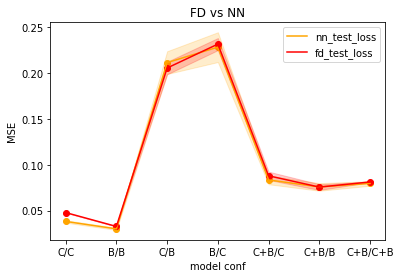

In [12]:
nn_mean = [nn_total_losses[i][0] for i in nn_total_losses.keys()]
nn_std = [nn_total_losses[i][1] for i in nn_total_losses.keys()]

fd_mean = [fd_total_losses[i][0] for i in fd_total_losses.keys()]
fd_std = [fd_total_losses[i][1] for i in fd_total_losses.keys()]

fig, ax = plt.subplots()
ax.fill_between(range(len(nn_std)), [nn_mean[i]+nn_std[i] for i in range(len(nn_std))], [nn_mean[i]-nn_std[i] for i in range(len(nn_std))], alpha=0.2, color='orange')
ax.plot(nn_mean, label='nn_test_loss', c='orange')
ax.scatter(range(len(nn_std)), nn_mean, c='orange')

ax.fill_between(range(len(fd_std)), [fd_mean[i]+fd_std[i] for i in range(len(fd_std))], [fd_mean[i]-fd_std[i] for i in range(len(fd_std))], alpha=0.2, color='red')
ax.plot(fd_mean, label='fd_test_loss', c='red')
ax.scatter(range(len(fd_mean)), fd_mean, c='red')
plt.legend()
ax.set_ylabel('MSE')
ax.set_xlabel('model conf')
ax.set_xticks(range(len(nn_mean)), labels=['C/C', 'B/B', 'C/B', 'B/C', 'C+B/C', 'C+B/B', 'C+B/C+B'])
plt.title('FD vs NN')
plt.show()

In [13]:
nn_total_losses, fd_total_losses

({'corridor_85-corridor_85': (0.03817544656853399, 0.001314887438304128),
  'bottleneck_180-bottleneck_180': (0.03005485799878879,
   0.0011295414610108228),
  'corridor_85-bottleneck_180': (0.21142969158881547, 0.01239971899469128),
  'bottleneck_180-corridor_85': (0.2282943350870217, 0.016258480324152048),
  'corridor_85+bottleneck_180-corridor_85': (0.08344512263331275,
   0.004687333490578842),
  'corridor_85+bottleneck_180-bottleneck_180': (0.07581592855044027,
   0.004133093969358995),
  'corridor_85+bottleneck_180-corridor_85+bottleneck_180': (0.07962132826247331,
   0.0024996186496920422)},
 {'corridor_85-corridor_85': (0.047845742898596576, 0.00010968886895653774),
  'bottleneck_180-bottleneck_180': (0.03270256703553152,
   0.00023686942203900225),
  'corridor_85-bottleneck_180': (0.20553720880509216, 0.006836585520716476),
  'bottleneck_180-corridor_85': (0.23161829905006098, 0.006620714753072639),
  'corridor_85+bottleneck_180-corridor_85': (0.0879700734776788,
   0.00452671